In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
#from sklearn.svm import LinearSVC
import pickle
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy import stats

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

%matplotlib inline

# Code from example 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Code from udacity course section
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_SQRT=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_SQRT, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_SQRT, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
def convert_color(img, cspace='RGB'):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)     
    return feature_image
    
    
# Code from udacity course section
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
  
        feature_image = convert_color(image, cspace='YUV')
           
        # When NAN values appear at normalization step --> transform_sqrt=False 
        # transform_SQRT=False
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True, transform_SQRT=False))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_SQRT=False)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Set to false if you want to retrain 
load_svm = True



### TODO: Tweak these parameters and see how the results change.
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" #"ALL" # Can be 0, 1, 2, or "ALL"

if load_svm == False: 

    # Loading cars and not cars images from disk 
    cars = glob.glob('./vehicles/*/*.png')
    notcars = glob.glob('./non-vehicles/*/*.png')

    print('Number of car samples: ', len(cars))
    print('Number of not car samples: ', len(cars))



    # Reduce the sample size because HOG features are slow to compute
    # The quiz evaluator times out after 13s of CPU time
    sample_size = len(cars)
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

    t=time.time()

    # Extracting CAR HOG Features 
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    # Extracting NOT CAR HOG Features 
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    ############### Normalizing Features 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')


    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Fit a per-column scaler
    #X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    #scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    #X_train, X_test, y_train, y_test = train_test_split(
    #    scaled_X, y, test_size=0.2, random_state=rand_state)

    ################ Training SVC
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    #####################################################################


    # Use a linear SVC 
    #http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

    # When using 
    #svc = LinearSVC()
    #print(svc.get_params().keys())
    #dict_keys(['intercept_scaling', 
    #           'multi_class', 
    #           'verbose', 
    #           'tol', 
    #           'random_state', 
    #           'class_weight', 
    #           'loss', 
    #           'max_iter', 
    #           'fit_intercept', 
    #           'penalty', 
    #           'dual', 
    #           'C'])

    # When using
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

    svc = svm.SVC()
    #print(svc.get_params().keys())
    #dict_keys(['class_weight', 
    #           'decision_function_shape', 
    #           'coef0', 
    #           'tol', 
    #           'gamma', 
    #           'random_state', 
    #           'shrinking', 
    #           'probability', 
    #           'cache_size', 
    #           'max_iter', 
    #           'degree', 
    #           'verbose', 
    #           'kernel', 
    #           'C'])

    #############################  RANDOM SEARCH
    #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV
    #https://stackoverflow.com/questions/26337403/what-is-a-good-range-of-values-for-the-svm-svc-hyperparameters-to-be-explored

    #param_dist = {"C": stats.uniform(1, 10), 'gamma': stats.uniform(1,10), 'kernel':['linear', 'rbf']}

    #param_dist = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel':['linear', 'rbf']}

    # http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization
    param_dist = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=.1),
      'kernel': ['linear','rbf'], 'class_weight':['balanced', None]}

    n_iter_search = 20
    random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=n_iter_search, n_jobs= 3)
    start = time.time()
    random_search.fit(X_train, y_train)

    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time.time() - start), n_iter_search))
    report(random_search.cv_results_)


    #############################  GRID SEARCH 

    #http://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search

    #param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

    #grid_search = GridSearchCV(svc, param_grid=param_grid)

    #start = time.time()
    #grid_search.fit(X, y)

    #print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
    #      % (time.time() - start, len(grid_search.cv_results_['params'])))
    #report(grid_search.cv_results_)


    ##################################################################
    ## Use a linear SVC 
    #svc = LinearSVC()
    ## Check the training time for the SVC
    #t=time.time()
    #svc.fit(X_train, y_train)
    #t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to train SVC...')
    ##################################################################
    
    print("Saving SVC training results")
    f = open('random_search_svc_result_2.pkl', 'wb')
    pickle.dump(random_search, f)
    f.close()
    print("Saving completed")
    
    scv_classyfier = random_search
else:
    # Loading calibration
    print("Loading SVC training results")
    f = open('random_search_svc_result_full_training_LUV.pkl', 'rb')
    scv_classyfier = pickle.load(f)
    f.close()
    print("Loading complete")



# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy





Loading SVC training results
Loading complete


## Result of a full RandomizedSearchCV training 

Number of car samples:  8792
Number of not car samples:  8792

/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

120.64 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4704
RandomizedSearchCV took 5152.68 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.993 (std: 0.000)
Parameters: {'gamma': 0.10925496029625786, 'C': 244.26224860807565, 'kernel': 'rbf', 'class_weight': None}

Model with rank: 2
Mean validation score: 0.992 (std: 0.000)
Parameters: {'gamma': 0.086233036977514402, 'C': 18.330163692478781, 'kernel': 'rbf', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.992 (std: 0.000)
Parameters: {'gamma': 0.18298554132477579, 'C': 358.03390387123073, 'kernel': 'rbf', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.992 (std: 0.000)
Parameters: {'gamma': 0.074905334855268846, 'C': 282.82476231987499, 'kernel': 'rbf', 'class_weight': None}

Saving SVC training results
Saving completed


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(scv_classyfier.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print(X_test[0])
print(len(X_test[0]))


print('My SVC predicts: ', scv_classyfier.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Test Accuracy of SVC =  0.9943
[ 0.00542919  0.00125614  0.01370988 ...,  0.00392076  0.00251804
  0.00209872]
4704
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  0.]
0.10934 Seconds to predict 10 labels with SVC


%matplotlib inline



# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

img = mpimg.imread('./30_second_car_overtake.png')


test = True

# I presuppose that I am using three color channel HOG without any other features 

def find_cars(img,\
              ystart,\
              ystop,\
              xstart,\
              xstop,\
              scale,\
              svc,\
              orient,\
              pix_per_cell,\
              cell_per_block,\
              visualization=False,
              only_show_boxes=False):
    
    global scv_classyfier
       
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

   
    #print("ystart", ystart)
    #print("xstart", xstart)
    #print("xstop", xstop)
    #print("ystop", ystop)


    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    
    
    ctrans_tosearch = convert_color(img_tosearch, cspace='YUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
   

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1   
    nyblocks = (ch1.shape[0] // pix_per_cell)  + 1  
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
   
    # Compute individual channel HOG features for the entire image
    if visualization == True:
        draw_image = img
        hog1, hog_image_ch1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=visualization, transform_SQRT=False)
        hog2, hog_image_ch2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=visualization, transform_SQRT=False)
        hog3, hog_image_ch3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=visualization, transform_SQRT=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, transform_SQRT=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, transform_SQRT=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, transform_SQRT=False)

    
    bbox_list = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
                     
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).astype(np.float64)  #
            
            #print(hog_features)
            #print(len(hog_features))

            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            if only_show_boxes == True:
                # WHAT DOES THE SEARCH AREA LOOK LIKE IF ALL RECTANGLES ARE DRAWN? 
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))            

            else:
                # Feature scaling only neccessary if multiple feature sources with different scalings are used
                # I am using only HOG features which should be scaled already? 
                # Create an array stack of feature vectors
                #X = np.vstack((hog_features)).astype(np.float64)                        
                # Fit a per-column scaler
                #X_scaler = StandardScaler().fit(X)
                # Apply the scaler to X
                #test_features = X_scaler.transform(X)

                test_prediction = scv_classyfier.predict(hog_features.reshape(1, -1))

                #print(test_prediction)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)


                    bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))            
                    if visualization == True:
                        cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
       
    if visualization == True:
        return draw_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list
    else:
        return bbox_list



/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Scale 3 ((750, 380), (942, 572))
Area:  135895.4496
Scale from area 3
Scale 2.5 ((980, 380), (1140, 540))
Area:  65536.0
Scale from area 2.0015497176235675
Scale 1 ((750, 380), (814, 444))
Area:  1677.7216000000008
Scale from area 1.0499891460161825


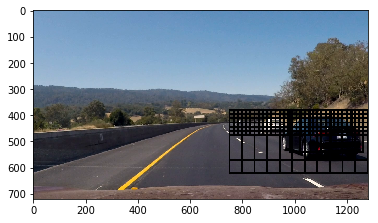

In [3]:
# Here is your draw_boxes function from the previous exercise
def draw_new_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
   
def area_to_scale(area,a, b, minimum, maximum):
    if area>=maximum:
        return b 
    if area<=minimum:
        return a
    
    scaled = (((b-a)*(area+minimum))/(maximum-minimum))+a
    
    return scaled


all_bb = []



max_area= 135895
min_area = 1677
lower_scale_bound = 1
upper_scale_bound = 3

# NEAR RANGE     
    
ystart = 380
ystop = 620

#xstart = 50
xstart = 750

xstop = 1280
scale = 3
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )

print("Scale 3", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)


all_bb.append(bbox_list)


# NEAR RANGE FAR RIGHT     
    
ystart = 380
ystop = 550

#xstart = 50
xstart = 980

xstop = 1280
scale = 2.5
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )


print("Scale 2.5", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)
all_bb.append(bbox_list)



# FAR RANGE 

ystart = 380
ystop = 480

#xstart = 50
xstart = 750

xstop = 1280
scale = 1
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )

print("Scale 1", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)

all_bb.append(bbox_list)









    
all_boxes_image = draw_new_boxes(np.copy(img), all_bb, color=(0, 0, 255), thick=6)

if test == True: 
    plt.imshow(all_boxes_image)
    plt.show()    
    
    
    #plt.imshow(hog_image_ch1)
    #plt.show()        
    #plt.imshow(hog_image_ch2)
    #plt.show()        
    #plt.imshow(hog_image_ch3)

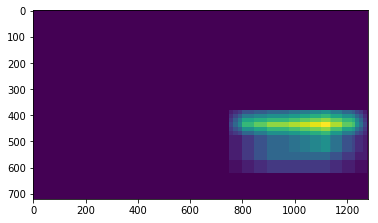

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for i in range(len(bbox_list)):
        for box in bbox_list[i]:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

if test == True: 
    # Test out the heatmap
    full_heatmap = np.zeros_like(img[:,:,0])
    full_heatmap = add_heat(full_heatmap, all_bb)                    
    plt.imshow(full_heatmap)


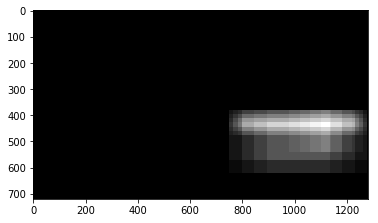

In [5]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap


if test == True: 
    heatmap_threshold = 1
    binary_thresholded = apply_threshold(full_heatmap, heatmap_threshold)
    plt.imshow(binary_thresholded, cmap = 'gray')

5 cars found


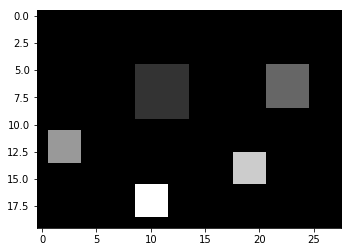

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

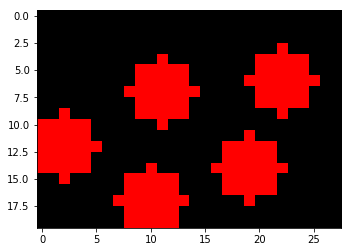

[((9, 5), (13, 9)), ((21, 5), (24, 8)), ((1, 11), (3, 13)), ((18, 13), (20, 15)), ((9, 16), (11, 18))]
((9, 5), (13, 9))
((9, 5), (13, 9))
((21, 5), (24, 8))
((21, 5), (24, 8))
((1, 11), (3, 13))
((1, 11), (3, 13))
((18, 13), (20, 15))
((18, 13), (20, 15))
((9, 16), (11, 18))
((9, 16), (11, 18))
5
5
Box center 0: (7.0, 11.0)
Coordiantes: ((9, 5), (13, 9))
Box center 1: (6.5, 22.5)
Coordiantes: ((21, 5), (24, 8))
Box center 2: (12.0, 2.0)
Coordiantes: ((1, 11), (3, 13))
Box center 3: (14.0, 19.0)
Coordiantes: ((18, 13), (20, 15))
Box center 4: (17.0, 10.0)
Coordiantes: ((9, 16), (11, 18))
Coordiantes x_min: 9 Coordiantes y_min: 16
Coordiantes x_max: 11 Coordiantes y_max: 18


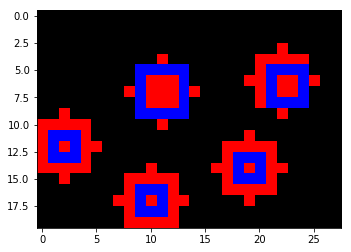

In [6]:
img = mpimg.imread('./30_second_car_overtake.png')


def draw_centers(input_image, center_inputs, use_255=False):
    for i in range(len(center_inputs)):
        print(center_inputs)
        if(np.isnan(center_inputs[i][0]) & np.isnan(center_inputs[i][1])):
                print("skip")
        else:
            print("center")
            # KEEP IN MIND - CV DRAWS (v,u) --> (y,x) --> AWWWRGHH! 
            # Color! 
            if use_255 == False:
                cv2.circle(input_image,(int(center_inputs[i][1]),int(center_inputs[i][0])), 10, (1,0,0), -1)
            else:
                cv2.circle(input_image,(int(center_inputs[i][1]),int(center_inputs[i][0])), 3, (255,0,0), -1)

    return input_image

def get_labeled_bboxes(labels):
    bbox = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #print(np.min(nonzerox))
        #print(np.min(nonzeroy))
        #print(np.max(nonzerox))
        #print(np.max(nonzeroy))

        # Define a bounding box based on min/max x and y
        bbox.append(((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy))))            
    return bbox

def draw_bboxes(input_image, bboxes, cofm, test=False):
    #print(bboxes)
    for i in range(len(bboxes)):
        #print(bboxes[i][0], ",", bboxes[i][1])
        print(bboxes[i])
        print(bboxes[i])
        if test==True:
            cv2.rectangle(input_image, bboxes[i][0], bboxes[i][1], (0,0,255),1)
        else:
            input_image = draw_centers(input_image, cofm, use_255=True)
            cv2.rectangle(input_image, bboxes[i][0], bboxes[i][1], (0,0,255),6)
    return input_image




from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import center_of_mass


######################## Testing center of mass scipy 


b = np.array(([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],))
labels = label(b)


#print("b labels" , labels)

if test == True: 
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    plt.show()

print(labels[0])
    
    
# This acutually took me quite a while to realize how to use this to get all labels 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html
# index : int or sequence of ints, optional
# Labels for which to calculate centers-of-mass. If not specified, all labels greater than zero are used. Only used with labels.
# list(range(1,labels[1]+1))
    
centers = center_of_mass(b, labels[0],list(range(1,labels[1]+1)))


#centers = center_of_mass(np.array(binary_thresholded))
print("centers",centers)

b_color = np.dstack((b, b, b))
b_color = b_color.astype(np.uint8)

center_image = draw_centers(b_color, centers, use_255=True)
plt.imshow(center_image)
plt.show()

bounding_boxes = get_labeled_bboxes(labels)
print (bounding_boxes) 
draw_img = draw_bboxes(np.copy(b_color), bounding_boxes, centers, test=True)

print(len(centers))
print(len(bounding_boxes))

print("Box center 0:", centers[0])
print("Coordiantes:", bounding_boxes[0])

print("Box center 1:", centers[1])
print("Coordiantes:", bounding_boxes[1])

print("Box center 2:", centers[2])
print("Coordiantes:", bounding_boxes[2])

print("Box center 3:", centers[3])
print("Coordiantes:", bounding_boxes[3])

print("Box center 4:", centers[4])
print("Coordiantes:", bounding_boxes[4])
print("Coordiantes x_min:", bounding_boxes[4][0][0] ,"Coordiantes y_min:", bounding_boxes[4][0][1])
print("Coordiantes x_max:", bounding_boxes[4][1][0] ,"Coordiantes y_max:", bounding_boxes[4][1][1])


# Display the image
plt.imshow(draw_img)
plt.show()
    
################################################################################
    
    
    
    

    
    
    

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
[(470.61969111969114, 1023.7316602316603)]
((750, 380), (1277, 619))
((750, 380), (1277, 619))
[(470.61969111969114, 1023.7316602316603)]
center


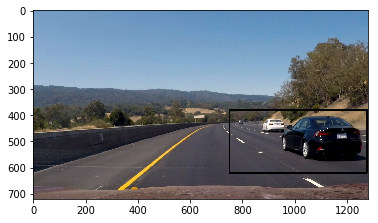

In [7]:
if test == True: 
    labels = label(binary_thresholded)
    print(labels)



    centers = center_of_mass(binary_thresholded, labels[0],list(range(1,labels[1]+1)))
    print(centers)

    #center_image = draw_centers(img, centers)
    #plt.imshow(center_image)
    #plt.show()
    
    # Draw bounding boxes on a copy of the image
    
    bounding_boxes = get_labeled_bboxes(labels)
    #print (bounding_boxes) 
    draw_img = draw_bboxes(np.copy(img), bounding_boxes, centers)
    
    
    # Display the image
    plt.imshow(draw_img)

In [8]:
import copy


class tracked_object():
    def __init__(self, _CENTER, _BB):
        # Camera name 
        # KEEP IN MIND center = (y,x)
        self.center = _CENTER 
        self.bb = _BB
        
class tracks():
    def __init__(self):
        self.objects = [] 
    
    def add_new_objects(self, _new_objects):
        self.objects = []
        self.objects = copy.deepcopy(_new_objects)
        
    def reset_objects(self):
        self.objects = []
    

tracked_objects = tracks()

In [13]:
frame_counter = 0 
modulo_frame_skipper = 5


def process(input_image): 
    
    global frame_counter 
    global modulo_frame_skipper
    global tracked_objects 
    
    all_bb = []
    
    print("LENGTH TRACKED OBJECT LIST: ", len(tracked_objects.objects))
        
    if((frame_counter%modulo_frame_skipper == 0) | (len(tracked_objects.objects) == 0)):
       
        
        
        # NEAR RANGE 
        
        ystart = 380
        ystop = 620

        #xstart = 50
        xstart = 750

        xstop = 1280
        scale = 3
        
        
        
        bbox_list2 = find_cars(input_image,\
                     ystart,\
                     ystop,\
                     xstart,\
                     xstop,\
                     scale,\
                     scv_classyfier,\
                     orient,\
                     pix_per_cell,\
                     cell_per_block,\
                     visualization=False,\
                     only_show_boxes=False  )

        print(bbox_list2)
        
        if len(bbox_list2) > 0:
            print("NEAR RANGE ", bbox_list2)
            all_bb.append(bbox_list2)  
        

        
        # NEAR RANGE FAR RIGHT     

        ystart = 380
        ystop = 550

        #xstart = 50
        xstart = 980

        xstop = 1280
        scale = 2.5
          
    
        bbox_list3 = find_cars(input_image,\
                 ystart,\
                 ystop,\
                 xstart,\
                 xstop,\
                 scale,\
                 scv_classyfier,\
                 orient,\
                 pix_per_cell,\
                 cell_per_block,\
                 visualization=False,\
                 only_show_boxes=False  )

        print(bbox_list3)
        
        if len(bbox_list3) > 0:
            print("NEAR RANGE FAR LEFT ", bbox_list3)
            all_bb.append(bbox_list3)  
        
        
        ystart = 380
        ystop = 480

        #xstart = 50
        xstart = 750

        xstop = 1280
        scale = 1
                
        
        # FAR RANGE 
        bbox_list4 = find_cars(input_image,\
                     ystart,\
                     ystop,\
                     xstart,\
                     xstop,\
                     scale,\
                     scv_classyfier,\
                     orient,\
                     pix_per_cell,\
                     cell_per_block,\
                     visualization=False,\
                     only_show_boxes=False  )

        print(bbox_list4)
        
        if len(bbox_list4) > 0:
                        
            print("FAR RANGE ", bbox_list4)
            all_bb.append(bbox_list4)  
       
    
    
    
    
    
    
    
        # Use alle found bounding boxes to generate a heat map 
            
        if len(all_bb) > 0:
            full_heatmap = np.zeros_like(input_image[:,:,0])
            full_heatmap = add_heat(full_heatmap, all_bb)        

           
            heatmap_threshold = 1
            binary_thresholded = apply_threshold(full_heatmap, heatmap_threshold)

            labels = []
            labels = label(binary_thresholded)
                               
            detection_boxes = []
            detection_boxes = get_labeled_bboxes(labels)
            
            new_centers = []
            # I do not now why there is always a second center of mass containted with NAN coordinates 
            #new_centers = center_of_mass(binary_thresholded, labels[0], [1,2])

            
            new_centers = center_of_mass(binary_thresholded, labels[0],list(range(1,labels[1]+1)))
            print(new_centers)
            
            new_objects = []
            
            for i in range(len(detection_boxes)):
                # (self, _CENTER, _BB):
                new_objects.append(tracked_object(new_centers[i] ,detection_boxes[i]))
            
            print(new_objects)
            
            if(len(tracked_objects.objects) == 0):
                print("No objects present, initializing with ", len(new_objects), " objects")
                tracked_objects.add_new_objects(new_objects)
            else:
                print("Updating Object list")
                tracked_objects.add_new_objects(new_objects)
            
            
            #plt.imshow(center_image)
            #plt.show()
                        
            #print (bounding_boxes) 
            res_image = draw_bboxes(np.copy(input_image), detection_boxes, new_centers)
            
            
            cv2.putText(res_image,'BB = %d'%(len(all_bb)),(55,55), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        else:
            print("No new objects found in full search")
            res_image =  np.copy(input_image)    
    else:
        if(len(tracked_objects.objects) == 0):           
            print("No object copy image")
            res_image =  np.copy(input_image)
        else:
            print("Using last object positions")
            old_centers = []
            old_bboxes = []
            new_bboxes = []
            
            for i in range(len(tracked_objects.objects)):
                
                old_centers.append(tracked_objects.objects[i].center)
                old_bboxes.append(tracked_objects.objects[i].bb)
                
                
                print(tracked_objects.objects[i].bb)
                
                print(tracked_objects.objects[i].bb[0])
                print(tracked_objects.objects[i].bb[1])
                
                print(tracked_objects.objects[i].bb[0][0])
                print(tracked_objects.objects[i].bb[0][1])
                
                print(tracked_objects.objects[i].bb[1][0])
                print(tracked_objects.objects[i].bb[1][1])


                #((1060, 380), (1259, 539))
                #(1060, 380)
                #(1259, 539)
                #1060
                #380
                
                offset = 40
                
                xstart = tracked_objects.objects[i].bb[0][0] - offset
                xstop = tracked_objects.objects[i].bb[1][0] + offset
                
                ystart = tracked_objects.objects[i].bb[0][1] - offset
                ystop = tracked_objects.objects[i].bb[1][1] + offset 
                
                print("xstart: " , xstart, "xstop: ", xstop)
                print("ystart: " , ystart, "ystop: ", ystop)
                
                x_bb_size = tracked_objects.objects[i].bb[1][0]-tracked_objects.objects[i].bb[0][0] 
                y_bb_size = tracked_objects.objects[i].bb[1][1]-tracked_objects.objects[i].bb[0][1]
                
                print("x bb size: ", x_bb_size)
                print("y bb size: ", y_bb_size)
                
                A = pow((x_bb_size)/10,2) *\
                    pow((y_bb_size)/10,2)
                print("Area: ",A)

                scale = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
                
                print("search scale: ", scale)
                        
                search_area_bboxes = []
                
                # FAR RANGE 
                search_area_bboxes = find_cars(input_image,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )
                
                if len(search_area_bboxes) > 0:
                    print("# new search boxes", len(search_area_bboxes))
                    new_bboxes.append(search_area_bboxes)  
            
        
        
            # Use alle found bounding boxes to generate a heat map 

            if len(new_bboxes) > 0:
                full_heatmap = np.zeros_like(input_image[:,:,0])
                full_heatmap = add_heat(full_heatmap, new_bboxes)        


                heatmap_threshold = 1
                binary_thresholded = apply_threshold(full_heatmap, heatmap_threshold)

                labels = []
                labels = label(binary_thresholded)

                detection_boxes = []
                detection_boxes = get_labeled_bboxes(labels)

                new_centers = []
                # I do not now why there is always a second center of mass containted with NAN coordinates 
                #new_centers = center_of_mass(binary_thresholded, labels[0], [1,2])


                new_centers = center_of_mass(binary_thresholded, labels[0],list(range(1,labels[1]+1)))
                print(new_centers)

                new_objects = []

                for i in range(len(detection_boxes)):
                    # (self, _CENTER, _BB):
                    new_objects.append(tracked_object(new_centers[i] ,detection_boxes[i]))

                print(new_objects)

                if(len(tracked_objects.objects) == 0):
                    print("No objects present, initializing with ", len(new_objects), " objects")
                    tracked_objects.add_new_objects(new_objects)
                else:
                    print("Updating Object list")
                    tracked_objects.add_new_objects(new_objects)


                #plt.imshow(center_image)
                #plt.show()

                #print (bounding_boxes) 
                res_image = draw_bboxes(np.copy(input_image), detection_boxes, new_centers)


                cv2.putText(res_image,'BB = %d'%(len(all_bb)),(55,55), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
            else:
                print("No new objects found in full search, resetting tracked object list")
                tracked_objects.reset_objects()
                #res_image =  np.copy(input_image)   
                # ######################################## JUST FOR TEST   
                res_image = draw_bboxes(np.copy(input_image),\
                                                old_bboxes,\
                                                old_centers)        
                ############################################################################# #  


    frame_counter = frame_counter + 1
    cv2.putText(res_image,'Frame = %d'%(frame_counter),(55,35), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(res_image,'BB = %d'%(len(all_bb)),(55,55), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    
    return res_image

LENGTH TRACKED OBJECT LIST:  1
[]


/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
[]
[(459.5, 1159.5)]
Updating Object list
((1060, 380), (1259, 539))
((1060, 380), (1259, 539))
[(459.5, 1159.5)]
center


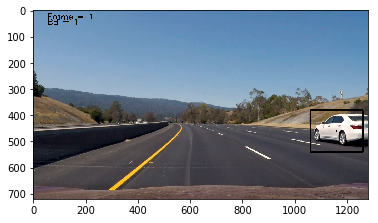

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1259, 539))
(1060, 380)
(1259, 539)
1060
380
1259
539
xstart:  1020 xstop:  1299
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.2881
search scale:  2.51682021934
# new search boxes 1
[(460.0, 1140.0)]
Updating Object list
((1060, 380), (1220, 540))
((1060, 380), (1220, 540))
[(460.0, 1140.0)]
center


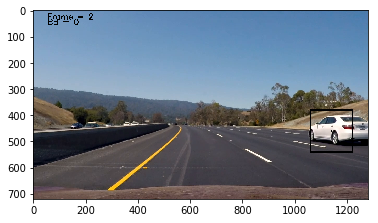

LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]
[]
[(459.5, 1139.5)]
Updating Object list
((1020, 380), (1259, 539))
((1020, 380), (1259, 539))
[(459.5, 1139.5)]
center


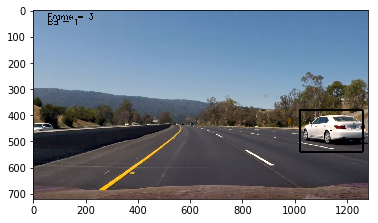

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1259, 539))
(1020, 380)
(1259, 539)
1020
380
1259
539
xstart:  980 xstop:  1299
ystart:  340 ystop:  579
x bb size:  239
y bb size:  159
Area:  144407.6001
search scale:  3
No new objects found in full search, resetting tracked object list
((1020, 380), (1259, 539))
((1020, 380), (1259, 539))
[(459.5, 1139.5)]
center


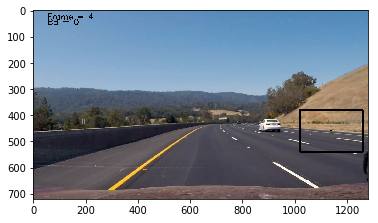

LENGTH TRACKED OBJECT LIST:  0
[]
[]
[((878, 412), (942, 476))]
FAR RANGE  [((878, 412), (942, 476))]
[(443.5, 909.5)]
No objects present, initializing with  1  objects
((878, 412), (941, 475))
((878, 412), (941, 475))
[(443.5, 909.5)]
center


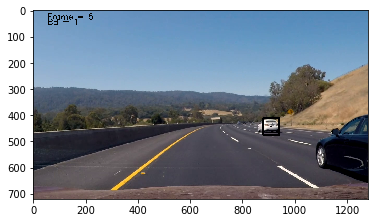

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 412), (941, 475))
(878, 412)
(941, 475)
878
412
941
475
xstart:  838 xstop:  981
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2961
search scale:  1
# new search boxes 1
[(435.5, 901.5)]
Updating Object list
((870, 404), (933, 467))
((870, 404), (933, 467))
[(435.5, 901.5)]
center


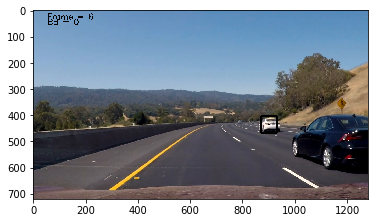

LENGTH TRACKED OBJECT LIST:  1
[((990, 380), (1182, 572)), ((1038, 380), (1230, 572)), ((1038, 428), (1230, 620)), ((1086, 428), (1278, 620))]
NEAR RANGE  [((990, 380), (1182, 572)), ((1038, 380), (1230, 572)), ((1038, 428), (1230, 620)), ((1086, 428), (1278, 620))]
[]
[((894, 412), (958, 476))]
FAR RANGE  [((894, 412), (958, 476))]
[(499.5, 1133.5), (443.5, 925.5)]
[<__main__.tracked_object object at 0x7f509e91fb38>, <__main__.tracked_object object at 0x7f509e91fe80>]
Updating Object list
((990, 380), (1277, 619))
((990, 380), (1277, 619))
[(499.5, 1133.5), (443.5, 925.5)]
center
[(499.5, 1133.5), (443.5, 925.5)]
center
((894, 412), (957, 475))
((894, 412), (957, 475))
[(499.5, 1133.5), (443.5, 925.5)]
center
[(499.5, 1133.5), (443.5, 925.5)]
center


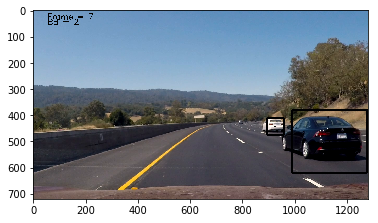

LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((990, 380), (1277, 619))
(990, 380)
(1277, 619)
990
380
1277
619
xstart:  950 xstop:  1317
ystart:  340 ystop:  659
x bb size:  287
y bb size:  239
Area:  470499.9649
search scale:  3
# new search boxes 3
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2961
search scale:  1
# new search boxes 2
[(465.29310344827587, 1052.1206896551723)]
Updating Object list
((886, 340), (1189, 579))
((886, 340), (1189, 579))
[(465.29310344827587, 1052.1206896551723)]
center


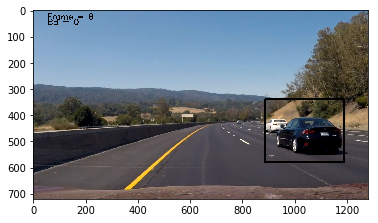

In [14]:
modulo_frame_skipper = 2



#img = mpimg.imread('./05_first_car_overtake.png')
#result_image = process(img)
#plt.imshow(result_image)
#plt.show()

#img = mpimg.imread('./06_first_car_overtake.png')
#result_image = process(img)
#plt.imshow(result_image)
#plt.show()

#img = mpimg.imread('./07_first_car_overtake.png')
#result_image = process(img)
#plt.imshow(result_image)
#plt.show()


img = mpimg.imread('./08_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


img = mpimg.imread('./09_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


img = mpimg.imread('./10_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


img = mpimg.imread('./27_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./28_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./29_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./30_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./31_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


In [16]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import *


modulo_frame_skipper = 10



white_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds


# First curve 

# first car drive by 
#clip1 = VideoFileClip("project_video.mp4").subclip(6,10)


# Second car drive by 
#clip1 = VideoFileClip("project_video.mp4").subclip(26,31)


# first to second 
clip1 = VideoFileClip("project_video.mp4").subclip(6,31)


# 
#clip1 = VideoFileClip("project_video.mp4").subclip(26,50)


#VideoFileClip("project_video.mp4").save_frame("05_first_car_overtake.png", t=5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("06_first_car_overtake.png", t=6, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("07_first_car_overtake.png", t=7, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("08_first_car_overtake.png", t=8, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("09_first_car_overtake.png", t=9, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("10_first_car_overtake.png", t=10, withmask=True)


#VideoFileClip("project_video.mp4").save_frame("27_second_car_overtake.png", t=27, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("28_second_car_overtake.png", t=28, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("29_second_car_overtake.png", t=29, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("30_second_car_overtake.png", t=30, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("31_second_car_overtake.png", t=31, withmask=True)


# Booth cars 
#clip1 = VideoFileClip("project_video.mp4").subclip(37,38)
#clip1 = VideoFileClip("project_video.mp4")


white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1041, 347), (1232, 538))
(1041, 347)
(1232, 538)
1041
347
1232
538
xstart:  1001 xstop:  1272
ystart:  307 ystop:  578
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1041, 347), (1232, 538))
((1041, 347), (1232, 538))
[(442.5, 1136.5)]
center
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  0%|          | 0/626 [00:00<?, ?it/s]

LENGTH TRACKED OBJECT LIST:  0
[]
[]


  0%|          | 1/626 [00:01<12:58,  1.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  0%|          | 2/626 [00:02<12:54,  1.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  0%|          | 3/626 [00:03<12:52,  1.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  1%|          | 4/626 [00:04<12:54,  1.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  1%|          | 5/626 [00:06<12:49,  1.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  1%|          | 6/626 [00:07<12:45,  1.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  1%|          | 7/626 [00:08<12:48,  1.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  1%|▏         | 8/626 [00:09<12:59,  1.26s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  1%|▏         | 9/626 [00:11<13:23,  1.30s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  2%|▏         | 10/626 [00:12<13:16,  1.29s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  2%|▏         | 11/626 [00:13<13:12,  1.29s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  2%|▏         | 12/626 [00:15<13:03,  1.28s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  2%|▏         | 13/626 [00:16<13:00,  1.27s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  2%|▏         | 14/626 [00:17<12:56,  1.27s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  2%|▏         | 15/626 [00:18<12:53,  1.27s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  3%|▎         | 16/626 [00:20<12:45,  1.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


  3%|▎         | 17/626 [00:21<12:40,  1.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  3%|▎         | 18/626 [00:22<12:51,  1.27s/it]

[]
[(459.5, 1179.5)]
No objects present, initializing with  1  objects
((1100, 380), (1259, 539))
((1100, 380), (1259, 539))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1100, 380), (1259, 539))
(1100, 380)
(1259, 539)
1100
380
1259
539
xstart:  1060 xstop:  1299
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


  3%|▎         | 19/626 [00:22<09:38,  1.05it/s]

# new search boxes 2
[(449.5, 1185.5)]
Updating Object list
((1123, 371), (1248, 528))
((1123, 371), (1248, 528))
[(449.5, 1185.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1123, 371), (1248, 528))
(1123, 371)
(1248, 528)
1123
371
1248
528
xstart:  1083 xstop:  1288
ystart:  331 ystop:  568
x bb size:  125
y bb size:  157
Area:  38514.0625
search scale:  1.5988922871745965


  3%|▎         | 20/626 [00:23<07:45,  1.30it/s]

# new search boxes 6
[(457.83333333333331, 1197.0)]
Updating Object list
((1134, 382), (1260, 534))
((1134, 382), (1260, 534))
[(457.83333333333331, 1197.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  3%|▎         | 21/626 [00:24<09:26,  1.07it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
Updating Object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  4%|▎         | 23/626 [00:26<08:39,  1.16it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
No objects present, initializing with  1  objects
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  4%|▍         | 25/626 [00:27<08:05,  1.24it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
No objects present, initializing with  1  objects
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  4%|▍         | 27/626 [00:28<07:45,  1.29it/s]

[]
[(459.5, 1179.5)]
No objects present, initializing with  1  objects
((1100, 380), (1259, 539))
((1100, 380), (1259, 539))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1100, 380), (1259, 539))
(1100, 380)
(1259, 539)
1100
380
1259
539
xstart:  1060 xstop:  1299
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


  4%|▍         | 28/626 [00:29<06:06,  1.63it/s]

# new search boxes 3
[(454.83333333333331, 1174.8333333333333)]
Updating Object list
((1091, 371), (1248, 528))
((1091, 371), (1248, 528))
[(454.83333333333331, 1174.8333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1091, 371), (1248, 528))
(1091, 371)
(1248, 528)
1091
371
1248
528
xstart:  1051 xstop:  1288
ystart:  331 ystop:  568
x bb size:  157
y bb size:  157
Area:  60757.32009999999
search scale:  1.9303419824464676


  5%|▍         | 29/626 [00:29<05:01,  1.98it/s]

# new search boxes 5
[(453.0, 1173.0)]
Updating Object list
((1081, 361), (1265, 545))
((1081, 361), (1265, 545))
[(453.0, 1173.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1081, 361), (1265, 545))
(1081, 361)
(1265, 545)
1081
361
1265
545
xstart:  1041 xstop:  1305
ystart:  321 ystop:  585
x bb size:  184
y bb size:  184
Area:  114622.87359999996
search scale:  2.732999651313534
# new search boxes 1
[(450.5, 1170.5)]
Updating Object list
((1084, 364), (1257, 537))
((1084, 364), (1257, 537))
[(450.5, 1170.5)]


  5%|▍         | 30/626 [00:29<03:57,  2.51it/s]

center
LENGTH TRACKED OBJECT LIST:  1
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  5%|▍         | 31/626 [00:30<06:36,  1.50it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
Updating Object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  5%|▌         | 33/626 [00:32<06:36,  1.49it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
No objects present, initializing with  1  objects
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  6%|▌         | 35/626 [00:33<06:35,  1.49it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
No objects present, initializing with  1  objects
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[((1086, 380), (1278, 572))]
NEAR RANGE  [((1086, 380), (1278, 572))]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


  6%|▌         | 37/626 [00:34<06:34,  1.49it/s]

[]
[(468.94262295081967, 1180.6803278688524)]
No objects present, initializing with  1  objects
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1086, 380), (1277, 571))
(1086, 380)
(1277, 571)
1086
380
1277
571
xstart:  1046 xstop:  1317
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1086, 380), (1277, 571))
((1086, 380), (1277, 571))
[(468.94262295081967, 1180.6803278688524)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]


  6%|▋         | 40/626 [00:36<04:59,  1.95it/s]

[]
[(459.5, 1159.5)]
No objects present, initializing with  1  objects
((1060, 380), (1259, 539))
((1060, 380), (1259, 539))
[(459.5, 1159.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1259, 539))
(1060, 380)
(1259, 539)
1060
380
1259
539
xstart:  1020 xstop:  1299
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 2
[(460.0, 1160.0)]
Updating Object list
((1060, 380), (1260, 540))
((1060, 380), (1260, 540))
[(460.0, 1160.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]


  7%|▋         | 42/626 [00:37<05:31,  1.76it/s]

[]
[(459.5, 1159.5)]
Updating Object list
((1060, 380), (1259, 539))
((1060, 380), (1259, 539))
[(459.5, 1159.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1259, 539))
(1060, 380)
(1259, 539)
1060
380
1259
539
xstart:  1020 xstop:  1299
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 4
[(440.0, 1160.0)]
Updating Object list
((1060, 340), (1260, 540))
((1060, 340), (1260, 540))
[(440.0, 1160.0)]
center
LENGTH TRACKED OBJECT LIST: 

  7%|▋         | 43/626 [00:37<04:15,  2.28it/s]

 1
Using last object positions
((1060, 340), (1260, 540))
(1060, 340)
(1260, 540)
1060
340
1260
540
xstart:  1020 xstop:  1300
ystart:  300 ystop:  580
x bb size:  200
y bb size:  200
Area:  160000.0
search scale:  3
# new search boxes 1
[(443.5, 1163.5)]
Updating Object list
((1068, 348), (1259, 539))
((1068, 348), (1259, 539))
[(443.5, 1163.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1068, 348), (1259, 539))
(1068, 348)
(1259, 539)
1068
348
1259
539
xstart:  1028 xstop:  1299
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


  7%|▋         | 45/626 [00:38<02:45,  3.52it/s]

# new search boxes 1
[(451.5, 1171.5)]
Updating Object list
((1076, 356), (1267, 547))
((1076, 356), (1267, 547))
[(451.5, 1171.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1076, 356), (1267, 547))
(1076, 356)
(1267, 547)
1076
356
1267
547
xstart:  1036 xstop:  1307
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1
[(459.5, 1179.5)]
Updating Object list
((1084, 364), (1275, 555))
((1084, 364), (1275, 555))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1084, 364), (1275, 555))
(1084, 364)
(1275, 555)
1084
364
1275
555
xstart:  1044 xstop:  1315
ystart:  324 ystop:  595
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1084, 364), (1275, 555))
((1084, 364), (1275, 555))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[

  8%|▊         | 47/626 [00:39<03:50,  2.51it/s]

[]
[(459.5, 1159.5)]
No objects present, initializing with  1  objects
((1060, 380), (1259, 539))
((1060, 380), (1259, 539))
[(459.5, 1159.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1259, 539))
(1060, 380)
(1259, 539)
1060
380
1259
539
xstart:  1020 xstop:  1299
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 3


  8%|▊         | 49/626 [00:39<02:35,  3.71it/s]

[(446.66666666666669, 1166.6666666666667)]
Updating Object list
((1060, 340), (1260, 540))
((1060, 340), (1260, 540))
[(446.66666666666669, 1166.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 340), (1260, 540))
(1060, 340)
(1260, 540)
1060
340
1260
540
xstart:  1020 xstop:  1300
ystart:  300 ystop:  580
x bb size:  200
y bb size:  200
Area:  160000.0
search scale:  3
# new search boxes 1
[(443.5, 1163.5)]
Updating Object list
((1068, 348), (1259, 539))
((1068, 348), (1259, 539))
[(443.5, 1163.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1068, 348), (1259, 539))
(1068, 348)
(1259, 539)
1068
348
1259
539
xstart:  1028 xstop:  1299
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


  8%|▊         | 50/626 [00:39<02:11,  4.38it/s]

# new search boxes 1
[(451.5, 1171.5)]
Updating Object list
((1076, 356), (1267, 547))
((1076, 356), (1267, 547))
[(451.5, 1171.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]


  8%|▊         | 51/626 [00:41<05:18,  1.80it/s]

[]
[(459.5, 1159.5)]
Updating Object list
((1060, 380), (1259, 539))
((1060, 380), (1259, 539))
[(459.5, 1159.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1259, 539))
(1060, 380)
(1259, 539)
1060
380
1259
539
xstart:  1020 xstop:  1299
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 3


  8%|▊         | 53/626 [00:41<03:20,  2.85it/s]

[(446.66666666666669, 1166.6666666666667)]
Updating Object list
((1060, 340), (1260, 540))
((1060, 340), (1260, 540))
[(446.66666666666669, 1166.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 340), (1260, 540))
(1060, 340)
(1260, 540)
1060
340
1260
540
xstart:  1020 xstop:  1300
ystart:  300 ystop:  580
x bb size:  200
y bb size:  200
Area:  160000.0
search scale:  3
# new search boxes 1
[(443.5, 1163.5)]
Updating Object list
((1068, 348), (1259, 539))
((1068, 348), (1259, 539))
[(443.5, 1163.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1068, 348), (1259, 539))
(1068, 348)
(1259, 539)
1068
348
1259
539
xstart:  1028 xstop:  1299
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


  9%|▉         | 55/626 [00:41<02:17,  4.15it/s]

# new search boxes 1
[(451.5, 1171.5)]
Updating Object list
((1076, 356), (1267, 547))
((1076, 356), (1267, 547))
[(451.5, 1171.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1076, 356), (1267, 547))
(1076, 356)
(1267, 547)
1076
356
1267
547
xstart:  1036 xstop:  1307
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1
[(459.5, 1179.5)]
Updating Object list
((1084, 364), (1275, 555))
((1084, 364), (1275, 555))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1084, 364), (1275, 555))
(1084, 364)
(1275, 555)
1084
364
1275
555
xstart:  1044 xstop:  1315
ystart:  324 ystop:  595
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1084, 364), (1275, 555))
((1084, 364), (1275, 555))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[

  9%|▉         | 57/626 [00:43<03:33,  2.66it/s]

[]
[(459.5, 1159.5)]
No objects present, initializing with  1  objects
((1060, 380), (1259, 539))
((1060, 380), (1259, 539))
[(459.5, 1159.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1259, 539))
(1060, 380)
(1259, 539)
1060
380
1259
539
xstart:  1020 xstop:  1299
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 2
[(440.0, 1160.0)]
Updating Object list
((1060, 340), (1260, 540))


  9%|▉         | 59/626 [00:43<02:25,  3.88it/s]

((1060, 340), (1260, 540))
[(440.0, 1160.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 340), (1260, 540))
(1060, 340)
(1260, 540)
1060
340
1260
540
xstart:  1020 xstop:  1300
ystart:  300 ystop:  580
x bb size:  200
y bb size:  200
Area:  160000.0
search scale:  3
# new search boxes 1
[(443.5, 1163.5)]
Updating Object list
((1068, 348), (1259, 539))
((1068, 348), (1259, 539))
[(443.5, 1163.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1068, 348), (1259, 539))
(1068, 348)
(1259, 539)
1068
348
1259
539
xstart:  1028 xstop:  1299
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 10%|▉         | 60/626 [00:43<02:05,  4.49it/s]

# new search boxes 1
[(451.5, 1171.5)]
Updating Object list
((1076, 356), (1267, 547))
((1076, 356), (1267, 547))
[(451.5, 1171.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540))]


 10%|▉         | 61/626 [00:44<05:16,  1.78it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1060, 380), (1219, 539))
((1060, 380), (1219, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1219, 539))
(1060, 380)
(1219, 539)
1060
380
1219
539
xstart:  1020 xstop:  1259
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 10%|▉         | 62/626 [00:45<04:29,  2.09it/s]

# new search boxes 1
[(433.5, 1145.5)]
Updating Object list
((1083, 371), (1208, 496))
((1083, 371), (1208, 496))
[(433.5, 1145.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1083, 371), (1208, 496))
(1083, 371)
(1208, 496)
1083
371
1208
496
xstart:  1043 xstop:  1248
ystart:  331 ystop:  536
x bb size:  125
y bb size:  125
Area:  24414.0625
search scale:  1.3887863401332161


 10%|█         | 63/626 [00:45<04:34,  2.05it/s]

# new search boxes 4
[(457.0, 1141.75)]
Updating Object list
((1065, 397), (1241, 506))
((1065, 397), (1241, 506))
[(457.0, 1141.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1065, 397), (1241, 506))
(1065, 397)
(1241, 506)
1065
397
1241
506
xstart:  1025 xstop:  1281
ystart:  357 ystop:  546
x bb size:  176
y bb size:  109
Area:  36802.585600000006
search scale:  1.573389345691338


 10%|█         | 64/626 [00:46<04:30,  2.08it/s]

# new search boxes 3
[(448.16666666666669, 1149.5)]
Updating Object list
((1075, 382), (1249, 506))
((1075, 382), (1249, 506))
[(448.16666666666669, 1149.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1075, 382), (1249, 506))
(1075, 382)
(1249, 506)
1075
382
1249
506
xstart:  1035 xstop:  1289
ystart:  342 ystop:  546
x bb size:  174
y bb size:  124
Area:  46552.37759999999
search scale:  1.718672273465556


 10%|█         | 65/626 [00:46<04:10,  2.24it/s]

# new search boxes 4
[(457.0, 1163.75)]
Updating Object list
((1062, 396), (1252, 532))
((1062, 396), (1252, 532))
[(457.0, 1163.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1062, 396), (1252, 532))
(1062, 396)
(1252, 532)
1062
396
1252
532
xstart:  1022 xstop:  1292
ystart:  356 ystop:  572
x bb size:  190
y bb size:  136
Area:  66770.56
search scale:  2.019946057905795


 11%|█         | 66/626 [00:46<03:36,  2.58it/s]

# new search boxes 2
[(452.0, 1134.0)]
Updating Object list
((1054, 388), (1214, 516))
((1054, 388), (1214, 516))
[(452.0, 1134.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1054, 388), (1214, 516))
(1054, 388)
(1214, 516)
1054
388
1214
516
xstart:  1014 xstop:  1254
ystart:  348 ystop:  556
x bb size:  160
y bb size:  128
Area:  41943.04000000001
search scale:  1.6499879300838933


 11%|█         | 67/626 [00:47<03:31,  2.64it/s]

# new search boxes 4
[(458.75, 1164.25)]
Updating Object list
((1066, 400), (1249, 531))
((1066, 400), (1249, 531))
[(458.75, 1164.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1066, 400), (1249, 531))
(1066, 400)
(1249, 531)
1066
400
1249
531
xstart:  1026 xstop:  1289
ystart:  360 ystop:  571
x bb size:  183
y bb size:  131
Area:  57470.4729
search scale:  1.8813642417559493


 11%|█         | 68/626 [00:47<03:25,  2.72it/s]

# new search boxes 3
[(459.5, 1155.5)]
Updating Object list
((1056, 390), (1265, 539))
((1056, 390), (1265, 539))
[(459.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1056, 390), (1265, 539))
(1056, 390)
(1265, 539)
1056
390
1265
539
xstart:  1016 xstop:  1305
ystart:  350 ystop:  579
x bb size:  209
y bb size:  149
Area:  96976.1881
search scale:  2.470044079035599
# new search boxes 2


 11%|█         | 70/626 [00:47<02:25,  3.82it/s]

[(448.0, 1153.5)]
Updating Object list
((1055, 350), (1252, 546))
((1055, 350), (1252, 546))
[(448.0, 1153.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1055, 350), (1252, 546))
(1055, 350)
(1252, 546)
1055
350
1252
546
xstart:  1015 xstop:  1292
ystart:  310 ystop:  586
x bb size:  197
y bb size:  196
Area:  149088.65440000003
search scale:  3
# new search boxes 1
[(453.5, 1158.5)]
Updating Object list
((1063, 358), (1254, 549))
((1063, 358), (1254, 549))
[(453.5, 1158.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[((1038, 380), (1230, 572))]
NEAR RANGE  [((1038, 380), (1230, 572))]
[((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540))]


 11%|█▏        | 71/626 [00:49<05:31,  1.68it/s]

[]
[(468.94262295081967, 1135.9590163934427)]
Updating Object list
((1038, 380), (1229, 571))
((1038, 380), (1229, 571))
[(468.94262295081967, 1135.9590163934427)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1038, 380), (1229, 571))
(1038, 380)
(1229, 571)
1038
380
1229
571
xstart:  998 xstop:  1269
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1


 12%|█▏        | 73/626 [00:49<03:26,  2.68it/s]

[(435.5, 1141.5)]
Updating Object list
((1046, 340), (1237, 531))
((1046, 340), (1237, 531))
[(435.5, 1141.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1046, 340), (1237, 531))
(1046, 340)
(1237, 531)
1046
340
1237
531
xstart:  1006 xstop:  1277
ystart:  300 ystop:  571
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1
[(443.5, 1149.5)]
Updating Object list
((1054, 348), (1245, 539))
((1054, 348), (1245, 539))
[(443.5, 1149.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1054, 348), (1245, 539))
(1054, 348)
(1245, 539)
1054
348
1245
539
xstart:  1014 xstop:  1285
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 12%|█▏        | 74/626 [00:49<02:49,  3.26it/s]

# new search boxes 1
[(451.5, 1157.5)]
Updating Object list
((1062, 356), (1253, 547))
((1062, 356), (1253, 547))
[(451.5, 1157.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1062, 356), (1253, 547))
(1062, 356)
(1253, 547)
1062
356
1253
547
xstart:  1022 xstop:  1293
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1062, 356), (1253, 547))
((1062, 356), (1253, 547))
[(451.5, 1157.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540))]


 12%|█▏        | 76/626 [00:51<03:55,  2.33it/s]

[]
[(459.5, 1139.5)]
No objects present, initializing with  1  objects
((1060, 380), (1219, 539))
((1060, 380), (1219, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1219, 539))
(1060, 380)
(1219, 539)
1060
380
1219
539
xstart:  1020 xstop:  1259
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 12%|█▏        | 77/626 [00:51<03:31,  2.60it/s]

# new search boxes 4
[(449.5, 1137.25)]
Updating Object list
((1051, 371), (1239, 528))
((1051, 371), (1239, 528))
[(449.5, 1137.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1051, 371), (1239, 528))
(1051, 371)
(1239, 528)
1051
371
1239
528
xstart:  1011 xstop:  1279
ystart:  331 ystop:  568
x bb size:  188
y bb size:  157
Area:  87119.4256
search scale:  2.32316716982819


 12%|█▏        | 78/626 [00:51<03:03,  2.99it/s]

# new search boxes 2
[(441.5, 1140.0)]
Updating Object list
((1048, 368), (1232, 515))
((1048, 368), (1232, 515))
[(441.5, 1140.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1048, 368), (1232, 515))
(1048, 368)
(1232, 515)
1048
368
1232
515
xstart:  1008 xstop:  1272
ystart:  328 ystop:  555
x bb size:  184
y bb size:  147
Area:  73159.43039999998
search scale:  2.115147452651656


 13%|█▎        | 79/626 [00:51<02:48,  3.24it/s]

# new search boxes 3
[(462.0, 1142.0)]
Updating Object list
((1041, 395), (1243, 529))
((1041, 395), (1243, 529))
[(462.0, 1142.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1041, 395), (1243, 529))
(1041, 395)
(1243, 529)
1041
395
1243
529
xstart:  1001 xstop:  1283
ystart:  355 ystop:  569
x bb size:  202
y bb size:  134
Area:  73267.6624
search scale:  2.1167602318615986


 13%|█▎        | 80/626 [00:52<02:44,  3.32it/s]

# new search boxes 3
[(455.0, 1146.3333333333333)]
Updating Object list
((1034, 388), (1270, 522))
((1034, 388), (1270, 522))
[(455.0, 1146.3333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1060, 380), (1220, 540))]


 13%|█▎        | 81/626 [00:53<05:42,  1.59it/s]

[]
[(459.5, 1119.5)]
Updating Object list
((1020, 380), (1219, 539))
((1020, 380), (1219, 539))
[(459.5, 1119.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1219, 539))
(1020, 380)
(1219, 539)
1020
380
1219
539
xstart:  980 xstop:  1259
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 3


 13%|█▎        | 83/626 [00:53<03:26,  2.63it/s]

[(446.66666666666669, 1126.6666666666667)]
Updating Object list
((1020, 340), (1220, 540))
((1020, 340), (1220, 540))
[(446.66666666666669, 1126.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 340), (1220, 540))
(1020, 340)
(1220, 540)
1020
340
1220
540
xstart:  980 xstop:  1260
ystart:  300 ystop:  580
x bb size:  200
y bb size:  200
Area:  160000.0
search scale:  3
# new search boxes 1
[(443.5, 1123.5)]
Updating Object list
((1028, 348), (1219, 539))
((1028, 348), (1219, 539))
[(443.5, 1123.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 348), (1219, 539))
(1028, 348)
(1219, 539)
1028
348
1219
539
xstart:  988 xstop:  1259
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 13%|█▎        | 84/626 [00:53<02:46,  3.26it/s]

# new search boxes 1
[(451.5, 1131.5)]
Updating Object list
((1036, 356), (1227, 547))
((1036, 356), (1227, 547))
[(451.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 356), (1227, 547))
(1036, 356)
(1227, 547)
1036
356
1227
547
xstart:  996 xstop:  1267
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1


 14%|█▎        | 85/626 [00:54<02:22,  3.79it/s]

[(459.5, 1139.5)]
Updating Object list
((1044, 364), (1235, 555))
((1044, 364), (1235, 555))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1044, 364), (1235, 555))
(1044, 364)
(1235, 555)
1044
364
1235
555
xstart:  1004 xstop:  1275
ystart:  324 ystop:  595
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
No new objects found in full search, resetting tracked object list
((1044, 364), (1235, 555))
((1044, 364), (1235, 555))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 14%|█▍        | 87/626 [00:55<03:27,  2.60it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 14%|█▍        | 88/626 [00:56<06:01,  1.49it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


 14%|█▍        | 89/626 [00:58<07:50,  1.14it/s]

[]
[(459.5, 1179.5)]
No objects present, initializing with  1  objects
((1100, 380), (1259, 539))
((1100, 380), (1259, 539))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1100, 380), (1259, 539))
(1100, 380)
(1259, 539)
1100
380
1259
539
xstart:  1060 xstop:  1299
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 14%|█▍        | 90/626 [00:58<06:10,  1.45it/s]

# new search boxes 2
[(449.5, 1185.5)]
Updating Object list
((1123, 371), (1248, 528))
((1123, 371), (1248, 528))
[(449.5, 1185.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 15%|█▍        | 91/626 [00:59<07:57,  1.12it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1123, 371), (1248, 528))
(1123, 371)
(1248, 528)
1123
371
1248
528
xstart:  1083 xstop:  1288
ystart:  331 ystop:  568
x bb size:  125
y bb size:  157
Area:  38514.0625
search scale:  1.5988922871745965


 15%|█▍        | 92/626 [01:00<06:31,  1.36it/s]

# new search boxes 1
[(457.5, 1158.5)]
Updating Object list
((1108, 407), (1209, 508))
((1108, 407), (1209, 508))
[(457.5, 1158.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1108, 407), (1209, 508))
(1108, 407)
(1209, 508)
1108
407
1209
508
xstart:  1068 xstop:  1249
ystart:  367 ystop:  548
x bb size:  101
y bb size:  101
Area:  10406.040099999998
search scale:  1.1800509633581189


 15%|█▍        | 93/626 [01:00<05:50,  1.52it/s]

# new search boxes 5
[(448.60000000000002, 1131.2)]
Updating Object list
((1068, 385), (1217, 497))
((1068, 385), (1217, 497))
[(448.60000000000002, 1131.2)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1068, 385), (1217, 497))
(1068, 385)
(1217, 497)
1068
385
1217
497
xstart:  1028 xstop:  1257
ystart:  345 ystop:  537
x bb size:  149
y bb size:  112
Area:  27848.9344
search scale:  1.4399698162690548


 15%|█▌        | 94/626 [01:00<05:09,  1.72it/s]

# new search boxes 4
[(453.75, 1108.0)]
Updating Object list
((1028, 391), (1211, 505))
((1028, 391), (1211, 505))
[(453.75, 1108.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 391), (1211, 505))
(1028, 391)
(1211, 505)
1028
391
1211
505
xstart:  988 xstop:  1251
ystart:  351 ystop:  545
x bb size:  183
y bb size:  114
Area:  43522.30440000001
search scale:  1.6735207557853642


 15%|█▌        | 95/626 [01:01<04:33,  1.94it/s]

# new search boxes 2
[(443.5, 1094.0)]
Updating Object list
((1041, 377), (1147, 510))
((1041, 377), (1147, 510))
[(443.5, 1094.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1041, 377), (1147, 510))
(1041, 377)
(1147, 510)
1041
377
1147
510
xstart:  1001 xstop:  1187
ystart:  337 ystop:  550
x bb size:  106
y bb size:  133
Area:  19875.3604
search scale:  1.3211545455900102


 15%|█▌        | 96/626 [01:01<04:27,  1.98it/s]

# new search boxes 4
[(452.0, 1095.0)]
Updating Object list
((1043, 400), (1147, 504))
((1043, 400), (1147, 504))
[(452.0, 1095.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1043, 400), (1147, 504))
(1043, 400)
(1147, 504)
1043
400
1147
504
xstart:  1003 xstop:  1187
ystart:  360 ystop:  544
x bb size:  104
y bb size:  104
Area:  11698.585600000002
search scale:  1.1993113531717057


 15%|█▌        | 97/626 [01:02<04:23,  2.01it/s]

# new search boxes 4
[(440.25, 1097.5)]
Updating Object list
((1041, 379), (1154, 492))
((1041, 379), (1154, 492))
[(440.25, 1097.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1041, 379), (1154, 492))
(1041, 379)
(1154, 492)
1041
379
1154
492
xstart:  1001 xstop:  1194
ystart:  339 ystop:  532
x bb size:  113
y bb size:  113
Area:  16304.736100000004
search scale:  1.2679482051587716


 16%|█▌        | 98/626 [01:02<04:18,  2.04it/s]

# new search boxes 3
[(453.0, 1094.3333333333333)]
Updating Object list
((1041, 399), (1141, 500))
((1041, 399), (1141, 500))
[(453.0, 1094.3333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1041, 399), (1141, 500))
(1041, 399)
(1141, 500)
1041
399
1141
500
xstart:  1001 xstop:  1181
ystart:  359 ystop:  540
x bb size:  100
y bb size:  101
Area:  10201.0
search scale:  1.1769956339686183


 16%|█▌        | 99/626 [01:03<04:17,  2.04it/s]

# new search boxes 2
[(452.0, 1084.5)]
Updating Object list
((1038, 415), (1131, 489))
((1038, 415), (1131, 489))
[(452.0, 1084.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1038, 415), (1131, 489))
(1038, 415)
(1131, 489)
1038
415
1131
489
xstart:  998 xstop:  1171
ystart:  375 ystop:  529
x bb size:  93
y bb size:  74
Area:  4736.192400000001
search scale:  1.0955638200539422


 16%|█▌        | 100/626 [01:03<04:07,  2.13it/s]

# new search boxes 5
[(454.69999999999999, 1088.3)]
Updating Object list
((1033, 410), (1137, 496))
((1033, 410), (1137, 496))
[(454.69999999999999, 1088.3)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]


 16%|█▋        | 102/626 [01:05<04:46,  1.83it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1020, 380), (1259, 539))
((1020, 380), (1259, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1259, 539))
(1020, 380)
(1259, 539)
1020
380
1259
539
xstart:  980 xstop:  1299
ystart:  340 ystop:  579
x bb size:  239
y bb size:  159
Area:  144407.60009999998
search scale:  3
# new search boxes 1
[(435.5, 1171.5)]
Updating Object list
((1076, 340), (1267, 531))
((1076, 340), (1267, 531))
[(435.5, 1171.5)]
center


 17%|█▋        | 104/626 [01:05<02:57,  2.94it/s]

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1076, 340), (1267, 531))
(1076, 340)
(1267, 531)
1076
340
1267
531
xstart:  1036 xstop:  1307
ystart:  300 ystop:  571
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(427.5, 1139.5)]
Updating Object list
((1044, 308), (1235, 547))
((1044, 308), (1235, 547))
[(427.5, 1139.5)]
center


 17%|█▋        | 105/626 [01:05<02:33,  3.39it/s]

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1044, 308), (1235, 547))
(1044, 308)
(1235, 547)
1044
308
1235
547
xstart:  1004 xstop:  1275
ystart:  268 ystop:  587
x bb size:  191
y bb size:  239
Area:  208383.1201
search scale:  3
# new search boxes 1
[(411.5, 1147.5)]
Updating Object list
((1052, 316), (1243, 507))
((1052, 316), (1243, 507))
[(411.5, 1147.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1052, 316), (1243, 507))
(1052, 316)
(1243, 507)
1052
316
1243
507
xstart:  1012 xstop:  1283
ystart:  276 ystop:  547
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 17%|█▋        | 106/626 [01:05<02:13,  3.89it/s]

# new search boxes 1
[(419.5, 1155.5)]
Updating Object list
((1060, 324), (1251, 515))
((1060, 324), (1251, 515))
[(419.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 324), (1251, 515))
(1060, 324)
(1251, 515)
1060
324
1251
515
xstart:  1020 xstop:  1291
ystart:  284 ystop:  555
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2


 17%|█▋        | 108/626 [01:06<01:48,  4.76it/s]

[(427.5, 1139.5)]
Updating Object list
((1020, 332), (1259, 523))
((1020, 332), (1259, 523))
[(427.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 332), (1259, 523))
(1020, 332)
(1259, 523)
1020
332
1259
523
xstart:  980 xstop:  1299
ystart:  292 ystop:  563
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1
[(435.5, 1171.5)]
Updating Object list
((1076, 340), (1267, 531))
((1076, 340), (1267, 531))
[(435.5, 1171.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1076, 340), (1267, 531))
(1076, 340)
(1267, 531)
1076
340
1267
531
xstart:  1036 xstop:  1307
ystart:  300 ystop:  571
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 18%|█▊        | 110/626 [01:06<01:28,  5.85it/s]

# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1
[(451.5, 1139.5)]
Updating Object list
((1044, 356), (1235, 547))
((1044, 356), (1235, 547))
[(451.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]


 18%|█▊        | 112/626 [01:07<03:28,  2.46it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1020, 380), (1259, 539))
((1020, 380), (1259, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1259, 539))
(1020, 380)
(1259, 539)
1020
380
1259
539
xstart:  980 xstop:  1299
ystart:  340 ystop:  579
x bb size:  239
y bb size:  159
Area:  144407.60009999998
search scale:  3
# new search boxes 2
[(435.5, 1147.5)]
Updating Object list
((1028, 340), (1267, 531))
((1028, 340), (1267, 531))
[(435.5, 1147.5)]
center


 18%|█▊        | 113/626 [01:08<02:52,  2.97it/s]

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 340), (1267, 531))
(1028, 340)
(1267, 531)
1028
340
1267
531
xstart:  988 xstop:  1307
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3


 18%|█▊        | 115/626 [01:08<01:58,  4.33it/s]

# new search boxes 1
[(451.5, 1139.5)]
Updating Object list
((1044, 356), (1235, 547))
((1044, 356), (1235, 547))
[(451.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1044, 356), (1235, 547))
(1044, 356)
(1235, 547)
1044
356
1235
547
xstart:  1004 xstop:  1275
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2
[(435.5, 1123.5)]
Updating Object list
((1004, 316), (1243, 555))
((1004, 316), (1243, 555))
[(435.5, 1123.5)]
center


 19%|█▊        | 117/626 [01:08<01:42,  4.98it/s]

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1004, 316), (1243, 555))
(1004, 316)
(1243, 555)
1004
316
1243
555
xstart:  964 xstop:  1283
ystart:  276 ystop:  595
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3
# new search boxes 1
[(419.5, 1155.5)]
Updating Object list
((1060, 324), (1251, 515))
((1060, 324), (1251, 515))
[(419.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 324), (1251, 515))
(1060, 324)
(1251, 515)
1060
324
1251
515
xstart:  1020 xstop:  1291
ystart:  284 ystop:  555
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2
[(427.5, 1139.5)]
Updating Object list
((1020, 332), (1259, 523))
((1020, 332), (1259, 523))
[(427.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST: 

 19%|█▉        | 118/626 [01:08<01:35,  5.30it/s]

 1
Using last object positions
((1020, 332), (1259, 523))
(1020, 332)
(1259, 523)
1020
332
1259
523
xstart:  980 xstop:  1299
ystart:  292 ystop:  563
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(435.5, 1147.5)]
Updating Object list
((1028, 340), (1267, 531))
((1028, 340), (1267, 531))
[(435.5, 1147.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 340), (1267, 531))
(1028, 340)
(1267, 531)
1028
340
1267
531
xstart:  988 xstop:  1307
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2


 19%|█▉        | 120/626 [01:09<01:28,  5.72it/s]

[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1
[(451.5, 1139.5)]
Updating Object list
((1044, 356), (1235, 547))
((1044, 356), (1235, 547))
[(451.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1100, 380), (1260, 540))]


 19%|█▉        | 122/626 [01:10<03:28,  2.41it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1020, 380), (1259, 539))
((1020, 380), (1259, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1259, 539))
(1020, 380)
(1259, 539)
1020
380
1259
539
xstart:  980 xstop:  1299
ystart:  340 ystop:  579
x bb size:  239
y bb size:  159
Area:  144407.60009999998
search scale:  3
# new search boxes 2
[(435.5, 1147.5)]
Updating Object list
((1028, 340), (1267, 531))
((1028, 340), (1267, 531))
[(435.5, 1147.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 340), (1267, 531))
(1028, 340)
(1267, 531)
1028
340
1267
531
xstart:  988 xstop:  1307
ystart: 

 20%|█▉        | 123/626 [01:10<02:51,  2.93it/s]

 300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1


 20%|█▉        | 125/626 [01:11<02:02,  4.08it/s]

[(451.5, 1139.5)]
Updating Object list
((1044, 356), (1235, 547))
((1044, 356), (1235, 547))
[(451.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1044, 356), (1235, 547))
(1044, 356)
(1235, 547)
1044
356
1235
547
xstart:  1004 xstop:  1275
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 3
[(443.5, 1131.5)]
Updating Object list
((1004, 316), (1243, 555))
((1004, 316), (1243, 555))
[(443.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1004, 316), (1243, 555))
(1004, 316)
(1243, 555)
1004
316
1243
555
xstart:  964 xstop:  1283
ystart:  276 ystop:  595
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 20%|██        | 126/626 [01:11<02:01,  4.13it/s]

# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1060, 324), (1251, 563))
((1060, 324), (1251, 563))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 324), (1251, 563))
(1060, 324)
(1251, 563)
1060
324
1251
563
xstart:  1020 xstop:  1291
ystart:  284 ystop:  603
x bb size:  191
y bb size:  239
Area:  208383.1201
search scale:  3
# new search boxes 2


 20%|██        | 127/626 [01:11<01:50,  4.50it/s]

[(427.5, 1139.5)]
Updating Object list
((1020, 332), (1259, 523))
((1020, 332), (1259, 523))
[(427.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 332), (1259, 523))
(1020, 332)
(1259, 523)
1020
332
1259
523
xstart:  980 xstop:  1299
ystart:  292 ystop:  563
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(435.5, 1147.5)]
Updating Object list
((1028, 340), (1267, 531))
((1028, 340), (1267, 531))
[(435.5, 1147.5)]
center


 21%|██        | 129/626 [01:11<01:44,  4.77it/s]

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 340), (1267, 531))
(1028, 340)
(1267, 531)
1028
340
1267
531
xstart:  988 xstop:  1307
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  

 21%|██        | 130/626 [01:12<01:36,  5.16it/s]

239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1
[(451.5, 1139.5)]
Updating Object list
((1044, 356), (1235, 547))
((1044, 356), (1235, 547))
[(451.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]


 21%|██        | 131/626 [01:13<04:47,  1.72it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1020, 380), (1259, 539))
((1020, 380), (1259, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1259, 539))
(1020, 380)
(1259, 539)
1020
380
1259
539
xstart:  980 xstop:  1299
ystart:  340 ystop:  579
x bb size:  239
y bb size:  159
Area:  144407.60009999998
search scale:  3
# new search boxes 2
[(435.5, 1147.5)]
Updating Object list
((1028, 340), (1267, 531))
((1028, 340), (1267, 531))
[(435.5, 1147.5)]
center

 21%|██        | 133/626 [01:13<03:04,  2.68it/s]


LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 340), (1267, 531))
(1028, 340)
(1267, 531)
1028
340
1267
531
xstart:  988 xstop:  1307
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(443.5, 1155.5)]
Updating Object list
((1036, 348), (1275, 539))
((1036, 348), (1275, 539))
[(443.5, 1155.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1275, 539))
(1036, 348)
(1275, 539)
1036
348
1275
539
xstart:  996 xstop:  1315
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3


 22%|██▏       | 135/626 [01:14<02:04,  3.93it/s]

# new search boxes 1
[(451.5, 1139.5)]
Updating Object list
((1044, 356), (1235, 547))
((1044, 356), (1235, 547))
[(451.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1044, 356), (1235, 547))
(1044, 356)
(1235, 547)
1044
356
1235
547
xstart:  1004 xstop:  1275
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 3
[(443.5, 1131.5)]
Updating Object list
((1004, 316), (1243, 555))
((1004, 316), (1243, 555))
[(443.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST: 

 22%|██▏       | 136/626 [01:14<01:59,  4.09it/s]

 1
Using last object positions
((1004, 316), (1243, 555))
(1004, 316)
(1243, 555)
1004
316
1243
555
xstart:  964 xstop:  1283
ystart:  276 ystop:  595
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3
# new search boxes 4
[(419.5, 1143.5)]
Updating Object list
((1012, 276), (1251, 563))
((1012, 276), (1251, 563))
[(419.5, 1143.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1012, 276), (1251, 563))
(1012, 276)
(1251, 563)
1012
276
1251
563
xstart:  972 xstop:  1291
ystart:  236 ystop:  603
x bb size:  239
y bb size:  287
Area:  470499.9648999999
search scale:  3


 22%|██▏       | 137/626 [01:14<01:58,  4.13it/s]

# new search boxes 4
[(427.5, 1151.5)]
Updating Object list
((1020, 284), (1259, 571))
((1020, 284), (1259, 571))
[(427.5, 1151.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 284), (1259, 571))
(1020, 284)
(1259, 571)
1020
284
1259
571
xstart:  980 xstop:  1299
ystart:  244 ystop:  611
x bb size:  239
y bb size:  287
Area:  470499.9648999999
search scale:  3


 22%|██▏       | 138/626 [01:14<02:01,  4.01it/s]

# new search boxes 2
[(435.5, 1147.5)]
Updating Object list
((1028, 340), (1267, 531))
((1028, 340), (1267, 531))
[(435.5, 1147.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 340), (1267, 531))
(1028, 340)
(1267, 531)
1028
340
1267
531
xstart:  988 xstop:  1307
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1


 22%|██▏       | 140/626 [01:15<01:42,  4.72it/s]

[(443.5, 1131.5)]
Updating Object list
((1036, 348), (1227, 539))
((1036, 348), (1227, 539))
[(443.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 348), (1227, 539))
(1036, 348)
(1227, 539)
1036
348
1227
539
xstart:  996 xstop:  1267
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2
[(451.5, 1115.5)]
Updating Object list
((996, 356), (1235, 547))
((996, 356), (1235, 547))
[(451.5, 1115.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1020, 380), (1180, 540)), ((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1060, 380), (1220, 540))]


 23%|██▎       | 141/626 [01:16<04:35,  1.76it/s]

[]
[(459.5, 1119.5)]
Updating Object list
((1020, 380), (1219, 539))
((1020, 380), (1219, 539))
[(459.5, 1119.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1219, 539))
(1020, 380)
(1219, 539)
1020
380
1219
539
xstart:  980 xstop:  1259
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 3


 23%|██▎       | 143/626 [01:17<02:55,  2.75it/s]

[(446.66666666666669, 1113.3333333333333)]
Updating Object list
((1020, 340), (1220, 540))
((1020, 340), (1220, 540))
[(446.66666666666669, 1113.3333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 340), (1220, 540))
(1020, 340)
(1220, 540)
1020
340
1220
540
xstart:  980 xstop:  1260
ystart:  300 ystop:  580
x bb size:  200
y bb size:  200
Area:  160000.0
search scale:  3
# new search boxes 1
[(443.5, 1123.5)]
Updating Object list
((1028, 348), (1219, 539))
((1028, 348), (1219, 539))
[(443.5, 1123.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 348), (1219, 539))
(1028, 348)
(1219, 539)
1028
348
1219
539
xstart:  988 xstop:  1259
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 23%|██▎       | 144/626 [01:17<02:28,  3.25it/s]

# new search boxes 1
[(451.5, 1131.5)]
Updating Object list
((1036, 356), (1227, 547))
((1036, 356), (1227, 547))
[(451.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1036, 356), (1227, 547))
(1036, 356)
(1227, 547)
1036
356
1227
547
xstart:  996 xstop:  1267
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2


 23%|██▎       | 146/626 [01:17<01:52,  4.27it/s]

[(459.5, 1115.5)]
Updating Object list
((996, 364), (1235, 555))
((996, 364), (1235, 555))
[(459.5, 1115.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((996, 364), (1235, 555))
(996, 364)
(1235, 555)
996
364
1235
555
xstart:  956 xstop:  1275
ystart:  324 ystop:  595
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 3
[(451.5, 1115.5)]
Updating Object list
((1004, 324), (1243, 563))
((1004, 324), (1243, 563))
[(451.5, 1115.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1004, 324), (1243, 563))
(1004, 324)
(1243, 563)
1004
324
1243
563
xstart:  964 xstop:  1283
ystart:  284 ystop:  603
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 23%|██▎       | 147/626 [01:17<01:44,  4.56it/s]

# new search boxes 2
[(427.5, 1131.5)]
Updating Object list
((1012, 332), (1251, 523))
((1012, 332), (1251, 523))
[(427.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1012, 332), (1251, 523))
(1012, 332)
(1251, 523)
1012
332
1251
523
xstart:  972 xstop:  1291
ystart:  292 ystop:  563
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2


 24%|██▍       | 149/626 [01:18<01:35,  4.98it/s]

[(435.5, 1139.5)]
Updating Object list
((1020, 340), (1259, 531))
((1020, 340), (1259, 531))
[(435.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 340), (1259, 531))
(1020, 340)
(1259, 531)
1020
340
1259
531
xstart:  980 xstop:  1299
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 1
[(443.5, 1123.5)]
Updating Object list
((1028, 348), (1219, 539))
((1028, 348), (1219, 539))
[(443.5, 1123.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1028, 348), (1219, 539))
(1028, 348)
(1219, 539)
1028
348
1219
539
xstart:  988 xstop:  1259
ystart:  308 ystop:  579

 24%|██▍       | 150/626 [01:18<01:25,  5.56it/s]


x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1
[(451.5, 1131.5)]
Updating Object list
((1036, 356), (1227, 547))
((1036, 356), (1227, 547))
[(451.5, 1131.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540))]


 24%|██▍       | 151/626 [01:19<04:25,  1.79it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1060, 380), (1219, 539))
((1060, 380), (1219, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1219, 539))
(1060, 380)
(1219, 539)
1060
380
1219
539
xstart:  1020 xstop:  1259
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 24%|██▍       | 152/626 [01:19<03:46,  2.09it/s]

# new search boxes 2
[(449.5, 1145.5)]
Updating Object list
((1083, 371), (1208, 528))
((1083, 371), (1208, 528))
[(449.5, 1145.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1083, 371), (1208, 528))
(1083, 371)
(1208, 528)
1083
371
1208
528
xstart:  1043 xstop:  1248
ystart:  331 ystop:  568
x bb size:  125
y bb size:  157
Area:  38514.0625
search scale:  1.5988922871745965


 24%|██▍       | 153/626 [01:20<03:41,  2.14it/s]

# new search boxes 1
[(457.5, 1169.5)]
Updating Object list
((1119, 407), (1220, 508))
((1119, 407), (1220, 508))
[(457.5, 1169.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1119, 407), (1220, 508))
(1119, 407)
(1220, 508)
1119
407
1220
508
xstart:  1079 xstop:  1260
ystart:  367 ystop:  548
x bb size:  101
y bb size:  101
Area:  10406.040099999998
search scale:  1.1800509633581189


 25%|██▍       | 154/626 [01:20<03:42,  2.13it/s]

# new search boxes 1
[(441.0, 1116.0)]
Updating Object list
((1079, 404), (1153, 478))
((1079, 404), (1153, 478))
[(441.0, 1116.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1079, 404), (1153, 478))
(1079, 404)
(1153, 478)
1079
404
1153
478
xstart:  1039 xstop:  1193
ystart:  364 ystop:  518
x bb size:  74
y bb size:  74
Area:  2998.6576000000005
search scale:  1.069672586389307


 25%|██▍       | 155/626 [01:21<03:24,  2.30it/s]

# new search boxes 1
[(448.5, 1106.5)]
Updating Object list
((1073, 415), (1140, 482))
((1073, 415), (1140, 482))
[(448.5, 1106.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1073, 415), (1140, 482))
(1073, 415)
(1140, 482)
1073
415
1140
482
xstart:  1033 xstop:  1180
ystart:  375 ystop:  522
x bb size:  67
y bb size:  67
Area:  2015.1121
search scale:  1.0550166460534354


 25%|██▍       | 156/626 [01:21<03:18,  2.36it/s]

# new search boxes 3
[(446.66666666666669, 1093.6666666666667)]
Updating Object list
((1033, 391), (1149, 491))
((1033, 391), (1149, 491))
[(446.66666666666669, 1093.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1033, 391), (1149, 491))
(1033, 391)
(1149, 491)
1033
391
1149
491
xstart:  993 xstop:  1189
ystart:  351 ystop:  531
x bb size:  116
y bb size:  100
Area:  13456.0
search scale:  1.2254988153600859


 25%|██▌       | 157/626 [01:22<03:33,  2.20it/s]

# new search boxes 6
[(454.16666666666669, 1057.3333333333333)]
Updating Object list
((993, 409), (1148, 506))
((993, 409), (1148, 506))
[(454.16666666666669, 1057.3333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((993, 409), (1148, 506))
(993, 409)
(1148, 506)
993
409
1148
506
xstart:  953 xstop:  1188
ystart:  369 ystop:  546
x bb size:  155
y bb size:  97
Area:  22605.122499999998
search scale:  1.3618310882295965


 25%|██▌       | 158/626 [01:22<03:33,  2.20it/s]

# new search boxes 4
[(460.5, 1077.0)]
Updating Object list
((996, 412), (1147, 520))
((996, 412), (1147, 520))
[(460.5, 1077.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((996, 412), (1147, 520))
(996, 412)
(1147, 520)
996
412
1147
520
xstart:  956 xstop:  1187
ystart:  372 ystop:  560
x bb size:  151
y bb size:  108
Area:  26595.086400000004
search scale:  1.4212860629721797


 25%|██▌       | 159/626 [01:23<03:35,  2.17it/s]

# new search boxes 6
[(450.0, 1090.8333333333333)]
Updating Object list
((1001, 394), (1181, 506))
((1001, 394), (1181, 506))
[(450.0, 1090.8333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1001, 394), (1181, 506))
(1001, 394)
(1181, 506)
1001
394
1181
506
xstart:  961 xstop:  1221
ystart:  354 ystop:  546
x bb size:  180
y bb size:  112
Area:  40642.56
search scale:  1.63060930724642


 26%|██▌       | 160/626 [01:23<03:25,  2.26it/s]

# new search boxes 4
[(457.5, 1077.5)]
Updating Object list
((987, 406), (1168, 509))
((987, 406), (1168, 509))
[(457.5, 1077.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540))]


 26%|██▌       | 161/626 [01:24<05:47,  1.34it/s]

[]
[(459.5, 1139.5)]
Updating Object list
((1060, 380), (1219, 539))
((1060, 380), (1219, 539))
[(459.5, 1139.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1060, 380), (1219, 539))
(1060, 380)
(1219, 539)
1060
380
1219
539
xstart:  1020 xstop:  1259
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 26%|██▌       | 162/626 [01:25<04:48,  1.61it/s]

# new search boxes 2
[(449.5, 1145.5)]
Updating Object list
((1083, 371), (1208, 528))
((1083, 371), (1208, 528))
[(449.5, 1145.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1083, 371), (1208, 528))
(1083, 371)
(1208, 528)
1083
371
1208
528
xstart:  1043 xstop:  1248
ystart:  331 ystop:  568
x bb size:  125
y bb size:  157
Area:  38514.0625
search scale:  1.5988922871745965


 26%|██▌       | 163/626 [01:25<04:23,  1.76it/s]

# new search boxes 3
[(466.16666666666669, 1127.1666666666667)]
Updating Object list
((1043, 407), (1220, 534))
((1043, 407), (1220, 534))
[(466.16666666666669, 1127.1666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1043, 407), (1220, 534))
(1043, 407)
(1220, 534)
1043
407
1220
534
xstart:  1003 xstop:  1260
ystart:  367 ystop:  574
x bb size:  177
y bb size:  127
Area:  50530.54409999999
search scale:  1.7779514536053285


 26%|██▌       | 164/626 [01:26<03:59,  1.93it/s]

# new search boxes 4
[(451.0, 1101.25)]
Updating Object list
((1003, 395), (1200, 507))
((1003, 395), (1200, 507))
[(451.0, 1101.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1003, 395), (1200, 507))
(1003, 395)
(1200, 507)
1003
395
1200
507
xstart:  963 xstop:  1240
ystart:  355 ystop:  547
x bb size:  197
y bb size:  112
Area:  48682.00959999999
search scale:  1.7504061988704942


 26%|██▋       | 165/626 [01:26<03:32,  2.17it/s]

# new search boxes 6
[(452.5, 1093.1666666666667)]
Updating Object list
((991, 383), (1214, 522))
((991, 383), (1214, 522))
[(452.5, 1093.1666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((991, 383), (1214, 522))
(991, 383)
(1214, 522)
991
383
1214
522
xstart:  951 xstop:  1254
ystart:  343 ystop:  562
x bb size:  223
y bb size:  139
Area:  96081.40090000001
search scale:  2.456710737754996


 27%|██▋       | 166/626 [01:26<02:57,  2.59it/s]

# new search boxes 4
[(450.25, 1107.0)]
Updating Object list
((990, 343), (1224, 538))
((990, 343), (1224, 538))
[(450.25, 1107.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((990, 343), (1224, 538))
(990, 343)
(1224, 538)
990
343
1224
538
xstart:  950 xstop:  1264
ystart:  303 ystop:  578
x bb size:  234
y bb size:  195
Area:  208209.68999999997
search scale:  3
# new search boxes 2


 27%|██▋       | 167/626 [01:26<02:30,  3.05it/s]

[(446.5, 1117.5)]
Updating Object list
((998, 351), (1237, 542))
((998, 351), (1237, 542))
[(446.5, 1117.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((998, 351), (1237, 542))
(998, 351)
(1237, 542)
998
351
1237
542
xstart:  958 xstop:  1277
ystart:  311 ystop:  582
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 3


 27%|██▋       | 168/626 [01:27<02:16,  3.36it/s]

[(438.5, 1117.5)]
Updating Object list
((1006, 311), (1245, 550))
((1006, 311), (1245, 550))
[(438.5, 1117.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1006, 311), (1245, 550))
(1006, 311)
(1245, 550)
1006
311
1245
550
xstart:  966 xstop:  1285
ystart:  271 ystop:  590
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3
# new search boxes 4


 27%|██▋       | 169/626 [01:27<02:04,  3.66it/s]

[(426.5, 1121.5)]
Updating Object list
((1014, 271), (1253, 558))
((1014, 271), (1253, 558))
[(426.5, 1121.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1014, 271), (1253, 558))
(1014, 271)
(1253, 558)
1014
271
1253
558
xstart:  974 xstop:  1293
ystart:  231 ystop:  598
x bb size:  239
y bb size:  287
Area:  470499.9648999999
search scale:  3
# new search boxes 1


 27%|██▋       | 170/626 [01:27<02:00,  3.78it/s]

[(422.5, 1117.5)]
Updating Object list
((1022, 327), (1213, 518))
((1022, 327), (1213, 518))
[(422.5, 1117.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((980, 380), (1140, 540)), ((1020, 380), (1180, 540)), ((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((980, 380), (1140, 540)), ((1020, 380), (1180, 540)), ((1060, 380), (1220, 540))]


 27%|██▋       | 172/626 [01:28<03:23,  2.23it/s]

[]
[(459.5, 1099.5)]
Updating Object list
((980, 380), (1219, 539))
((980, 380), (1219, 539))
[(459.5, 1099.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 380), (1219, 539))
(980, 380)
(1219, 539)
980
380
1219
539
xstart:  940 xstop:  1259
ystart:  340 ystop:  579
x bb size:  239
y bb size:  159
Area:  144407.60009999998
search scale:  3
# new search boxes 2
[(435.5, 1107.5)]
Updating Object list
((988, 340), (1227, 531))
((988, 340), (1227, 531))
[(435.5, 1107.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((988, 340), (1227, 531))
(988, 340)
(1227, 531)
988
340
1227
531
xstart:  948 xstop:  1267
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3


 28%|██▊       | 173/626 [01:29<02:46,  2.73it/s]

# new search boxes 2
[(443.5, 1115.5)]
Updating Object list
((996, 348), (1235, 539))
((996, 348), (1235, 539))
[(443.5, 1115.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((996, 348), (1235, 539))
(996, 348)
(1235, 539)
996
348
1235
539
xstart:  956 xstop:  1275
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2


 28%|██▊       | 175/626 [01:29<02:00,  3.75it/s]

[(451.5, 1123.5)]
Updating Object list
((1004, 356), (1243, 547))
((1004, 356), (1243, 547))
[(451.5, 1123.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1004, 356), (1243, 547))
(1004, 356)
(1243, 547)
1004
356
1243
547
xstart:  964 xstop:  1283
ystart:  316 ystop:  587
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(435.5, 1107.5)]
Updating Object list
((1012, 316), (1203, 555))
((1012, 316), (1203, 555))
[(435.5, 1107.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1012, 316), (1203, 555))
(1012, 316)
(1203, 555)
1012
316
1203
555
xstart:  972 xstop:  1243
ystart:  276 ystop:  595
x bb size:  191
y bb size:  239
Area:  208383.1201
search scale:  3


 28%|██▊       | 176/626 [01:29<01:47,  4.19it/s]

# new search boxes 2
[(443.5, 1115.5)]
Updating Object list
((1020, 324), (1211, 563))
((1020, 324), (1211, 563))
[(443.5, 1115.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 324), (1211, 563))
(1020, 324)
(1211, 563)
1020
324
1211
563
xstart:  980 xstop:  1251
ystart:  284 ystop:  603
x bb size:  191
y bb size:  239
Area:  208383.1201
search scale:  3
# new search boxes 2


 28%|██▊       | 178/626 [01:29<01:30,  4.97it/s]

[(427.5, 1099.5)]
Updating Object list
((980, 332), (1219, 523))
((980, 332), (1219, 523))
[(427.5, 1099.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 332), (1219, 523))
(980, 332)
(1219, 523)
980
332
1219
523
xstart:  940 xstop:  1259
ystart:  292 ystop:  563
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2
[(435.5, 1107.5)]
Updating Object list
((988, 340), (1227, 531))
((988, 340), (1227, 531))
[(435.5, 1107.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((988, 340), (1227, 531))
(988, 340)
(1227, 531)
988
340
1227
531
xstart:  948 xstop:  1267
ystart:  300 ystop:  571
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3


 29%|██▊       | 179/626 [01:30<01:24,  5.32it/s]

# new search boxes 2
[(443.5, 1115.5)]
Updating Object list
((996, 348), (1235, 539))
((996, 348), (1235, 539))
[(443.5, 1115.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((996, 348), (1235, 539))
(996, 348)
(1235, 539)
996
348
1235
539
xstart:  956 xstop:  1275
ystart:  308 ystop:  579
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 2


 29%|██▉       | 180/626 [01:30<01:21,  5.47it/s]

[(451.5, 1123.5)]
Updating Object list
((1004, 356), (1243, 547))
((1004, 356), (1243, 547))
[(451.5, 1123.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 29%|██▉       | 181/626 [01:31<03:47,  1.96it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1004, 356), (1243, 547))
(1004, 356)
(1243, 547)
1004
356
1243
547
xstart:  964 xstop:  1283
ystart:  316 ystop:  587
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
No new objects found in full search, resetting tracked object list
((1004, 356), (1243, 547))
((1004, 356), (1243, 547))
[(451.5, 1123.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[((1020, 380), (1180, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540))]


 29%|██▉       | 183/626 [01:32<04:09,  1.77it/s]

[]
[(459.5, 1099.5)]
No objects present, initializing with  1  objects
((1020, 380), (1179, 539))
((1020, 380), (1179, 539))
[(459.5, 1099.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1020, 380), (1179, 539))
(1020, 380)
(1179, 539)
1020
380
1179
539
xstart:  980 xstop:  1219
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 29%|██▉       | 184/626 [01:33<03:31,  2.09it/s]

# new search boxes 2
[(465.5, 1074.0)]
Updating Object list
((980, 403), (1168, 528))
((980, 403), (1168, 528))
[(465.5, 1074.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 403), (1168, 528))
(980, 403)
(1168, 528)
980
403
1168
528
xstart:  940 xstop:  1208
ystart:  363 ystop:  568
x bb size:  188
y bb size:  125
Area:  55225.00000000001
search scale:  1.847904155925435


 30%|██▉       | 185/626 [01:33<03:05,  2.37it/s]

# new search boxes 3
[(450.5, 1086.8333333333333)]
Updating Object list
((999, 392), (1175, 509))
((999, 392), (1175, 509))
[(450.5, 1086.8333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((999, 392), (1175, 509))
(999, 392)
(1175, 509)
999
392
1175
509
xstart:  959 xstop:  1215
ystart:  352 ystop:  549
x bb size:  176
y bb size:  117
Area:  42403.0464
search scale:  1.6568425457092193


 30%|██▉       | 186/626 [01:33<02:55,  2.51it/s]

# new search boxes 5
[(452.10000000000002, 1074.9000000000001)]
Updating Object list
((985, 378), (1170, 510))
((985, 378), (1170, 510))
[(452.10000000000002, 1074.9000000000001)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((985, 378), (1170, 510))
(985, 378)
(1170, 510)
985
378
1170
510
xstart:  945 xstop:  1210
ystart:  338 ystop:  550
x bb size:  185
y bb size:  132
Area:  59633.63999999999
search scale:  1.9135978780789462


 30%|██▉       | 187/626 [01:34<02:37,  2.79it/s]

# new search boxes 4
[(459.5, 1081.5)]
Updating Object list
((975, 399), (1188, 520))
((975, 399), (1188, 520))
[(459.5, 1081.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((975, 399), (1188, 520))
(975, 399)
(1188, 520)
975
399
1188
520
xstart:  935 xstop:  1228
ystart:  359 ystop:  560
x bb size:  213
y bb size:  121
Area:  66424.7529
search scale:  2.0147931410094024


 30%|███       | 188/626 [01:34<02:29,  2.94it/s]

# new search boxes 3
[(454.5, 1094.5)]
Updating Object list
((999, 391), (1190, 518))
((999, 391), (1190, 518))
[(454.5, 1094.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((999, 391), (1190, 518))
(999, 391)
(1190, 518)
999
391
1190
518
xstart:  959 xstop:  1230
ystart:  351 ystop:  558
x bb size:  191
y bb size:  127
Area:  58840.204900000004
search scale:  1.9017747977171466


 30%|███       | 189/626 [01:34<02:18,  3.15it/s]

# new search boxes 4
[(441.0, 1064.25)]
Updating Object list
((959, 381), (1170, 501))
((959, 381), (1170, 501))
[(441.0, 1064.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((959, 381), (1170, 501))
(959, 381)
(1170, 501)
959
381
1170
501
xstart:  919 xstop:  1210
ystart:  341 ystop:  541
x bb size:  211
y bb size:  120
Area:  64110.240000000005
search scale:  1.9803042810949352


 30%|███       | 190/626 [01:35<02:17,  3.16it/s]

# new search boxes 6
[(450.5, 1076.1666666666667)]
Updating Object list
((982, 372), (1170, 529))
((982, 372), (1170, 529))
[(450.5, 1076.1666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((980, 380), (1140, 540)), ((1020, 380), (1180, 540))]
NEAR RANGE FAR LEFT  [((980, 380), (1140, 540)), ((1020, 380), (1180, 540))]


 31%|███       | 191/626 [01:36<04:40,  1.55it/s]

[]
[(459.5, 1079.5)]
Updating Object list
((980, 380), (1179, 539))
((980, 380), (1179, 539))
[(459.5, 1079.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 380), (1179, 539))
(980, 380)
(1179, 539)
980
380
1179
539
xstart:  940 xstop:  1219
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 2


 31%|███       | 193/626 [01:36<02:54,  2.48it/s]

[(460.0, 1080.0)]
Updating Object list
((980, 380), (1180, 540))
((980, 380), (1180, 540))
[(460.0, 1080.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 380), (1180, 540))
(980, 380)
(1180, 540)
980
380
1180
540
xstart:  940 xstop:  1220
ystart:  340 ystop:  580
x bb size:  200
y bb size:  160
Area:  102400.0
search scale:  2.5508650106543085
# new search boxes 4
[(441.0, 1081.5)]
Updating Object list
((980, 340), (1183, 542))
((980, 340), (1183, 542))
[(441.0, 1081.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 340), (1183, 542))
(980, 340)
(1183, 542)
980
340
1183
542
xstart:  940 xstop:  1223
ystart:  300 ystop:  582
x bb size:  203
y bb size:  202
Area:  168149.2036
search scale:  3


 31%|███       | 194/626 [01:36<02:19,  3.10it/s]

# new search boxes 1
[(443.5, 1083.5)]
Updating Object list
((988, 348), (1179, 539))
((988, 348), (1179, 539))
[(443.5, 1083.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((988, 348), (1179, 539))
(988, 348)
(1179, 539)
988
348
1179
539
xstart:  948 xstop:  1219
ystart:  308 ystop:  579
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1


 31%|███▏      | 196/626 [01:37<01:43,  4.14it/s]

[(451.5, 1091.5)]
Updating Object list
((996, 356), (1187, 547))
((996, 356), (1187, 547))
[(451.5, 1091.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((996, 356), (1187, 547))
(996, 356)
(1187, 547)
996
356
1187
547
xstart:  956 xstop:  1227
ystart:  316 ystop:  587
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1
[(459.5, 1051.5)]
Updating Object list
((956, 364), (1147, 555))
((956, 364), (1147, 555))
[(459.5, 1051.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((956, 364), (1147, 555))
(956, 364)
(1147, 555)
956
364
1147
555
xstart:  916 xstop:  1187
ystart:  324 ystop:  595
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 31%|███▏      | 197/626 [01:37<01:31,  4.67it/s]

# new search boxes 1
[(467.5, 1059.5)]
Updating Object list
((964, 372), (1155, 563))
((964, 372), (1155, 563))
[(467.5, 1059.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((964, 372), (1155, 563))
(964, 372)
(1155, 563)
964
372
1155
563
xstart:  924 xstop:  1195
ystart:  332 ystop:  603
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2


 32%|███▏      | 199/626 [01:37<01:19,  5.34it/s]

[(451.5, 1067.5)]
Updating Object list
((972, 332), (1163, 571))
((972, 332), (1163, 571))
[(451.5, 1067.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((972, 332), (1163, 571))
(972, 332)
(1163, 571)
972
332
1163
571
xstart:  932 xstop:  1203
ystart:  292 ystop:  611
x bb size:  191
y bb size:  239
Area:  208383.1201
search scale:  3
# new search boxes 1
[(435.5, 1075.5)]
Updating Object list
((980, 340), (1171, 531))
((980, 340), (1171, 531))
[(435.5, 1075.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 340), (1171, 531))
(980, 340)
(1171, 531)
980
340
1171
531
xstart:  940 xstop:  1211
ystart:  300 ystop:  571
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626


 32%|███▏      | 200/626 [01:37<01:18,  5.45it/s]

# new search boxes 1
[(443.5, 1083.5)]
Updating Object list
((988, 348), (1179, 539))
((988, 348), (1179, 539))
[(443.5, 1083.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((980, 380), (1140, 540)), ((1020, 380), (1180, 540))]
NEAR RANGE FAR LEFT  [((980, 380), (1140, 540)), ((1020, 380), (1180, 540))]


 32%|███▏      | 201/626 [01:39<03:50,  1.84it/s]

[((990, 412), (1054, 476))]
FAR RANGE  [((990, 412), (1054, 476))]
[(458.31481481481484, 1075.2037037037037)]
Updating Object list
((980, 380), (1179, 539))
((980, 380), (1179, 539))
[(458.31481481481484, 1075.2037037037037)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 380), (1179, 539))
(980, 380)
(1179, 539)
980
380
1179
539
xstart:  940 xstop:  1219
ystart:  340 ystop:  579
x bb size:  199
y bb size:  159
Area:  100115.28809999999
search scale:  2.5168202193446483
# new search boxes 2


 32%|███▏      | 203/626 [01:39<02:29,  2.83it/s]

[(440.0, 1060.0)]
Updating Object list
((980, 340), (1140, 540))
((980, 340), (1140, 540))
[(440.0, 1060.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 340), (1140, 540))
(980, 340)
(1140, 540)
980
340
1140
540
xstart:  940 xstop:  1180
ystart:  300 ystop:  580
x bb size:  160
y bb size:  200
Area:  102400.0
search scale:  2.5508650106543085
# new search boxes 1
[(462.0, 1061.0)]
Updating Object list
((980, 381), (1142, 543))
((980, 381), (1142, 543))
[(462.0, 1061.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((980, 381), (1142, 543))
(980, 381)
(1142, 543)
980
381
1142
543
xstart:  940 xstop:  1182
ystart:  341 ystop:  583
x bb size:  162
y bb size:  162
Area:  68874.7536
search scale:  2.0513009223800083


 33%|███▎      | 204/626 [01:39<02:25,  2.89it/s]

# new search boxes 2
[(438.0, 1086.5)]
Updating Object list
((1005, 373), (1168, 503))
((1005, 373), (1168, 503))
[(438.0, 1086.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1005, 373), (1168, 503))
(1005, 373)
(1168, 503)
1005
373
1168
503
xstart:  965 xstop:  1208
ystart:  333 ystop:  543
x bb size:  163
y bb size:  130
Area:  44901.61
search scale:  1.6940739692142635


 33%|███▎      | 205/626 [01:40<02:24,  2.91it/s]

# new search boxes 3
[(440.5, 1072.5)]
Updating Object list
((992, 387), (1153, 494))
((992, 387), (1153, 494))
[(440.5, 1072.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((992, 387), (1153, 494))
(992, 387)
(1153, 494)
992
387
1153
494
xstart:  952 xstop:  1193
ystart:  347 ystop:  534
x bb size:  161
y bb size:  107
Area:  29676.9529
search scale:  1.4672093594003786


 33%|███▎      | 206/626 [01:40<02:37,  2.67it/s]

# new search boxes 5
[(448.60000000000002, 1077.2)]
Updating Object list
((998, 393), (1161, 509))
((998, 393), (1161, 509))
[(448.60000000000002, 1077.2)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((998, 393), (1161, 509))
(998, 393)
(1161, 509)
998
393
1161
509
xstart:  958 xstop:  1201
ystart:  353 ystop:  549
x bb size:  163
y bb size:  116
Area:  35751.2464
search scale:  1.5577232025510737


 33%|███▎      | 207/626 [01:41<02:35,  2.69it/s]

# new search boxes 5
[(451.0, 1056.2)]
Updating Object list
((958, 402), (1155, 500))
((958, 402), (1155, 500))
[(451.0, 1056.2)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((958, 402), (1155, 500))
(958, 402)
(1155, 500)
958
402
1155
500
xstart:  918 xstop:  1195
ystart:  362 ystop:  540
x bb size:  197
y bb size:  98
Area:  37272.16360000001
search scale:  1.5803865889821038


 33%|███▎      | 208/626 [01:41<02:40,  2.60it/s]

# new search boxes 2
[(449.5, 1069.0)]
Updating Object list
((1019, 387), (1119, 512))
((1019, 387), (1119, 512))
[(449.5, 1069.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1019, 387), (1119, 512))
(1019, 387)
(1119, 512)
1019
387
1119
512
xstart:  979 xstop:  1159
ystart:  347 ystop:  552
x bb size:  100
y bb size:  125
Area:  15625.0
search scale:  1.2578193684900685


 33%|███▎      | 209/626 [01:42<02:56,  2.36it/s]

# new search boxes 6
[(449.83333333333331, 1058.5)]
Updating Object list
((979, 407), (1138, 506))
((979, 407), (1138, 506))
[(449.83333333333331, 1058.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((979, 407), (1138, 506))
(979, 407)
(1138, 506)
979
407
1138
506
xstart:  939 xstop:  1178
ystart:  367 ystop:  546
x bb size:  159
y bb size:  99
Area:  24777.9081
search scale:  1.394208051081077


 34%|███▎      | 210/626 [01:42<03:06,  2.23it/s]

# new search boxes 5
[(450.60000000000002, 1045.0)]
Updating Object list
((961, 389), (1116, 499))
((961, 389), (1116, 499))
[(450.60000000000002, 1045.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 34%|███▎      | 211/626 [01:44<05:16,  1.31it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((961, 389), (1116, 499))
(961, 389)
(1116, 499)
961
389
1116
499
xstart:  921 xstop:  1156
ystart:  349 ystop:  539
x bb size:  155
y bb size:  110
Area:  29070.25
search scale:  1.4581688000119208


 34%|███▍      | 212/626 [01:44<04:49,  1.43it/s]

# new search boxes 1
[(441.0, 1036.0)]
Updating Object list
((990, 395), (1082, 487))
((990, 395), (1082, 487))
[(441.0, 1036.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((990, 395), (1082, 487))
(990, 395)
(1082, 487)
990
395
1082
487
xstart:  950 xstop:  1122
ystart:  355 ystop:  527
x bb size:  92
y bb size:  92
Area:  7163.929599999998
search scale:  1.131739850094622


 34%|███▍      | 213/626 [01:45<04:26,  1.55it/s]

# new search boxes 6
[(450.5, 1030.5)]
Updating Object list
((968, 409), (1093, 498))
((968, 409), (1093, 498))
[(450.5, 1030.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((968, 409), (1093, 498))
(968, 409)
(1093, 498)
968
409
1093
498
xstart:  928 xstop:  1133
ystart:  369 ystop:  538
x bb size:  125
y bb size:  89
Area:  12376.562500000002
search scale:  1.2094139757707612


 34%|███▍      | 214/626 [01:45<04:13,  1.62it/s]

# new search boxes 5
[(449.0, 1031.4000000000001)]
Updating Object list
((966, 407), (1120, 503))
((966, 407), (1120, 503))
[(449.0, 1031.4000000000001)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((966, 407), (1120, 503))
(966, 407)
(1120, 503)
966
407
1120
503
xstart:  926 xstop:  1160
ystart:  367 ystop:  543
x bb size:  154
y bb size:  96
Area:  21856.6656
search scale:  1.3506782339179544


 34%|███▍      | 215/626 [01:46<04:04,  1.68it/s]

# new search boxes 7
[(443.07142857142856, 1057.5)]
Updating Object list
((969, 388), (1140, 495))
((969, 388), (1140, 495))
[(443.07142857142856, 1057.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((969, 388), (1140, 495))
(969, 388)
(1140, 495)
969
388
1140
495
xstart:  929 xstop:  1180
ystart:  348 ystop:  535
x bb size:  171
y bb size:  107
Area:  33478.020899999996
search scale:  1.5238495715924838


 35%|███▍      | 216/626 [01:46<03:49,  1.79it/s]

# new search boxes 5
[(449.0, 1049.5999999999999)]
Updating Object list
((953, 396), (1146, 517))
((953, 396), (1146, 517))
[(449.0, 1049.5999999999999)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((953, 396), (1146, 517))
(953, 396)
(1146, 517)
953
396
1146
517
xstart:  913 xstop:  1186
ystart:  356 ystop:  557
x bb size:  193
y bb size:  121
Area:  54536.2609
search scale:  1.837641164374376


 35%|███▍      | 217/626 [01:46<03:15,  2.09it/s]

# new search boxes 3
[(443.0, 1058.6666666666667)]
Updating Object list
((971, 385), (1146, 501))
((971, 385), (1146, 501))
[(443.0, 1058.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((971, 385), (1146, 501))
(971, 385)
(1146, 501)
971
385
1146
501
xstart:  931 xstop:  1186
ystart:  345 ystop:  541
x bb size:  175
y bb size:  116
Area:  41209.0
search scale:  1.639049903887705


 35%|███▍      | 218/626 [01:47<02:59,  2.27it/s]

# new search boxes 4
[(448.5, 1047.5)]
Updating Object list
((957, 397), (1138, 500))
((957, 397), (1138, 500))
[(448.5, 1047.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((957, 397), (1138, 500))
(957, 397)
(1138, 500)
957
397
1138
500
xstart:  917 xstop:  1178
ystart:  357 ystop:  540
x bb size:  181
y bb size:  103
Area:  34756.144900000014
search scale:  1.5428950647454145


 35%|███▍      | 219/626 [01:47<02:56,  2.30it/s]

# new search boxes 6
[(446.16666666666669, 1059.6666666666667)]
Updating Object list
((966, 381), (1137, 503))
((966, 381), (1137, 503))
[(446.16666666666669, 1059.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((966, 381), (1137, 503))
(966, 381)
(1137, 503)
966
381
1137
503
xstart:  926 xstop:  1177
ystart:  341 ystop:  543
x bb size:  171
y bb size:  122
Area:  43522.30439999999
search scale:  1.673520755785364


 35%|███▌      | 220/626 [01:48<02:49,  2.39it/s]

# new search boxes 4
[(453.75, 1065.75)]
Updating Object list
((979, 394), (1139, 527))
((979, 394), (1139, 527))
[(453.75, 1065.75)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((980, 380), (1140, 540))]
NEAR RANGE FAR LEFT  [((980, 380), (1140, 540))]


 35%|███▌      | 221/626 [01:49<04:35,  1.47it/s]

[((974, 412), (1038, 476))]
FAR RANGE  [((974, 412), (1038, 476))]
[(457.29310344827587, 1052.0517241379309)]
Updating Object list
((974, 380), (1139, 539))
((974, 380), (1139, 539))
[(457.29310344827587, 1052.0517241379309)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((974, 380), (1139, 539))
(974, 380)
(1139, 539)
974
380
1139
539
xstart:  934 xstop:  1179
ystart:  340 ystop:  579
x bb size:  165
y bb size:  159
Area:  68827.5225
search scale:  2.050597125571831


 35%|███▌      | 222/626 [01:49<03:46,  1.78it/s]

# new search boxes 2
[(453.5, 1064.0)]
Updating Object list
((999, 372), (1129, 535))
((999, 372), (1129, 535))
[(453.5, 1064.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((999, 372), (1129, 535))
(999, 372)
(1129, 535)
999
372
1129
535
xstart:  959 xstop:  1169
ystart:  332 ystop:  575
x bb size:  130
y bb size:  163
Area:  44901.61
search scale:  1.6940739692142635


 36%|███▌      | 223/626 [01:49<03:15,  2.06it/s]

# new search boxes 4
[(453.0, 1066.5)]
Updating Object list
((986, 386), (1147, 520))
((986, 386), (1147, 520))
[(453.0, 1066.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((986, 386), (1147, 520))
(986, 386)
(1147, 520)
986
386
1147
520
xstart:  946 xstop:  1187
ystart:  346 ystop:  560
x bb size:  161
y bb size:  134
Area:  46543.74760000001
search scale:  1.7185436767050621


 36%|███▌      | 224/626 [01:50<02:55,  2.29it/s]

# new search boxes 4
[(454.0, 1040.75)]
Updating Object list
((946, 400), (1136, 508))
((946, 400), (1136, 508))
[(454.0, 1040.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((946, 400), (1136, 508))
(946, 400)
(1136, 508)
946
400
1136
508
xstart:  906 xstop:  1176
ystart:  360 ystop:  548
x bb size:  190
y bb size:  108
Area:  42107.04000000001
search scale:  1.6524317155672117


 36%|███▌      | 225/626 [01:50<02:49,  2.37it/s]

# new search boxes 5
[(453.60000000000002, 1052.5999999999999)]
Updating Object list
((958, 386), (1142, 516))
((958, 386), (1142, 516))
[(453.60000000000002, 1052.5999999999999)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((958, 386), (1142, 516))
(958, 386)
(1142, 516)
958
386
1142
516
xstart:  918 xstop:  1182
ystart:  346 ystop:  556
x bb size:  184
y bb size:  130
Area:  57216.63999999999
search scale:  1.8775818444619945


 36%|███▌      | 226/626 [01:50<02:28,  2.69it/s]

# new search boxes 4
[(450.5, 1052.5)]
Updating Object list
((978, 376), (1127, 525))
((978, 376), (1127, 525))
[(450.5, 1052.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((978, 376), (1127, 525))
(978, 376)
(1127, 525)
978
376
1127
525
xstart:  938 xstop:  1167
ystart:  336 ystop:  565
x bb size:  149
y bb size:  149
Area:  49288.44010000001
search scale:  1.7594426991908687


 36%|███▋      | 227/626 [01:51<02:25,  2.74it/s]

# new search boxes 3
[(447.5, 1049.5)]
Updating Object list
((966, 392), (1133, 503))
((966, 392), (1133, 503))
[(447.5, 1049.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((966, 392), (1133, 503))
(966, 392)
(1133, 503)
966
392
1133
503
xstart:  926 xstop:  1173
ystart:  352 ystop:  543
x bb size:  167
y bb size:  111
Area:  34362.0369
search scale:  1.5370224098109047


 36%|███▋      | 228/626 [01:51<02:34,  2.57it/s]

# new search boxes 4
[(449.5, 1035.5)]
Updating Object list
((950, 401), (1121, 498))
((950, 401), (1121, 498))
[(449.5, 1035.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((950, 401), (1121, 498))
(950, 401)
(1121, 498)
950
401
1121
498
xstart:  910 xstop:  1161
ystart:  361 ystop:  538
x bb size:  171
y bb size:  97
Area:  27512.8569
search scale:  1.4349618814167995


 37%|███▋      | 229/626 [01:52<02:36,  2.54it/s]

# new search boxes 5
[(446.39999999999998, 1036.8)]
Updating Object list
((955, 383), (1114, 496))
((955, 383), (1114, 496))
[(446.39999999999998, 1036.8)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((955, 383), (1114, 496))
(955, 383)
(1114, 496)
955
383
1114
496
xstart:  915 xstop:  1154
ystart:  343 ystop:  536
x bb size:  159
y bb size:  113
Area:  32281.308900000004
search scale:  1.506017209316187


 37%|███▋      | 230/626 [01:52<02:38,  2.51it/s]

# new search boxes 6
[(450.5, 1046.5)]
Updating Object list
((963, 391), (1130, 510))
((963, 391), (1130, 510))
[(450.5, 1046.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((980, 380), (1140, 540))]
NEAR RANGE FAR LEFT  [((980, 380), (1140, 540))]


 37%|███▋      | 231/626 [01:53<04:36,  1.43it/s]

[((958, 412), (1022, 476)), ((974, 412), (1038, 476))]
FAR RANGE  [((958, 412), (1022, 476)), ((974, 412), (1038, 476))]
[(455.62121212121212, 1044.469696969697)]
Updating Object list
((958, 380), (1139, 539))
((958, 380), (1139, 539))
[(455.62121212121212, 1044.469696969697)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((958, 380), (1139, 539))
(958, 380)
(1139, 539)
958
380
1139
539
xstart:  918 xstop:  1179
ystart:  340 ystop:  579
x bb size:  181
y bb size:  159
Area:  82823.08410000002
search scale:  2.2591468223338156


 37%|███▋      | 232/626 [01:54<03:40,  1.78it/s]

# new search boxes 1
[(447.5, 1025.5)]
Updating Object list
((954, 376), (1097, 519))
((954, 376), (1097, 519))
[(447.5, 1025.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((954, 376), (1097, 519))
(954, 376)
(1097, 519)
954
376
1097
519
xstart:  914 xstop:  1137
ystart:  336 ystop:  559
x bb size:  143
y bb size:  143
Area:  41816.1601
search scale:  1.648097276073254


 37%|███▋      | 233/626 [01:54<03:18,  1.98it/s]

# new search boxes 4
[(446.75, 1051.25)]
Updating Object list
((966, 388), (1123, 519))
((966, 388), (1123, 519))
[(446.75, 1051.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((966, 388), (1123, 519))
(966, 388)
(1123, 519)
966
388
1123
519
xstart:  926 xstop:  1163
ystart:  348 ystop:  559
x bb size:  157
y bb size:  131
Area:  42300.14889999999
search scale:  1.6553092565825747


 37%|███▋      | 234/626 [01:54<02:54,  2.25it/s]

# new search boxes 6
[(439.0, 1030.3333333333333)]
Updating Object list
((952, 374), (1109, 504))
((952, 374), (1109, 504))
[(439.0, 1030.3333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((952, 374), (1109, 504))
(952, 374)
(1109, 504)
952
374
1109
504
xstart:  912 xstop:  1149
ystart:  334 ystop:  544
x bb size:  157
y bb size:  130
Area:  41656.81
search scale:  1.6457227793589533


 38%|███▊      | 235/626 [01:55<02:47,  2.34it/s]

# new search boxes 4
[(451.0, 1042.25)]
Updating Object list
((964, 386), (1121, 516))
((964, 386), (1121, 516))
[(451.0, 1042.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((964, 386), (1121, 516))
(964, 386)
(1121, 516)
964
386
1121
516
xstart:  924 xstop:  1161
ystart:  346 ystop:  556
x bb size:  157
y bb size:  130
Area:  41656.81
search scale:  1.6457227793589533


 38%|███▊      | 236/626 [01:55<02:48,  2.32it/s]

# new search boxes 6
[(437.0, 1028.0)]
Updating Object list
((950, 372), (1106, 502))
((950, 372), (1106, 502))
[(437.0, 1028.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((950, 372), (1106, 502))
(950, 372)
(1106, 502)
950
372
1106
502
xstart:  910 xstop:  1146
ystart:  332 ystop:  542
x bb size:  156
y bb size:  130
Area:  41127.84
search scale:  1.6378405280960826


 38%|███▊      | 237/626 [01:56<02:49,  2.29it/s]

# new search boxes 3
[(444.16666666666669, 1030.8333333333333)]
Updating Object list
((962, 384), (1091, 513))
((962, 384), (1091, 513))
[(444.16666666666669, 1030.8333333333333)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((962, 384), (1091, 513))
(962, 384)
(1091, 513)
962
384
1091
513
xstart:  922 xstop:  1131
ystart:  344 ystop:  553
x bb size:  129
y bb size:  129
Area:  27692.288099999998
search scale:  1.4376356092327407


 38%|███▊      | 238/626 [01:56<03:02,  2.13it/s]

# new search boxes 6
[(435.5, 1032.6666666666667)]
Updating Object list
((945, 367), (1105, 504))
((945, 367), (1105, 504))
[(435.5, 1032.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((945, 367), (1105, 504))
(945, 367)
(1105, 504)
945
367
1105
504
xstart:  905 xstop:  1145
ystart:  327 ystop:  544
x bb size:  160
y bb size:  137
Area:  48048.63999999999
search scale:  1.7409682754921096


 38%|███▊      | 239/626 [01:57<02:45,  2.34it/s]

# new search boxes 3
[(446.33333333333331, 1033.6666666666667)]
Updating Object list
((960, 382), (1098, 520))
((960, 382), (1098, 520))
[(446.33333333333331, 1033.6666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((960, 382), (1098, 520))
(960, 382)
(1098, 520)
960
382
1098
520
xstart:  920 xstop:  1138
ystart:  342 ystop:  560
x bb size:  138
y bb size:  138
Area:  36267.39360000001
search scale:  1.5654143795914113


 38%|███▊      | 240/626 [01:57<02:43,  2.37it/s]

# new search boxes 4
[(435.25, 1025.75)]
Updating Object list
((945, 367), (1094, 491))
((945, 367), (1094, 491))
[(435.25, 1025.75)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 38%|███▊      | 241/626 [01:58<04:41,  1.37it/s]

[((942, 412), (1006, 476))]
FAR RANGE  [((942, 412), (1006, 476))]
[(443.5, 973.5)]
Updating Object list
((942, 412), (1005, 475))
((942, 412), (1005, 475))
[(443.5, 973.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 412), (1005, 475))
(942, 412)
(1005, 475)
942
412
1005
475
xstart:  902 xstop:  1045
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 39%|███▊      | 242/626 [01:59<04:03,  1.58it/s]

# new search boxes 1
[(451.5, 965.5)]
Updating Object list
((934, 420), (997, 483))
((934, 420), (997, 483))
[(451.5, 965.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((934, 420), (997, 483))
(934, 420)
(997, 483)
934
420
997
483
xstart:  894 xstop:  1037
ystart:  380 ystop:  523
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 39%|███▉      | 243/626 [01:59<03:36,  1.77it/s]

# new search boxes 2
[(443.5, 981.5)]
Updating Object list
((942, 412), (1021, 475))
((942, 412), (1021, 475))
[(443.5, 981.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 412), (1021, 475))
(942, 412)
(1021, 475)
942
412
1021
475
xstart:  902 xstop:  1061
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 39%|███▉      | 244/626 [02:00<03:19,  1.92it/s]

# new search boxes 4
[(446.5, 980.75)]
Updating Object list
((935, 405), (1035, 488))
((935, 405), (1035, 488))
[(446.5, 980.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((935, 405), (1035, 488))
(935, 405)
(1035, 488)
935
405
1035
488
xstart:  895 xstop:  1075
ystart:  365 ystop:  528
x bb size:  100
y bb size:  83
Area:  6889.000000000002
search scale:  1.1276430881103876


 39%|███▉      | 245/626 [02:00<03:20,  1.90it/s]

# new search boxes 7
[(439.07142857142856, 987.07142857142856)]
Updating Object list
((931, 383), (1056, 490))
((931, 383), (1056, 490))
[(439.07142857142856, 987.07142857142856)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((931, 383), (1056, 490))
(931, 383)
(1056, 490)
931
383
1056
490
xstart:  891 xstop:  1096
ystart:  343 ystop:  530
x bb size:  125
y bb size:  107
Area:  17889.062499999996
search scale:  1.291556460385343


 39%|███▉      | 246/626 [02:01<03:12,  1.97it/s]

# new search boxes 5
[(440.5, 1009.5)]
Updating Object list
((932, 384), (1075, 485))
((932, 384), (1075, 485))
[(440.5, 1009.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((932, 384), (1075, 485))
(932, 384)
(1075, 485)
932
384
1075
485
xstart:  892 xstop:  1115
ystart:  344 ystop:  525
x bb size:  143
y bb size:  101
Area:  20860.0249
search scale:  1.3358271602914662


 39%|███▉      | 247/626 [02:01<03:09,  2.00it/s]

# new search boxes 7
[(440.57142857142856, 1009.7142857142857)]
Updating Object list
((934, 386), (1082, 492))
((934, 386), (1082, 492))
[(440.57142857142856, 1009.7142857142857)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((934, 386), (1082, 492))
(934, 386)
(1082, 492)
934
386
1082
492
xstart:  894 xstop:  1122
ystart:  346 ystop:  532
x bb size:  148
y bb size:  106
Area:  24611.334400000003
search scale:  1.391725914556915


 40%|███▉      | 248/626 [02:02<03:12,  1.96it/s]

# new search boxes 5
[(442.80000000000001, 999.79999999999995)]
Updating Object list
((938, 390), (1071, 500))
((938, 390), (1071, 500))
[(442.80000000000001, 999.79999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((938, 390), (1071, 500))
(938, 390)
(1071, 500)
938
390
1071
500
xstart:  898 xstop:  1111
ystart:  350 ystop:  540
x bb size:  133
y bb size:  110
Area:  21403.690000000002
search scale:  1.3439283851644341


 40%|███▉      | 249/626 [02:02<03:00,  2.09it/s]

# new search boxes 6
[(446.0, 1008.3333333333334)]
Updating Object list
((941, 393), (1090, 499))
((941, 393), (1090, 499))
[(446.0, 1008.3333333333334)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((941, 393), (1090, 499))
(941, 393)
(1090, 499)
941
393
1090
499
xstart:  901 xstop:  1130
ystart:  353 ystop:  539
x bb size:  149
y bb size:  106
Area:  24945.0436
search scale:  1.3966985590606327


 40%|███▉      | 250/626 [02:03<03:04,  2.04it/s]

# new search boxes 4
[(441.0, 1000.5)]
Updating Object list
((923, 397), (1078, 485))
((923, 397), (1078, 485))
[(441.0, 1000.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 40%|████      | 251/626 [02:04<04:38,  1.35it/s]

[((942, 412), (1006, 476))]
FAR RANGE  [((942, 412), (1006, 476))]
[(443.5, 973.5)]
Updating Object list
((942, 412), (1005, 475))
((942, 412), (1005, 475))
[(443.5, 973.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 412), (1005, 475))
(942, 412)
(1005, 475)
942
412
1005
475
xstart:  902 xstop:  1045
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 40%|████      | 252/626 [02:04<03:55,  1.59it/s]

No new objects found in full search, resetting tracked object list
((942, 412), (1005, 475))
((942, 412), (1005, 475))
[(443.5, 973.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 40%|████      | 253/626 [02:06<05:20,  1.16it/s]

[((926, 412), (990, 476)), ((958, 412), (1022, 476))]
FAR RANGE  [((926, 412), (990, 476)), ((958, 412), (1022, 476))]
[(443.5, 973.5)]
No objects present, initializing with  1  objects
((926, 412), (1021, 475))
((926, 412), (1021, 475))
[(443.5, 973.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (1021, 475))
(926, 412)
(1021, 475)
926
412
1021
475
xstart:  886 xstop:  1061
ystart:  372 ystop:  515
x bb size:  95
y bb size:  63
Area:  3582.0224999999996
search scale:  1.0783653831825835


 41%|████      | 254/626 [02:06<04:38,  1.34it/s]

# new search boxes 4
[(440.0, 980.0)]
Updating Object list
((920, 406), (1040, 474))
((920, 406), (1040, 474))
[(440.0, 980.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((920, 406), (1040, 474))
(920, 406)
(1040, 474)
920
406
1040
474
xstart:  880 xstop:  1080
ystart:  366 ystop:  514
x bb size:  120
y bb size:  68
Area:  6658.5599999999995
search scale:  1.1242092714837055


 41%|████      | 255/626 [02:07<04:16,  1.44it/s]

# new search boxes 6
[(439.0, 1010.0)]
Updating Object list
((933, 401), (1075, 489))
((933, 401), (1075, 489))
[(439.0, 1010.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((933, 401), (1075, 489))
(933, 401)
(1075, 489)
933
401
1075
489
xstart:  893 xstop:  1115
ystart:  361 ystop:  529
x bb size:  142
y bb size:  88
Area:  15615.001600000001
search scale:  1.2576703810219196


 41%|████      | 256/626 [02:07<04:02,  1.53it/s]

# new search boxes 8
[(438.0, 1005.0)]
Updating Object list
((913, 381), (1072, 500))
((913, 381), (1072, 500))
[(438.0, 1005.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((913, 381), (1072, 500))
(913, 381)
(1072, 500)
913
381
1072
500
xstart:  873 xstop:  1112
ystart:  341 ystop:  540
x bb size:  159
y bb size:  119
Area:  35800.424100000004
search scale:  1.5584560059008479


 41%|████      | 257/626 [02:08<03:30,  1.76it/s]

# new search boxes 4
[(432.75, 1002.25)]
Updating Object list
((922, 365), (1070, 488))
((922, 365), (1070, 488))
[(432.75, 1002.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((922, 365), (1070, 488))
(922, 365)
(1070, 488)
922
365
1070
488
xstart:  882 xstop:  1110
ystart:  325 ystop:  528
x bb size:  148
y bb size:  123
Area:  33138.56160000001
search scale:  1.518791244095427


 41%|████      | 258/626 [02:08<03:19,  1.84it/s]

# new search boxes 6
[(437.0, 998.33333333333337)]
Updating Object list
((906, 373), (1075, 493))
((906, 373), (1075, 493))
[(437.0, 998.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((906, 373), (1075, 493))
(906, 373)
(1075, 493)
906
373
1075
493
xstart:  866 xstop:  1115
ystart:  333 ystop:  533
x bb size:  169
y bb size:  120
Area:  41127.84
search scale:  1.6378405280960826


 41%|████▏     | 259/626 [02:09<03:03,  2.00it/s]

# new search boxes 3
[(436.5, 995.5)]
Updating Object list
((918, 385), (1073, 488))
((918, 385), (1073, 488))
[(436.5, 995.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((918, 385), (1073, 488))
(918, 385)
(1073, 488)
918
385
1073
488
xstart:  878 xstop:  1113
ystart:  345 ystop:  528
x bb size:  155
y bb size:  103
Area:  25488.122500000005
search scale:  1.4047910488906108


 42%|████▏     | 260/626 [02:09<03:15,  1.87it/s]

# new search boxes 7
[(430.0, 995.14285714285711)]
Updating Object list
((900, 367), (1078, 500))
((900, 367), (1078, 500))
[(430.0, 995.14285714285711)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 42%|████▏     | 261/626 [02:11<04:53,  1.24it/s]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
Updating Object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 42%|████▏     | 262/626 [02:11<04:04,  1.49it/s]

# new search boxes 1
[(451.5, 949.5)]
Updating Object list
((918, 420), (981, 483))
((918, 420), (981, 483))
[(451.5, 949.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((918, 420), (981, 483))
(918, 420)
(981, 483)
918
420
981
483
xstart:  878 xstop:  1021
ystart:  380 ystop:  523
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 42%|████▏     | 263/626 [02:11<03:29,  1.74it/s]

# new search boxes 1
[(443.5, 957.5)]
Updating Object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 42%|████▏     | 264/626 [02:12<03:02,  1.98it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 42%|████▏     | 265/626 [02:13<04:26,  1.35it/s]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
No objects present, initializing with  1  objects
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 42%|████▏     | 266/626 [02:13<03:41,  1.62it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 43%|████▎     | 267/626 [02:15<04:53,  1.22it/s]

[((926, 412), (990, 476)), ((942, 412), (1006, 476))]
FAR RANGE  [((926, 412), (990, 476)), ((942, 412), (1006, 476))]
[(443.5, 965.5)]
No objects present, initializing with  1  objects
((926, 412), (1005, 475))
((926, 412), (1005, 475))
[(443.5, 965.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (1005, 475))
(926, 412)
(1005, 475)
926
412
1005
475
xstart:  886 xstop:  1045
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 43%|████▎     | 268/626 [02:15<04:14,  1.41it/s]

# new search boxes 5
[(434.60000000000002, 982.60000000000002)]
Updating Object list
((919, 388), (1036, 471))
((919, 388), (1036, 471))
[(434.60000000000002, 982.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((919, 388), (1036, 471))
(919, 388)
(1036, 471)
919
388
1036
471
xstart:  879 xstop:  1076
ystart:  348 ystop:  511
x bb size:  117
y bb size:  83
Area:  9430.352100000002
search scale:  1.1655121086590472


 43%|████▎     | 269/626 [02:16<03:55,  1.52it/s]

# new search boxes 6
[(433.5, 992.66666666666663)]
Updating Object list
((916, 385), (1063, 476))
((916, 385), (1063, 476))
[(433.5, 992.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((916, 385), (1063, 476))
(916, 385)
(1063, 476)
916
385
1063
476
xstart:  876 xstop:  1103
ystart:  345 ystop:  516
x bb size:  147
y bb size:  91
Area:  17894.412899999996
search scale:  1.2916361873966233


 43%|████▎     | 270/626 [02:16<03:40,  1.62it/s]

# new search boxes 5
[(442.5, 990.29999999999995)]
Updating Object list
((917, 386), (1060, 487))
((917, 386), (1060, 487))
[(442.5, 990.29999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 43%|████▎     | 271/626 [02:17<05:07,  1.15it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
Updating Object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 43%|████▎     | 272/626 [02:18<04:11,  1.41it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 44%|████▎     | 273/626 [02:19<05:18,  1.11it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 44%|████▍     | 274/626 [02:20<04:17,  1.37it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 44%|████▍     | 275/626 [02:21<05:17,  1.10it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 44%|████▍     | 276/626 [02:21<04:22,  1.33it/s]

# new search boxes 1
[(435.5, 949.5)]
Updating Object list
((918, 404), (981, 467))
((918, 404), (981, 467))
[(435.5, 949.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((918, 404), (981, 467))
(918, 404)
(981, 467)
918
404
981
467
xstart:  878 xstop:  1021
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 44%|████▍     | 277/626 [02:22<03:42,  1.57it/s]

# new search boxes 1
[(443.5, 941.5)]
Updating Object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 44%|████▍     | 278/626 [02:22<03:07,  1.85it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 45%|████▍     | 279/626 [02:23<04:35,  1.26it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 45%|████▍     | 280/626 [02:24<03:50,  1.50it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 45%|████▍     | 281/626 [02:25<05:10,  1.11it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 45%|████▌     | 282/626 [02:25<04:13,  1.36it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 45%|████▌     | 283/626 [02:27<05:15,  1.09it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 45%|████▌     | 284/626 [02:28<05:54,  1.04s/it]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 46%|████▌     | 285/626 [02:28<04:40,  1.21it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 46%|████▌     | 286/626 [02:30<05:28,  1.04it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 46%|████▌     | 287/626 [02:30<04:20,  1.30it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 46%|████▌     | 288/626 [02:31<05:16,  1.07it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 46%|████▌     | 289/626 [02:32<04:13,  1.33it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 46%|████▋     | 290/626 [02:33<05:08,  1.09it/s]

[((910, 412), (974, 476)), ((926, 412), (990, 476)), ((942, 412), (1006, 476)), ((974, 412), (1038, 476))]
FAR RANGE  [((910, 412), (974, 476)), ((926, 412), (990, 476)), ((942, 412), (1006, 476)), ((974, 412), (1038, 476))]
[(443.5, 969.5)]
No objects present, initializing with  1  objects
((910, 412), (1037, 475))
((910, 412), (1037, 475))
[(443.5, 969.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 46%|████▋     | 291/626 [02:34<05:46,  1.04s/it]

[((910, 412), (974, 476)), ((926, 412), (990, 476)), ((942, 412), (1006, 476)), ((974, 412), (1038, 476))]
FAR RANGE  [((910, 412), (974, 476)), ((926, 412), (990, 476)), ((942, 412), (1006, 476)), ((974, 412), (1038, 476))]
[(443.5, 969.5)]
Updating Object list
((910, 412), (1037, 475))
((910, 412), (1037, 475))
[(443.5, 969.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (1037, 475))
(910, 412)
(1037, 475)
910
412
1037
475
xstart:  870 xstop:  1077
ystart:  372 ystop:  515
x bb size:  127
y bb size:  63
Area:  6401.6001
search scale:  1.120380278353127


 47%|████▋     | 292/626 [02:35<04:48,  1.16it/s]

# new search boxes 9
[(442.0, 972.0)]
Updating Object list
((887, 389), (1047, 495))
((887, 389), (1047, 495))
[(442.0, 972.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 389), (1047, 495))
(887, 389)
(1047, 495)
887
389
1047
495
xstart:  847 xstop:  1087
ystart:  349 ystop:  535
x bb size:  160
y bb size:  106
Area:  28764.16
search scale:  1.4536077128254035


 47%|████▋     | 293/626 [02:35<04:04,  1.36it/s]

# new search boxes 3
[(441.0, 962.33333333333337)]
Updating Object list
((893, 395), (1032, 487))
((893, 395), (1032, 487))
[(441.0, 962.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((893, 395), (1032, 487))
(893, 395)
(1032, 487)
893
395
1032
487
xstart:  853 xstop:  1072
ystart:  355 ystop:  527
x bb size:  139
y bb size:  92
Area:  16353.294399999999
search scale:  1.2686717787480069


 47%|████▋     | 294/626 [02:36<03:38,  1.52it/s]

# new search boxes 4
[(440.0, 973.75)]
Updating Object list
((913, 395), (1034, 495))
((913, 395), (1034, 495))
[(440.0, 973.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((913, 395), (1034, 495))
(913, 395)
(1034, 495)
913
395
1034
495
xstart:  873 xstop:  1074
ystart:  355 ystop:  535
x bb size:  121
y bb size:  100
Area:  14641.0
search scale:  1.2431566555901592


 47%|████▋     | 295/626 [02:36<03:27,  1.59it/s]

# new search boxes 5
[(441.0, 967.0)]
Updating Object list
((912, 394), (1030, 492))
((912, 394), (1030, 492))
[(441.0, 967.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((912, 394), (1030, 492))
(912, 394)
(1030, 492)
912
394
1030
492
xstart:  872 xstop:  1070
ystart:  354 ystop:  532
x bb size:  118
y bb size:  98
Area:  13372.609600000003
search scale:  1.2242562040858902


 47%|████▋     | 296/626 [02:37<03:18,  1.66it/s]

# new search boxes 5
[(431.30000000000001, 968.89999999999998)]
Updating Object list
((911, 373), (1027, 489))
((911, 373), (1027, 489))
[(431.30000000000001, 968.89999999999998)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((911, 373), (1027, 489))
(911, 373)
(1027, 489)
911
373
1027
489
xstart:  871 xstop:  1067
ystart:  333 ystop:  529
x bb size:  116
y bb size:  116
Area:  18106.3936
search scale:  1.2947949395759137


 47%|████▋     | 297/626 [02:37<03:06,  1.76it/s]

# new search boxes 4
[(440.5, 978.25)]
Updating Object list
((912, 395), (1034, 496))
((912, 395), (1034, 496))
[(440.5, 978.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((912, 395), (1034, 496))
(912, 395)
(1034, 496)
912
395
1034
496
xstart:  872 xstop:  1074
ystart:  355 ystop:  536
x bb size:  122
y bb size:  101
Area:  15183.168399999997
search scale:  1.2512355779403657


 48%|████▊     | 298/626 [02:38<03:03,  1.79it/s]

# new search boxes 7
[(440.21428571428572, 974.35714285714289)]
Updating Object list
((912, 375), (1031, 494))
((912, 375), (1031, 494))
[(440.21428571428572, 974.35714285714289)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((912, 375), (1031, 494))
(912, 375)
(1031, 494)
912
375
1031
494
xstart:  872 xstop:  1071
ystart:  335 ystop:  534
x bb size:  119
y bb size:  119
Area:  20053.392100000005
search scale:  1.3238074192731228


 48%|████▊     | 299/626 [02:38<02:56,  1.86it/s]

# new search boxes 6
[(439.5, 969.5)]
Updating Object list
((893, 377), (1039, 502))
((893, 377), (1039, 502))
[(439.5, 969.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((893, 377), (1039, 502))
(893, 377)
(1039, 502)
893
377
1039
502
xstart:  853 xstop:  1079
ystart:  337 ystop:  542
x bb size:  146
y bb size:  125
Area:  33306.25
search scale:  1.5212899909103101


 48%|████▊     | 300/626 [02:39<02:43,  1.99it/s]

# new search boxes 5
[(443.0, 968.79999999999995)]
Updating Object list
((901, 385), (1046, 506))
((901, 385), (1046, 506))
[(443.0, 968.79999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 48%|████▊     | 301/626 [02:40<03:59,  1.36it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
Updating Object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 48%|████▊     | 302/626 [02:40<03:18,  1.63it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 48%|████▊     | 303/626 [02:42<04:24,  1.22it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 49%|████▊     | 304/626 [02:42<03:34,  1.50it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 49%|████▊     | 305/626 [02:43<04:40,  1.14it/s]

[((910, 412), (974, 476)), ((974, 412), (1038, 476))]
FAR RANGE  [((910, 412), (974, 476)), ((974, 412), (1038, 476))]
[(443.5, 973.5)]
No objects present, initializing with  1  objects
((910, 412), (1037, 475))
((910, 412), (1037, 475))
[(443.5, 973.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (1037, 475))
(910, 412)
(1037, 475)
910
412
1037
475
xstart:  870 xstop:  1077
ystart:  372 ystop:  515
x bb size:  127
y bb size:  63
Area:  6401.6001
search scale:  1.120380278353127


 49%|████▉     | 306/626 [02:44<04:05,  1.30it/s]

# new search boxes 5
[(442.0, 958.0)]
Updating Object list
((887, 407), (1029, 477))
((887, 407), (1029, 477))
[(442.0, 958.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 407), (1029, 477))
(887, 407)
(1029, 477)
887
407
1029
477
xstart:  847 xstop:  1069
ystart:  367 ystop:  517
x bb size:  142
y bb size:  70
Area:  9880.359999999999
search scale:  1.1722177353261112


 49%|████▉     | 307/626 [02:44<03:38,  1.46it/s]

# new search boxes 5
[(441.0, 958.60000000000002)]
Updating Object list
((884, 404), (1033, 478))
((884, 404), (1033, 478))
[(441.0, 958.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 404), (1033, 478))
(884, 404)
(1033, 478)
884
404
1033
478
xstart:  844 xstop:  1073
ystart:  364 ystop:  518
x bb size:  149
y bb size:  74
Area:  12157.267600000003
search scale:  1.2061462337391409


 49%|████▉     | 308/626 [02:45<03:17,  1.61it/s]

# new search boxes 4
[(440.0, 968.25)]
Updating Object list
((901, 402), (1035, 478))
((901, 402), (1035, 478))
[(440.0, 968.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((901, 402), (1035, 478))
(901, 402)
(1035, 478)
901
402
1035
478
xstart:  861 xstop:  1075
ystart:  362 ystop:  518
x bb size:  134
y bb size:  76
Area:  10371.3856
search scale:  1.1795345721140236


 49%|████▉     | 309/626 [02:45<03:10,  1.66it/s]

# new search boxes 5
[(443.60000000000002, 976.79999999999995)]
Updating Object list
((917, 399), (1029, 492))
((917, 399), (1029, 492))
[(443.60000000000002, 976.79999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((917, 399), (1029, 492))
(917, 399)
(1029, 492)
917
399
1029
492
xstart:  877 xstop:  1069
ystart:  359 ystop:  532
x bb size:  112
y bb size:  93
Area:  10849.3056
search scale:  1.1866561206395565


 50%|████▉     | 310/626 [02:46<03:10,  1.66it/s]

# new search boxes 7
[(438.57142857142856, 967.42857142857144)]
Updating Object list
((877, 359), (1045, 489))
((877, 359), (1045, 489))
[(438.57142857142856, 967.42857142857144)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 50%|████▉     | 311/626 [02:47<04:21,  1.20it/s]

[((894, 412), (958, 476)), ((910, 412), (974, 476))]
FAR RANGE  [((894, 412), (958, 476)), ((910, 412), (974, 476))]
[(443.5, 933.5)]
Updating Object list
((894, 412), (973, 475))
((894, 412), (973, 475))
[(443.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (973, 475))
(894, 412)
(973, 475)
894
412
973
475
xstart:  854 xstop:  1013
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 50%|████▉     | 312/626 [02:48<03:41,  1.41it/s]

# new search boxes 7
[(440.42857142857144, 951.57142857142856)]
Updating Object list
((887, 388), (1004, 488))
((887, 388), (1004, 488))
[(440.42857142857144, 951.57142857142856)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 388), (1004, 488))
(887, 388)
(1004, 488)
887
388
1004
488
xstart:  847 xstop:  1044
ystart:  348 ystop:  528
x bb size:  117
y bb size:  100
Area:  13688.999999999998
search scale:  1.2289707788821171


 50%|█████     | 313/626 [02:48<03:24,  1.53it/s]

# new search boxes 6
[(438.16666666666669, 957.0)]
Updating Object list
((886, 387), (1022, 483))
((886, 387), (1022, 483))
[(438.16666666666669, 957.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 387), (1022, 483))
(886, 387)
(1022, 483)
886
387
1022
483
xstart:  846 xstop:  1062
ystart:  347 ystop:  523
x bb size:  136
y bb size:  96
Area:  17045.913599999996
search scale:  1.2789925881774427


 50%|█████     | 314/626 [02:49<03:08,  1.65it/s]

# new search boxes 8
[(432.5, 959.625)]
Updating Object list
((886, 347), (1028, 488))
((886, 347), (1028, 488))
[(432.5, 959.625)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 347), (1028, 488))
(886, 347)
(1028, 488)
886
347
1028
488
xstart:  846 xstop:  1068
ystart:  307 ystop:  528
x bb size:  142
y bb size:  141
Area:  40088.0484
search scale:  1.6223464572561057


 50%|█████     | 315/626 [02:49<02:44,  1.89it/s]

# new search boxes 4
[(428.5, 961.0)]
Updating Object list
((897, 332), (1025, 512))
((897, 332), (1025, 512))
[(428.5, 961.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((897, 332), (1025, 512))
(897, 332)
(1025, 512)
897
332
1025
512
xstart:  857 xstop:  1065
ystart:  292 ystop:  552
x bb size:  128
y bb size:  180
Area:  53084.16000000001
search scale:  1.8160032186442954


 50%|█████     | 316/626 [02:49<02:25,  2.13it/s]

# new search boxes 8
[(407.5, 958.0)]
Updating Object list
((886, 292), (1030, 523))
((886, 292), (1030, 523))
[(407.5, 958.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 292), (1030, 523))
(886, 292)
(1030, 523)
886
292
1030
523
xstart:  846 xstop:  1070
ystart:  252 ystop:  563
x bb size:  144
y bb size:  231
Area:  110649.3696
search scale:  2.6737899476970304
# new search boxes 4


 51%|█████     | 317/626 [02:50<01:59,  2.59it/s]

[(400.5, 952.0)]
Updating Object list
((846, 294), (1058, 507))
((846, 294), (1058, 507))
[(400.5, 952.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((846, 294), (1058, 507))
(846, 294)
(1058, 507)
846
294
1058
507
xstart:  806 xstop:  1098
ystart:  254 ystop:  547
x bb size:  212
y bb size:  213
Area:  203906.43360000002
search scale:  3
# new search boxes 5


 51%|█████     | 318/626 [02:50<01:43,  2.97it/s]

[(407.10000000000002, 968.70000000000005)]
Updating Object list
((854, 254), (1093, 541))
((854, 254), (1093, 541))
[(407.10000000000002, 968.70000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((854, 254), (1093, 541))
(854, 254)
(1093, 541)
854
254
1093
541
xstart:  814 xstop:  1133
ystart:  214 ystop:  581
x bb size:  239
y bb size:  287
Area:  470499.9648999999
search scale:  3


 51%|█████     | 319/626 [02:50<01:35,  3.20it/s]

# new search boxes 3
[(389.5, 973.5)]
Updating Object list
((862, 262), (1101, 501))
((862, 262), (1101, 501))
[(389.5, 973.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((862, 262), (1101, 501))
(862, 262)
(1101, 501)
862
262
1101
501
xstart:  822 xstop:  1141
ystart:  222 ystop:  541
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 51%|█████     | 320/626 [02:50<01:26,  3.53it/s]

# new search boxes 3
[(397.5, 981.5)]
Updating Object list
((870, 270), (1109, 509))
((870, 270), (1109, 509))
[(397.5, 981.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 51%|█████▏    | 321/626 [02:52<03:12,  1.58it/s]

[((894, 412), (958, 476)), ((910, 412), (974, 476))]
FAR RANGE  [((894, 412), (958, 476)), ((910, 412), (974, 476))]
[(443.5, 933.5)]
Updating Object list
((894, 412), (973, 475))
((894, 412), (973, 475))
[(443.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (973, 475))
(894, 412)
(973, 475)
894
412
973
475
xstart:  854 xstop:  1013
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 51%|█████▏    | 322/626 [02:52<02:58,  1.71it/s]

# new search boxes 5
[(434.60000000000002, 950.60000000000002)]
Updating Object list
((887, 388), (1004, 471))
((887, 388), (1004, 471))
[(434.60000000000002, 950.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 388), (1004, 471))
(887, 388)
(1004, 471)
887
388
1004
471
xstart:  847 xstop:  1044
ystart:  348 ystop:  511
x bb size:  117
y bb size:  83
Area:  9430.352100000002
search scale:  1.1655121086590472


 52%|█████▏    | 323/626 [02:53<02:51,  1.77it/s]

# new search boxes 6
[(439.66666666666669, 973.0)]
Updating Object list
((902, 385), (1031, 495))
((902, 385), (1031, 495))
[(439.66666666666669, 973.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((902, 385), (1031, 495))
(902, 385)
(1031, 495)
902
385
1031
495
xstart:  862 xstop:  1071
ystart:  345 ystop:  535
x bb size:  129
y bb size:  110
Area:  20135.61
search scale:  1.325032558971226


 52%|█████▏    | 324/626 [02:53<02:42,  1.86it/s]

# new search boxes 6
[(439.0, 966.5)]
Updating Object list
((904, 387), (1029, 491))
((904, 387), (1029, 491))
[(439.0, 966.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((904, 387), (1029, 491))
(904, 387)
(1029, 491)
904
387
1029
491
xstart:  864 xstop:  1069
ystart:  347 ystop:  531
x bb size:  125
y bb size:  104
Area:  16900.0
search scale:  1.2768183105097677


 52%|█████▏    | 325/626 [02:54<02:48,  1.78it/s]

# new search boxes 7
[(439.0, 958.85714285714289)]
Updating Object list
((884, 387), (1025, 488))
((884, 387), (1025, 488))
[(439.0, 958.85714285714289)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 387), (1025, 488))
(884, 387)
(1025, 488)
884
387
1025
488
xstart:  844 xstop:  1065
ystart:  347 ystop:  528
x bb size:  141
y bb size:  101
Area:  20280.608099999998
search scale:  1.327193194653474


 52%|█████▏    | 326/626 [02:54<02:44,  1.82it/s]

# new search boxes 6
[(427.0, 969.66666666666663)]
Updating Object list
((907, 347), (1033, 493))
((907, 347), (1033, 493))
[(427.0, 969.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((907, 347), (1033, 493))
(907, 347)
(1033, 493)
907
347
1033
493
xstart:  867 xstop:  1073
ystart:  307 ystop:  533
x bb size:  126
y bb size:  146
Area:  33841.281599999995
search scale:  1.5292625668688253


 52%|█████▏    | 327/626 [02:55<02:35,  1.92it/s]

# new search boxes 2
[(428.0, 975.5)]
Updating Object list
((915, 380), (1036, 476))
((915, 380), (1036, 476))
[(428.0, 975.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((915, 380), (1036, 476))
(915, 380)
(1036, 476)
915
380
1036
476
xstart:  875 xstop:  1076
ystart:  340 ystop:  516
x bb size:  121
y bb size:  96
Area:  13493.1456
search scale:  1.226052326811605


 52%|█████▏    | 328/626 [02:55<02:31,  1.97it/s]

# new search boxes 6
[(430.16666666666669, 962.0)]
Updating Object list
((894, 379), (1030, 475))
((894, 379), (1030, 475))
[(430.16666666666669, 962.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 379), (1030, 475))
(894, 379)
(1030, 475)
894
379
1030
475
xstart:  854 xstop:  1070
ystart:  339 ystop:  515
x bb size:  136
y bb size:  96
Area:  17045.913599999996
search scale:  1.2789925881774427


 53%|█████▎    | 329/626 [02:56<02:29,  1.99it/s]

# new search boxes 6
[(433.0, 965.0)]
Updating Object list
((894, 379), (1036, 480))
((894, 379), (1036, 480))
[(433.0, 965.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 379), (1036, 480))
(894, 379)
(1036, 480)
894
379
1036
480
xstart:  854 xstop:  1076
ystart:  339 ystop:  520
x bb size:  142
y bb size:  101
Area:  20569.296399999996
search scale:  1.3314949768287412


 53%|█████▎    | 330/626 [02:56<02:25,  2.03it/s]

# new search boxes 8
[(430.875, 956.75)]
Updating Object list
((875, 360), (1023, 486))
((875, 360), (1023, 486))
[(430.875, 956.75)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 53%|█████▎    | 331/626 [02:58<03:38,  1.35it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((875, 360), (1023, 486))
(875, 360)
(1023, 486)
875
360
1023
486
xstart:  835 xstop:  1063
ystart:  320 ystop:  526
x bb size:  148
y bb size:  126
Area:  34774.7904
search scale:  1.5431729037833972


 53%|█████▎    | 332/626 [02:58<03:11,  1.53it/s]

# new search boxes 4
[(436.25, 957.25)]
Updating Object list
((884, 369), (1030, 491))
((884, 369), (1030, 491))
[(436.25, 957.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 369), (1030, 491))
(884, 369)
(1030, 491)
884
369
1030
491
xstart:  844 xstop:  1070
ystart:  329 ystop:  531
x bb size:  146
y bb size:  122
Area:  31726.734399999994
search scale:  1.497753422044733


 53%|█████▎    | 333/626 [02:58<02:55,  1.67it/s]

# new search boxes 3
[(439.0, 954.0)]
Updating Object list
((891, 376), (1009, 494))
((891, 376), (1009, 494))
[(439.0, 954.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((891, 376), (1009, 494))
(891, 376)
(1009, 494)
891
376
1009
494
xstart:  851 xstop:  1049
ystart:  336 ystop:  534
x bb size:  118
y bb size:  118
Area:  19387.7776
search scale:  1.3138890104158905


 53%|█████▎    | 334/626 [02:59<02:51,  1.70it/s]

# new search boxes 3
[(440.5, 955.5)]
Updating Object list
((893, 399), (1018, 482))
((893, 399), (1018, 482))
[(440.5, 955.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((893, 399), (1018, 482))
(893, 399)
(1018, 482)
893
399
1018
482
xstart:  853 xstop:  1058
ystart:  359 ystop:  522
x bb size:  125
y bb size:  83
Area:  10764.062500000002
search scale:  1.1853859020399649


 54%|█████▎    | 335/626 [03:00<02:42,  1.80it/s]

# new search boxes 5
[(436.80000000000001, 961.20000000000005)]
Updating Object list
((890, 396), (1021, 489))
((890, 396), (1021, 489))
[(436.80000000000001, 961.20000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 396), (1021, 489))
(890, 396)
(1021, 489)
890
396
1021
489
xstart:  850 xstop:  1061
ystart:  356 ystop:  529
x bb size:  131
y bb size:  93
Area:  14842.5489
search scale:  1.2461599621511272


 54%|█████▎    | 336/626 [03:00<02:38,  1.83it/s]

# new search boxes 3
[(434.0, 948.0)]
Updating Object list
((889, 395), (1007, 473))
((889, 395), (1007, 473))
[(434.0, 948.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((889, 395), (1007, 473))
(889, 395)
(1007, 473)
889
395
1007
473
xstart:  849 xstop:  1047
ystart:  355 ystop:  513
x bb size:  118
y bb size:  78
Area:  8471.3616
search scale:  1.1512220655947787


 54%|█████▍    | 337/626 [03:01<02:33,  1.88it/s]

# new search boxes 7
[(437.85714285714283, 953.0)]
Updating Object list
((885, 391), (1013, 482))
((885, 391), (1013, 482))
[(437.85714285714283, 953.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((885, 391), (1013, 482))
(885, 391)
(1013, 482)
885
391
1013
482
xstart:  845 xstop:  1053
ystart:  351 ystop:  522
x bb size:  128
y bb size:  91
Area:  13567.590400000001
search scale:  1.2271616385283644


 54%|█████▍    | 338/626 [03:01<02:34,  1.86it/s]

# new search boxes 6
[(438.0, 955.0)]
Updating Object list
((884, 390), (1020, 486))
((884, 390), (1020, 486))
[(438.0, 955.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 390), (1020, 486))
(884, 390)
(1020, 486)
884
390
1020
486
xstart:  844 xstop:  1060
ystart:  350 ystop:  526
x bb size:  136
y bb size:  96
Area:  17045.913599999996
search scale:  1.2789925881774427


 54%|█████▍    | 339/626 [03:02<02:35,  1.85it/s]

# new search boxes 3
[(437.0, 958.33333333333337)]
Updating Object list
((905, 390), (1005, 491))
((905, 390), (1005, 491))
[(437.0, 958.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((905, 390), (1005, 491))
(905, 390)
(1005, 491)
905
390
1005
491
xstart:  865 xstop:  1045
ystart:  350 ystop:  531
x bb size:  100
y bb size:  101
Area:  10201.0
search scale:  1.1769956339686183


 54%|█████▍    | 340/626 [03:02<02:32,  1.88it/s]

# new search boxes 4
[(443.0, 948.5)]
Updating Object list
((883, 406), (1014, 480))
((883, 406), (1014, 480))
[(443.0, 948.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 54%|█████▍    | 341/626 [03:04<03:55,  1.21it/s]

[((894, 412), (958, 476))]
FAR RANGE  [((894, 412), (958, 476))]
[(443.5, 925.5)]
Updating Object list
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 55%|█████▍    | 342/626 [03:04<03:19,  1.42it/s]

# new search boxes 1
[(435.5, 933.5)]
Updating Object list
((902, 404), (965, 467))
((902, 404), (965, 467))
[(435.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((902, 404), (965, 467))
(902, 404)
(965, 467)
902
404
965
467
xstart:  862 xstop:  1005
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 55%|█████▍    | 343/626 [03:05<02:57,  1.60it/s]

# new search boxes 2
[(443.5, 933.5)]
Updating Object list
((894, 412), (973, 475))
((894, 412), (973, 475))
[(443.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (973, 475))
(894, 412)
(973, 475)
894
412
973
475
xstart:  854 xstop:  1013
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 55%|█████▍    | 344/626 [03:05<02:40,  1.76it/s]

# new search boxes 5
[(434.60000000000002, 950.60000000000002)]
Updating Object list
((887, 388), (1004, 471))
((887, 388), (1004, 471))
[(434.60000000000002, 950.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 388), (1004, 471))
(887, 388)
(1004, 471)
887
388
1004
471
xstart:  847 xstop:  1044
ystart:  348 ystop:  511
x bb size:  117
y bb size:  83
Area:  9430.352100000002
search scale:  1.1655121086590472


 55%|█████▌    | 345/626 [03:06<02:38,  1.77it/s]

# new search boxes 5
[(435.89999999999998, 950.10000000000002)]
Updating Object list
((884, 385), (1013, 476))
((884, 385), (1013, 476))
[(435.89999999999998, 950.10000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 385), (1013, 476))
(884, 385)
(1013, 476)
884
385
1013
476
xstart:  844 xstop:  1053
ystart:  345 ystop:  516
x bb size:  129
y bb size:  91
Area:  13780.412099999998
search scale:  1.2303329225588222


 55%|█████▌    | 346/626 [03:06<02:36,  1.78it/s]

# new search boxes 6
[(435.83333333333331, 951.0)]
Updating Object list
((883, 384), (1019, 481))
((883, 384), (1019, 481))
[(435.83333333333331, 951.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((883, 384), (1019, 481))
(883, 384)
(1019, 481)
883
384
1019
481
xstart:  843 xstop:  1059
ystart:  344 ystop:  521
x bb size:  136
y bb size:  97
Area:  17402.886399999996
search scale:  1.2843118866321954


 55%|█████▌    | 347/626 [03:07<02:32,  1.82it/s]

# new search boxes 6
[(438.83333333333331, 955.0)]
Updating Object list
((884, 385), (1026, 486))
((884, 385), (1026, 486))
[(438.83333333333331, 955.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 385), (1026, 486))
(884, 385)
(1026, 486)
884
385
1026
486
xstart:  844 xstop:  1066
ystart:  345 ystop:  526
x bb size:  142
y bb size:  101
Area:  20569.296399999996
search scale:  1.3314949768287412


 56%|█████▌    | 348/626 [03:07<02:26,  1.90it/s]

# new search boxes 5
[(441.60000000000002, 962.20000000000005)]
Updating Object list
((886, 387), (1034, 492))
((886, 387), (1034, 492))
[(441.60000000000002, 962.20000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 387), (1034, 492))
(886, 387)
(1034, 492)
886
387
1034
492
xstart:  846 xstop:  1074
ystart:  347 ystop:  532
x bb size:  148
y bb size:  105
Area:  24149.160000000003
search scale:  1.38483899327959


 56%|█████▌    | 349/626 [03:08<02:22,  1.94it/s]

# new search boxes 4
[(429.0, 955.5)]
Updating Object list
((890, 369), (1021, 478))
((890, 369), (1021, 478))
[(429.0, 955.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 369), (1021, 478))
(890, 369)
(1021, 478)
890
369
1021
478
xstart:  850 xstop:  1061
ystart:  329 ystop:  518
x bb size:  131
y bb size:  109
Area:  20388.984099999998
search scale:  1.3288081196262795


 56%|█████▌    | 350/626 [03:08<02:16,  2.02it/s]

# new search boxes 3
[(434.0, 955.33333333333337)]
Updating Object list
((892, 392), (1019, 476))
((892, 392), (1019, 476))
[(434.0, 955.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 56%|█████▌    | 351/626 [03:09<03:22,  1.36it/s]

[((910, 396), (974, 460))]
FAR RANGE  [((910, 396), (974, 460))]
[(427.5, 941.5)]
Updating Object list
((910, 396), (973, 459))
((910, 396), (973, 459))
[(427.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 396), (973, 459))
(910, 396)
(973, 459)
910
396
973
459
xstart:  870 xstop:  1013
ystart:  356 ystop:  499
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 56%|█████▌    | 352/626 [03:10<02:53,  1.58it/s]

# new search boxes 1
[(435.5, 933.5)]
Updating Object list
((902, 404), (965, 467))
((902, 404), (965, 467))
[(435.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((902, 404), (965, 467))
(902, 404)
(965, 467)
902
404
965
467
xstart:  862 xstop:  1005
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 56%|█████▋    | 353/626 [03:10<02:29,  1.82it/s]

# new search boxes 1
[(427.5, 941.5)]
Updating Object list
((910, 396), (973, 459))
((910, 396), (973, 459))
[(427.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 396), (973, 459))
(910, 396)
(973, 459)
910
396
973
459
xstart:  870 xstop:  1013
ystart:  356 ystop:  499
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 57%|█████▋    | 354/626 [03:10<02:14,  2.02it/s]

# new search boxes 2
[(435.5, 925.5)]
Updating Object list
((886, 404), (965, 467))
((886, 404), (965, 467))
[(435.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (965, 467))
(886, 404)
(965, 467)
886
404
965
467
xstart:  846 xstop:  1005
ystart:  364 ystop:  507
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 57%|█████▋    | 355/626 [03:11<02:10,  2.08it/s]

# new search boxes 4
[(425.75, 950.25)]
Updating Object list
((896, 380), (996, 463))
((896, 380), (996, 463))
[(425.75, 950.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((896, 380), (996, 463))
(896, 380)
(996, 463)
896
380
996
463
xstart:  856 xstop:  1036
ystart:  340 ystop:  503
x bb size:  100
y bb size:  83
Area:  6889.000000000002
search scale:  1.1276430881103876


 57%|█████▋    | 356/626 [03:11<02:15,  2.00it/s]

# new search boxes 4
[(434.0, 941.0)]
Updating Object list
((892, 394), (999, 483))
((892, 394), (999, 483))
[(434.0, 941.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((892, 394), (999, 483))
(892, 394)
(999, 483)
892
394
999
483
xstart:  852 xstop:  1039
ystart:  354 ystop:  523
x bb size:  107
y bb size:  89
Area:  9068.7529
search scale:  1.1601238716118554


 57%|█████▋    | 357/626 [03:12<02:22,  1.88it/s]

# new search boxes 6
[(430.33333333333331, 950.0)]
Updating Object list
((889, 372), (1017, 482))
((889, 372), (1017, 482))
[(430.33333333333331, 950.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((889, 372), (1017, 482))
(889, 372)
(1017, 482)
889
372
1017
482
xstart:  849 xstop:  1057
ystart:  332 ystop:  522
x bb size:  128
y bb size:  110
Area:  19824.640000000003
search scale:  1.3203987542654487


 57%|█████▋    | 358/626 [03:13<02:18,  1.94it/s]

# new search boxes 5
[(428.10000000000002, 949.29999999999995)]
Updating Object list
((891, 374), (1016, 478))
((891, 374), (1016, 478))
[(428.10000000000002, 949.29999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((891, 374), (1016, 478))
(891, 374)
(1016, 478)
891
374
1016
478
xstart:  851 xstop:  1056
ystart:  334 ystop:  518
x bb size:  125
y bb size:  104
Area:  16900.0
search scale:  1.2768183105097677


 57%|█████▋    | 359/626 [03:13<02:23,  1.87it/s]

# new search boxes 4
[(429.75, 951.75)]
Updating Object list
((891, 374), (1012, 475))
((891, 374), (1012, 475))
[(429.75, 951.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((891, 374), (1012, 475))
(891, 374)
(1012, 475)
891
374
1012
475
xstart:  851 xstop:  1052
ystart:  334 ystop:  515
x bb size:  121
y bb size:  101
Area:  14935.284099999999
search scale:  1.2475418215142529


 58%|█████▊    | 360/626 [03:14<02:25,  1.82it/s]

# new search boxes 5
[(432.0, 953.0)]
Updating Object list
((890, 373), (1008, 491))
((890, 373), (1008, 491))
[(432.0, 953.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 58%|█████▊    | 361/626 [03:15<03:27,  1.28it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 373), (1008, 491))
(890, 373)
(1008, 491)
890
373
1008
491
xstart:  850 xstop:  1048
ystart:  333 ystop:  531
x bb size:  118
y bb size:  118
Area:  19387.7776
search scale:  1.3138890104158905


 58%|█████▊    | 362/626 [03:16<03:04,  1.43it/s]

# new search boxes 3
[(430.5, 947.5)]
Updating Object list
((892, 375), (996, 479))
((892, 375), (996, 479))
[(430.5, 947.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((892, 375), (996, 479))
(892, 375)
(996, 479)
892
375
996
479
xstart:  852 xstop:  1036
ystart:  335 ystop:  519
x bb size:  104
y bb size:  104
Area:  11698.585600000002
search scale:  1.1993113531717057


 58%|█████▊    | 363/626 [03:16<02:47,  1.57it/s]

# new search boxes 3
[(429.5, 946.5)]
Updating Object list
((890, 392), (1003, 467))
((890, 392), (1003, 467))
[(429.5, 946.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 392), (1003, 467))
(890, 392)
(1003, 467)
890
392
1003
467
xstart:  850 xstop:  1043
ystart:  352 ystop:  507
x bb size:  113
y bb size:  75
Area:  7182.562500000001
search scale:  1.1320175013783547


 58%|█████▊    | 364/626 [03:16<02:35,  1.69it/s]

# new search boxes 6
[(435.5, 948.5)]
Updating Object list
((886, 388), (1011, 477))
((886, 388), (1011, 477))
[(435.5, 948.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 388), (1011, 477))
(886, 388)
(1011, 477)
886
388
1011
477
xstart:  846 xstop:  1051
ystart:  348 ystop:  517
x bb size:  125
y bb size:  89
Area:  12376.562500000002
search scale:  1.2094139757707612


 58%|█████▊    | 365/626 [03:17<02:26,  1.78it/s]

# new search boxes 5
[(432.0, 941.60000000000002)]
Updating Object list
((884, 386), (999, 482))
((884, 386), (999, 482))
[(432.0, 941.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 386), (999, 482))
(884, 386)
(999, 482)
884
386
999
482
xstart:  844 xstop:  1039
ystart:  346 ystop:  522
x bb size:  115
y bb size:  96
Area:  12188.16
search scale:  1.2066065654383167


 58%|█████▊    | 366/626 [03:18<02:26,  1.77it/s]

# new search boxes 6
[(428.33333333333331, 945.83333333333337)]
Updating Object list
((882, 365), (997, 479))
((882, 365), (997, 479))
[(428.33333333333331, 945.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 365), (997, 479))
(882, 365)
(997, 479)
882
365
997
479
xstart:  842 xstop:  1037
ystart:  325 ystop:  519
x bb size:  115
y bb size:  114
Area:  17187.210000000003
search scale:  1.2810980643430838


 59%|█████▊    | 367/626 [03:18<02:21,  1.83it/s]

# new search boxes 5
[(417.60000000000002, 959.0)]
Updating Object list
((903, 345), (1003, 486))
((903, 345), (1003, 486))
[(417.60000000000002, 959.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((903, 345), (1003, 486))
(903, 345)
(1003, 486)
903
345
1003
486
xstart:  863 xstop:  1043
ystart:  305 ystop:  526
x bb size:  100
y bb size:  141
Area:  19881.0
search scale:  1.3212385820083745


 59%|█████▉    | 368/626 [03:19<02:16,  1.88it/s]

# new search boxes 4
[(425.25, 951.75)]
Updating Object list
((884, 368), (1009, 472))
((884, 368), (1009, 472))
[(425.25, 951.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 368), (1009, 472))
(884, 368)
(1009, 472)
884
368
1009
472
xstart:  844 xstop:  1049
ystart:  328 ystop:  512
x bb size:  125
y bb size:  104
Area:  16900.0
search scale:  1.2768183105097677


 59%|█████▉    | 369/626 [03:19<02:22,  1.81it/s]

# new search boxes 4
[(434.0, 949.75)]
Updating Object list
((884, 389), (1005, 489))
((884, 389), (1005, 489))
[(434.0, 949.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 389), (1005, 489))
(884, 389)
(1005, 489)
884
389
1005
489
xstart:  844 xstop:  1045
ystart:  349 ystop:  529
x bb size:  121
y bb size:  100
Area:  14641.0
search scale:  1.2431566555901592


 59%|█████▉    | 370/626 [03:20<02:27,  1.74it/s]

# new search boxes 4
[(432.0, 962.0)]
Updating Object list
((903, 388), (1021, 486))
((903, 388), (1021, 486))
[(432.0, 962.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 59%|█████▉    | 371/626 [03:21<03:31,  1.21it/s]

[((894, 396), (958, 460)), ((910, 396), (974, 460)), ((942, 396), (1006, 460)), ((942, 412), (1006, 476))]
FAR RANGE  [((894, 396), (958, 460)), ((910, 396), (974, 460)), ((942, 396), (1006, 460)), ((942, 412), (1006, 476))]
[(431.5, 953.5)]
Updating Object list
((894, 396), (1005, 475))
((894, 396), (1005, 475))
[(431.5, 953.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 396), (1005, 475))
(894, 396)
(1005, 475)
894
396
1005
475
xstart:  854 xstop:  1045
ystart:  356 ystop:  515
x bb size:  111
y bb size:  79
Area:  7689.5361
search scale:  1.1395719814033884


 59%|█████▉    | 372/626 [03:22<03:07,  1.35it/s]

# new search boxes 4
[(432.0, 952.75)]
Updating Object list
((890, 392), (1016, 481))
((890, 392), (1016, 481))
[(432.0, 952.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 392), (1016, 481))
(890, 392)
(1016, 481)
890
392
1016
481
xstart:  850 xstop:  1056
ystart:  352 ystop:  521
x bb size:  126
y bb size:  89
Area:  12575.3796
search scale:  1.2123765754220746


 60%|█████▉    | 373/626 [03:22<02:53,  1.46it/s]

# new search boxes 4
[(433.0, 950.5)]
Updating Object list
((888, 390), (1003, 486))
((888, 390), (1003, 486))
[(433.0, 950.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((888, 390), (1003, 486))
(888, 390)
(1003, 486)
888
390
1003
486
xstart:  848 xstop:  1043
ystart:  350 ystop:  526
x bb size:  115
y bb size:  96
Area:  12188.16
search scale:  1.2066065654383167


 60%|█████▉    | 374/626 [03:23<02:44,  1.53it/s]

# new search boxes 4
[(435.5, 948.25)]
Updating Object list
((886, 388), (1001, 483))
((886, 388), (1001, 483))
[(435.5, 948.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 388), (1001, 483))
(886, 388)
(1001, 483)
886
388
1001
483
xstart:  846 xstop:  1041
ystart:  348 ystop:  523
x bb size:  115
y bb size:  95
Area:  11935.5625
search scale:  1.2028425770015945


 60%|█████▉    | 375/626 [03:23<02:36,  1.60it/s]

# new search boxes 5
[(434.89999999999998, 944.29999999999995)]
Updating Object list
((884, 386), (997, 480))
((884, 386), (997, 480))
[(434.89999999999998, 944.29999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 386), (997, 480))
(884, 386)
(997, 480)
884
386
997
480
xstart:  844 xstop:  1037
ystart:  346 ystop:  520
x bb size:  113
y bb size:  94
Area:  11282.688400000003
search scale:  1.1931140145137016


 60%|██████    | 376/626 [03:24<02:31,  1.65it/s]

# new search boxes 5
[(436.69999999999999, 949.89999999999998)]
Updating Object list
((882, 384), (1014, 478))
((882, 384), (1014, 478))
[(436.69999999999999, 949.89999999999998)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 384), (1014, 478))
(882, 384)
(1014, 478)
882
384
1014
478
xstart:  842 xstop:  1054
ystart:  344 ystop:  518
x bb size:  132
y bb size:  94
Area:  15395.8464
search scale:  1.2544047206782996


 60%|██████    | 377/626 [03:24<02:20,  1.78it/s]

# new search boxes 5
[(435.5, 945.5)]
Updating Object list
((882, 384), (1001, 483))
((882, 384), (1001, 483))
[(435.5, 945.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 384), (1001, 483))
(882, 384)
(1001, 483)
882
384
1001
483
xstart:  842 xstop:  1041
ystart:  344 ystop:  523
x bb size:  119
y bb size:  99
Area:  13879.196100000003
search scale:  1.2318049158831155


 60%|██████    | 378/626 [03:25<02:19,  1.78it/s]

# new search boxes 5
[(433.5, 943.10000000000002)]
Updating Object list
((881, 383), (997, 480))
((881, 383), (997, 480))
[(433.5, 943.10000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((881, 383), (997, 480))
(881, 383)
(997, 480)
881
383
997
480
xstart:  841 xstop:  1037
ystart:  343 ystop:  520
x bb size:  116
y bb size:  97
Area:  12660.750399999999
search scale:  1.2136486968960944


 61%|██████    | 379/626 [03:26<02:19,  1.77it/s]

# new search boxes 5
[(435.0, 948.39999999999998)]
Updating Object list
((879, 381), (1014, 477))
((879, 381), (1014, 477))
[(435.0, 948.39999999999998)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((879, 381), (1014, 477))
(879, 381)
(1014, 477)
879
381
1014
477
xstart:  839 xstop:  1054
ystart:  341 ystop:  517
x bb size:  135
y bb size:  96
Area:  16796.16
search scale:  1.2752709770671595


 61%|██████    | 380/626 [03:26<02:12,  1.86it/s]

# new search boxes 5
[(433.60000000000002, 943.79999999999995)]
Updating Object list
((879, 381), (1000, 482))
((879, 381), (1000, 482))
[(433.60000000000002, 943.79999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 61%|██████    | 381/626 [03:27<03:07,  1.31it/s]

[((894, 412), (958, 476)), ((910, 412), (974, 476)), ((942, 412), (1006, 476))]
FAR RANGE  [((894, 412), (958, 476)), ((910, 412), (974, 476)), ((942, 412), (1006, 476))]
[(443.5, 946.83333333333337)]
Updating Object list
((894, 412), (1005, 475))
((894, 412), (1005, 475))
[(443.5, 946.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (1005, 475))
(894, 412)
(1005, 475)
894
412
1005
475
xstart:  854 xstop:  1045
ystart:  372 ystop:  515
x bb size:  111
y bb size:  63
Area:  4890.2049
search scale:  1.0978587804914393


 61%|██████    | 382/626 [03:28<02:46,  1.47it/s]

# new search boxes 5
[(437.89999999999998, 951.29999999999995)]
Updating Object list
((889, 389), (1010, 476))
((889, 389), (1010, 476))
[(437.89999999999998, 951.29999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((889, 389), (1010, 476))
(889, 389)
(1010, 476)
889
389
1010
476
xstart:  849 xstop:  1050
ystart:  349 ystop:  516
x bb size:  121
y bb size:  87
Area:  11081.772899999998
search scale:  1.1901201463291065


 61%|██████    | 383/626 [03:28<02:29,  1.63it/s]

# new search boxes 5
[(443.5, 947.29999999999995)]
Updating Object list
((887, 387), (1000, 500))
((887, 387), (1000, 500))
[(443.5, 947.29999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 387), (1000, 500))
(887, 387)
(1000, 500)
887
387
1000
500
xstart:  847 xstop:  1040
ystart:  347 ystop:  540
x bb size:  113
y bb size:  113
Area:  16304.736100000004
search scale:  1.2679482051587716


 61%|██████▏   | 384/626 [03:29<02:20,  1.72it/s]

# new search boxes 3
[(447.0, 947.33333333333337)]
Updating Object list
((887, 407), (1008, 487))
((887, 407), (1008, 487))
[(447.0, 947.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 407), (1008, 487))
(887, 407)
(1008, 487)
887
407
1008
487
xstart:  847 xstop:  1048
ystart:  367 ystop:  527
x bb size:  121
y bb size:  80
Area:  9370.24
search scale:  1.164616370382512


 62%|██████▏   | 385/626 [03:29<02:13,  1.81it/s]

# new search boxes 5
[(444.10000000000002, 953.89999999999998)]
Updating Object list
((884, 404), (1013, 495))
((884, 404), (1013, 495))
[(444.10000000000002, 953.89999999999998)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 404), (1013, 495))
(884, 404)
(1013, 495)
884
404
1013
495
xstart:  844 xstop:  1053
ystart:  364 ystop:  535
x bb size:  129
y bb size:  91
Area:  13780.412099999998
search scale:  1.2303329225588222


 62%|██████▏   | 386/626 [03:30<02:07,  1.88it/s]

# new search boxes 3
[(441.5, 941.16666666666663)]
Updating Object list
((883, 403), (999, 480))
((883, 403), (999, 480))
[(441.5, 941.16666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((883, 403), (999, 480))
(883, 403)
(999, 480)
883
403
999
480
xstart:  843 xstop:  1039
ystart:  363 ystop:  520
x bb size:  116
y bb size:  77
Area:  7978.062400000001
search scale:  1.1438713495954342


 62%|██████▏   | 387/626 [03:30<02:01,  1.96it/s]

# new search boxes 4
[(430.5, 951.75)]
Updating Object list
((897, 381), (1006, 471))
((897, 381), (1006, 471))
[(430.5, 951.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((897, 381), (1006, 471))
(897, 381)
(1006, 471)
897
381
1006
471
xstart:  857 xstop:  1046
ystart:  341 ystop:  511
x bb size:  109
y bb size:  90
Area:  9623.61
search scale:  1.1683918699429288


 62%|██████▏   | 388/626 [03:31<02:04,  1.91it/s]

# new search boxes 5
[(440.69999999999999, 960.29999999999995)]
Updating Object list
((894, 397), (1023, 488))
((894, 397), (1023, 488))
[(440.69999999999999, 960.29999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 397), (1023, 488))
(894, 397)
(1023, 488)
894
397
1023
488
xstart:  854 xstop:  1063
ystart:  357 ystop:  528
x bb size:  129
y bb size:  91
Area:  13780.412099999998
search scale:  1.2303329225588222


 62%|██████▏   | 389/626 [03:31<02:01,  1.95it/s]

# new search boxes 4
[(429.5, 936.5)]
Updating Object list
((854, 376), (1009, 473))
((854, 376), (1009, 473))
[(429.5, 936.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((854, 376), (1009, 473))
(854, 376)
(1009, 473)
854
376
1009
473
xstart:  814 xstop:  1049
ystart:  336 ystop:  513
x bb size:  155
y bb size:  97
Area:  22605.122499999998
search scale:  1.3618310882295965


 62%|██████▏   | 390/626 [03:32<01:58,  1.99it/s]

# new search boxes 6
[(433.0, 936.33333333333337)]
Updating Object list
((835, 379), (1008, 487))
((835, 379), (1008, 487))
[(433.0, 936.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 62%|██████▏   | 391/626 [03:33<02:55,  1.34it/s]

[((894, 396), (958, 460)), ((894, 412), (958, 476)), ((942, 412), (1006, 476))]
FAR RANGE  [((894, 396), (958, 460)), ((894, 412), (958, 476)), ((942, 412), (1006, 476))]
[(438.16666666666669, 941.5)]
Updating Object list
((894, 396), (1005, 475))
((894, 396), (1005, 475))
[(438.16666666666669, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 396), (1005, 475))
(894, 396)
(1005, 475)
894
396
1005
475
xstart:  854 xstop:  1045
ystart:  356 ystop:  515
x bb size:  111
y bb size:  79
Area:  7689.5361
search scale:  1.1395719814033884


 63%|██████▎   | 392/626 [03:34<02:35,  1.51it/s]

# new search boxes 6
[(436.5, 949.66666666666663)]
Updating Object list
((890, 392), (1016, 481))
((890, 392), (1016, 481))
[(436.5, 949.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 392), (1016, 481))
(890, 392)
(1016, 481)
890
392
1016
481
xstart:  850 xstop:  1056
ystart:  352 ystop:  521
x bb size:  126
y bb size:  89
Area:  12575.3796
search scale:  1.2123765754220746


 63%|██████▎   | 393/626 [03:34<02:20,  1.66it/s]

# new search boxes 6
[(438.0, 945.66666666666663)]
Updating Object list
((888, 390), (1003, 486))
((888, 390), (1003, 486))
[(438.0, 945.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((888, 390), (1003, 486))
(888, 390)
(1003, 486)
888
390
1003
486
xstart:  848 xstop:  1043
ystart:  350 ystop:  526
x bb size:  115
y bb size:  96
Area:  12188.16
search scale:  1.2066065654383167


 63%|██████▎   | 394/626 [03:35<02:14,  1.72it/s]

# new search boxes 6
[(438.66666666666669, 953.0)]
Updating Object list
((886, 388), (1020, 483))
((886, 388), (1020, 483))
[(438.66666666666669, 953.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 388), (1020, 483))
(886, 388)
(1020, 483)
886
388
1020
483
xstart:  846 xstop:  1060
ystart:  348 ystop:  523
x bb size:  134
y bb size:  95
Area:  16205.29
search scale:  1.2664663457956458


 63%|██████▎   | 395/626 [03:35<02:10,  1.76it/s]

# new search boxes 6
[(438.0, 946.33333333333337)]
Updating Object list
((886, 388), (1007, 488))
((886, 388), (1007, 488))
[(438.0, 946.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 388), (1007, 488))
(886, 388)
(1007, 488)
886
388
1007
488
xstart:  846 xstop:  1047
ystart:  348 ystop:  528
x bb size:  121
y bb size:  100
Area:  14641.0
search scale:  1.2431566555901592


 63%|██████▎   | 396/626 [03:36<02:14,  1.71it/s]

# new search boxes 6
[(436.0, 944.0)]
Updating Object list
((885, 387), (1003, 485))
((885, 387), (1003, 485))
[(436.0, 944.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((885, 387), (1003, 485))
(885, 387)
(1003, 485)
885
387
1003
485
xstart:  845 xstop:  1043
ystart:  347 ystop:  525
x bb size:  118
y bb size:  98
Area:  13372.609600000003
search scale:  1.2242562040858902


 63%|██████▎   | 397/626 [03:36<02:15,  1.69it/s]

# new search boxes 5
[(435.89999999999998, 945.70000000000005)]
Updating Object list
((884, 386), (1000, 482))
((884, 386), (1000, 482))
[(435.89999999999998, 945.70000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 386), (1000, 482))
(884, 386)
(1000, 482)
884
386
1000
482
xstart:  844 xstop:  1040
ystart:  346 ystop:  522
x bb size:  116
y bb size:  96
Area:  12401.0496
search scale:  1.2097788612555693


 64%|██████▎   | 398/626 [03:37<02:17,  1.66it/s]

# new search boxes 6
[(435.33333333333331, 949.33333333333337)]
Updating Object list
((882, 384), (1016, 480))
((882, 384), (1016, 480))
[(435.33333333333331, 949.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 384), (1016, 480))
(882, 384)
(1016, 480)
882
384
1016
480
xstart:  842 xstop:  1056
ystart:  344 ystop:  520
x bb size:  134
y bb size:  96
Area:  16548.2496
search scale:  1.2715768317215277


 64%|██████▎   | 399/626 [03:37<02:09,  1.75it/s]

# new search boxes 5
[(436.60000000000002, 954.79999999999995)]
Updating Object list
((882, 384), (1023, 485))
((882, 384), (1023, 485))
[(436.60000000000002, 954.79999999999995)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 384), (1023, 485))
(882, 384)
(1023, 485)
882
384
1023
485
xstart:  842 xstop:  1063
ystart:  344 ystop:  525
x bb size:  141
y bb size:  101
Area:  20280.608099999998
search scale:  1.327193194653474


 64%|██████▍   | 400/626 [03:38<02:04,  1.82it/s]

# new search boxes 3
[(427.5, 946.5)]
Updating Object list
((884, 386), (1009, 469))
((884, 386), (1009, 469))
[(427.5, 946.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 64%|██████▍   | 401/626 [03:39<02:59,  1.26it/s]

[((910, 396), (974, 460)), ((926, 396), (990, 460))]
FAR RANGE  [((910, 396), (974, 460)), ((926, 396), (990, 460))]
[(427.5, 949.5)]
Updating Object list
((910, 396), (989, 459))
((910, 396), (989, 459))
[(427.5, 949.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 396), (989, 459))
(910, 396)
(989, 459)
910
396
989
459
xstart:  870 xstop:  1029
ystart:  356 ystop:  499
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 64%|██████▍   | 402/626 [03:40<02:34,  1.45it/s]

# new search boxes 6
[(433.33333333333331, 944.5)]
Updating Object list
((886, 389), (1003, 472))
((886, 389), (1003, 472))
[(433.33333333333331, 944.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 389), (1003, 472))
(886, 389)
(1003, 472)
886
389
1003
472
xstart:  846 xstop:  1043
ystart:  349 ystop:  512
x bb size:  117
y bb size:  83
Area:  9430.352100000002
search scale:  1.1655121086590472


 64%|██████▍   | 403/626 [03:40<02:20,  1.58it/s]

# new search boxes 7
[(427.5, 945.78571428571433)]
Updating Object list
((883, 349), (1012, 477))
((883, 349), (1012, 477))
[(427.5, 945.78571428571433)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((883, 349), (1012, 477))
(883, 349)
(1012, 477)
883
349
1012
477
xstart:  843 xstop:  1052
ystart:  309 ystop:  517
x bb size:  129
y bb size:  128
Area:  27264.614400000006
search scale:  1.4312627874055641


 65%|██████▍   | 404/626 [03:41<02:09,  1.72it/s]

# new search boxes 5
[(431.19999999999999, 951.39999999999998)]
Updating Object list
((888, 377), (1024, 490))
((888, 377), (1024, 490))
[(431.19999999999999, 951.39999999999998)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((888, 377), (1024, 490))
(888, 377)
(1024, 490)
888
377
1024
490
xstart:  848 xstop:  1064
ystart:  337 ystop:  530
x bb size:  136
y bb size:  113
Area:  23617.5424
search scale:  1.3769172897822943


 65%|██████▍   | 405/626 [03:41<01:57,  1.89it/s]

# new search boxes 3
[(424.5, 957.5)]
Updating Object list
((892, 381), (1023, 468))
((892, 381), (1023, 468))
[(424.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((892, 381), (1023, 468))
(892, 381)
(1023, 468)
892
381
1023
468
xstart:  852 xstop:  1063
ystart:  341 ystop:  508
x bb size:  131
y bb size:  87
Area:  12989.160899999995
search scale:  1.2185423847770045


 65%|██████▍   | 406/626 [03:42<01:55,  1.91it/s]

# new search boxes 5
[(429.0, 951.60000000000002)]
Updating Object list
((890, 379), (1005, 475))
((890, 379), (1005, 475))
[(429.0, 951.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 379), (1005, 475))
(890, 379)
(1005, 475)
890
379
1005
475
xstart:  850 xstop:  1045
ystart:  339 ystop:  515
x bb size:  115
y bb size:  96
Area:  12188.16
search scale:  1.2066065654383167


 65%|██████▌   | 407/626 [03:42<01:55,  1.89it/s]

# new search boxes 6
[(421.33333333333331, 951.83333333333337)]
Updating Object list
((888, 358), (1003, 472))
((888, 358), (1003, 472))
[(421.33333333333331, 951.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((888, 358), (1003, 472))
(888, 358)
(1003, 472)
888
358
1003
472
xstart:  848 xstop:  1043
ystart:  318 ystop:  512
x bb size:  115
y bb size:  114
Area:  17187.210000000003
search scale:  1.2810980643430838


 65%|██████▌   | 408/626 [03:43<01:52,  1.94it/s]

# new search boxes 6
[(425.5, 955.5)]
Updating Object list
((888, 358), (1009, 479))
((888, 358), (1009, 479))
[(425.5, 955.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((888, 358), (1009, 479))
(888, 358)
(1009, 479)
888
358
1009
479
xstart:  848 xstop:  1049
ystart:  318 ystop:  519
x bb size:  121
y bb size:  121
Area:  21435.8881
search scale:  1.3444081732703512


 65%|██████▌   | 409/626 [03:43<01:53,  1.91it/s]

# new search boxes 5
[(420.30000000000001, 954.70000000000005)]
Updating Object list
((891, 339), (1019, 489))
((891, 339), (1019, 489))
[(420.30000000000001, 954.70000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((891, 339), (1019, 489))
(891, 339)
(1019, 489)
891
339
1019
489
xstart:  851 xstop:  1059
ystart:  299 ystop:  529
x bb size:  128
y bb size:  150
Area:  36864.00000000001
search scale:  1.5743044897107692


 65%|██████▌   | 410/626 [03:44<01:50,  1.95it/s]

# new search boxes 3
[(406.83333333333331, 967.16666666666663)]
Updating Object list
((901, 324), (1025, 473))
((901, 324), (1025, 473))
[(406.83333333333331, 967.16666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 66%|██████▌   | 411/626 [03:45<02:49,  1.27it/s]

[((894, 396), (958, 460)), ((910, 396), (974, 460)), ((926, 396), (990, 460)), ((942, 396), (1006, 460))]
FAR RANGE  [((894, 396), (958, 460)), ((910, 396), (974, 460)), ((926, 396), (990, 460)), ((942, 396), (1006, 460))]
[(427.5, 949.5)]
Updating Object list
((894, 396), (1005, 459))
((894, 396), (1005, 459))
[(427.5, 949.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 396), (1005, 459))
(894, 396)
(1005, 459)
894
396
1005
459
xstart:  854 xstop:  1045
ystart:  356 ystop:  499
x bb size:  111
y bb size:  63
Area:  4890.2049
search scale:  1.0978587804914393


 66%|██████▌   | 412/626 [03:46<02:31,  1.41it/s]

# new search boxes 3
[(425.5, 940.83333333333337)]
Updating Object list
((889, 391), (993, 460))
((889, 391), (993, 460))
[(425.5, 940.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((889, 391), (993, 460))
(889, 391)
(993, 460)
889
391
993
460
xstart:  849 xstop:  1033
ystart:  351 ystop:  500
x bb size:  104
y bb size:  69
Area:  5149.4976000000015
search scale:  1.101722534980405


 66%|██████▌   | 413/626 [03:46<02:19,  1.53it/s]

# new search boxes 5
[(430.69999999999999, 946.5)]
Updating Object list
((884, 386), (1006, 472))
((884, 386), (1006, 472))
[(430.69999999999999, 946.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 386), (1006, 472))
(884, 386)
(1006, 472)
884
386
1006
472
xstart:  844 xstop:  1046
ystart:  346 ystop:  512
x bb size:  122
y bb size:  86
Area:  11008.206399999997
search scale:  1.1890239222757006


 66%|██████▌   | 414/626 [03:47<02:11,  1.61it/s]

# new search boxes 3
[(434.16666666666669, 944.83333333333337)]
Updating Object list
((882, 384), (995, 478))
((882, 384), (995, 478))
[(434.16666666666669, 944.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 384), (995, 478))
(882, 384)
(995, 478)
882
384
995
478
xstart:  842 xstop:  1035
ystart:  344 ystop:  518
x bb size:  113
y bb size:  94
Area:  11282.688400000003
search scale:  1.1931140145137016


 66%|██████▋   | 415/626 [03:47<02:08,  1.64it/s]

# new search boxes 3
[(438.5, 936.5)]
Updating Object list
((880, 401), (993, 476))
((880, 401), (993, 476))
[(438.5, 936.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((880, 401), (993, 476))
(880, 401)
(993, 476)
880
401
993
476
xstart:  840 xstop:  1033
ystart:  361 ystop:  516
x bb size:  113
y bb size:  75
Area:  7182.562500000001
search scale:  1.1320175013783547


 66%|██████▋   | 416/626 [03:48<02:00,  1.75it/s]

# new search boxes 5
[(439.69999999999999, 951.10000000000002)]
Updating Object list
((894, 397), (1001, 486))
((894, 397), (1001, 486))
[(439.69999999999999, 951.10000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 397), (1001, 486))
(894, 397)
(1001, 486)
894
397
1001
486
xstart:  854 xstop:  1041
ystart:  357 ystop:  526
x bb size:  107
y bb size:  89
Area:  9068.7529
search scale:  1.1601238716118554


 67%|██████▋   | 417/626 [03:48<01:59,  1.76it/s]

# new search boxes 4
[(444.0, 945.75)]
Updating Object list
((891, 394), (1001, 485))
((891, 394), (1001, 485))
[(444.0, 945.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((891, 394), (1001, 485))
(891, 394)
(1001, 485)
891
394
1001
485
xstart:  851 xstop:  1041
ystart:  354 ystop:  525
x bb size:  110
y bb size:  91
Area:  10020.009999999998
search scale:  1.1742986782696807


 67%|██████▋   | 418/626 [03:49<01:59,  1.75it/s]

# new search boxes 4
[(442.25, 944.0)]
Updating Object list
((888, 391), (1000, 484))
((888, 391), (1000, 484))
[(442.25, 944.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((888, 391), (1000, 484))
(888, 391)
(1000, 484)
888
391
1000
484
xstart:  848 xstop:  1040
ystart:  351 ystop:  524
x bb size:  112
y bb size:  93
Area:  10849.3056
search scale:  1.1866561206395565


 67%|██████▋   | 419/626 [03:49<01:57,  1.76it/s]

# new search boxes 4
[(439.25, 941.0)]
Updating Object list
((885, 388), (997, 481))
((885, 388), (997, 481))
[(439.25, 941.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((885, 388), (997, 481))
(885, 388)
(997, 481)
885
388
997
481
xstart:  845 xstop:  1037
ystart:  348 ystop:  521
x bb size:  112
y bb size:  93
Area:  10849.3056
search scale:  1.1866561206395565


 67%|██████▋   | 420/626 [03:50<01:57,  1.75it/s]

# new search boxes 3
[(441.0, 938.0)]
Updating Object list
((882, 404), (994, 478))
((882, 404), (994, 478))
[(441.0, 938.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 67%|██████▋   | 421/626 [03:51<02:46,  1.23it/s]

[((926, 396), (990, 460))]
FAR RANGE  [((926, 396), (990, 460))]
[(427.5, 957.5)]
Updating Object list
((926, 396), (989, 459))
((926, 396), (989, 459))
[(427.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 396), (989, 459))
(926, 396)
(989, 459)
926
396
989
459
xstart:  886 xstop:  1029
ystart:  356 ystop:  499
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 67%|██████▋   | 422/626 [03:52<02:23,  1.42it/s]

# new search boxes 4
[(435.5, 941.5)]
Updating Object list
((886, 404), (997, 467))
((886, 404), (997, 467))
[(435.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (997, 467))
(886, 404)
(997, 467)
886
404
997
467
xstart:  846 xstop:  1037
ystart:  364 ystop:  507
x bb size:  111
y bb size:  63
Area:  4890.2049
search scale:  1.0978587804914393


 68%|██████▊   | 423/626 [03:52<02:11,  1.55it/s]

# new search boxes 2
[(433.5, 941.5)]
Updating Object list
((898, 399), (985, 468))
((898, 399), (985, 468))
[(433.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((898, 399), (985, 468))
(898, 399)
(985, 468)
898
399
985
468
xstart:  858 xstop:  1025
ystart:  359 ystop:  508
x bb size:  87
y bb size:  69
Area:  3603.6009
search scale:  1.0786869257476643


 68%|██████▊   | 424/626 [03:53<02:00,  1.68it/s]

# new search boxes 3
[(432.66666666666669, 955.0)]
Updating Object list
((909, 393), (995, 478))
((909, 393), (995, 478))
[(432.66666666666669, 955.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((909, 393), (995, 478))
(909, 393)
(995, 478)
909
393
995
478
xstart:  869 xstop:  1035
ystart:  353 ystop:  518
x bb size:  86
y bb size:  85
Area:  5343.61
search scale:  1.1046150292807224


 68%|██████▊   | 425/626 [03:53<01:54,  1.75it/s]

# new search boxes 4
[(436.0, 943.0)]
Updating Object list
((886, 388), (991, 475))
((886, 388), (991, 475))
[(436.0, 943.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 388), (991, 475))
(886, 388)
(991, 475)
886
388
991
475
xstart:  846 xstop:  1031
ystart:  348 ystop:  515
x bb size:  105
y bb size:  87
Area:  8344.822499999998
search scale:  1.1493364898895826


 68%|██████▊   | 426/626 [03:54<01:57,  1.71it/s]

# new search boxes 3
[(439.0, 936.66666666666663)]
Updating Object list
((882, 403), (991, 475))
((882, 403), (991, 475))
[(439.0, 936.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((882, 403), (991, 475))
(882, 403)
(991, 475)
882
403
991
475
xstart:  842 xstop:  1031
ystart:  363 ystop:  515
x bb size:  109
y bb size:  72
Area:  6159.1104000000005
search scale:  1.1167669075682845


 68%|██████▊   | 427/626 [03:55<01:53,  1.75it/s]

# new search boxes 3
[(433.0, 948.0)]
Updating Object list
((895, 398), (1001, 468))
((895, 398), (1001, 468))
[(433.0, 948.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((895, 398), (1001, 468))
(895, 398)
(1001, 468)
895
398
1001
468
xstart:  855 xstop:  1041
ystart:  358 ystop:  508
x bb size:  106
y bb size:  70
Area:  5505.64
search scale:  1.1070294595359789


 68%|██████▊   | 428/626 [03:55<01:47,  1.84it/s]

# new search boxes 4
[(436.5, 946.5)]
Updating Object list
((890, 393), (994, 480))
((890, 393), (994, 480))
[(436.5, 946.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 393), (994, 480))
(890, 393)
(994, 480)
890
393
994
480
xstart:  850 xstop:  1034
ystart:  353 ystop:  520
x bb size:  104
y bb size:  87
Area:  8186.630399999999
search scale:  1.1469792486849752


 69%|██████▊   | 429/626 [03:56<01:48,  1.82it/s]

# new search boxes 3
[(444.0, 940.66666666666663)]
Updating Object list
((886, 408), (995, 480))
((886, 408), (995, 480))
[(444.0, 940.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 408), (995, 480))
(886, 408)
(995, 480)
886
408
995
480
xstart:  846 xstop:  1035
ystart:  368 ystop:  520
x bb size:  109
y bb size:  72
Area:  6159.1104000000005
search scale:  1.1167669075682845


 69%|██████▊   | 430/626 [03:56<01:44,  1.87it/s]

# new search boxes 3
[(438.0, 934.0)]
Updating Object list
((881, 403), (987, 473))
((881, 403), (987, 473))
[(438.0, 934.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 69%|██████▉   | 431/626 [03:57<02:28,  1.31it/s]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
Updating Object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 69%|██████▉   | 432/626 [03:58<02:06,  1.54it/s]

# new search boxes 2
[(435.5, 957.5)]
Updating Object list
((918, 404), (997, 467))
((918, 404), (997, 467))
[(435.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((918, 404), (997, 467))
(918, 404)
(997, 467)
918
404
997
467
xstart:  878 xstop:  1037
ystart:  364 ystop:  507
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 69%|██████▉   | 433/626 [03:58<01:53,  1.70it/s]

# new search boxes 4
[(434.25, 944.0)]
Updating Object list
((894, 397), (994, 480))
((894, 397), (994, 480))
[(434.25, 944.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 397), (994, 480))
(894, 397)
(994, 480)
894
397
994
480
xstart:  854 xstop:  1034
ystart:  357 ystop:  520
x bb size:  100
y bb size:  83
Area:  6889.000000000002
search scale:  1.1276430881103876


 69%|██████▉   | 434/626 [03:59<01:49,  1.75it/s]

# new search boxes 4
[(442.0, 943.5)]
Updating Object list
((890, 393), (997, 482))
((890, 393), (997, 482))
[(442.0, 943.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 393), (997, 482))
(890, 393)
(997, 482)
890
393
997
482
xstart:  850 xstop:  1037
ystart:  353 ystop:  522
x bb size:  107
y bb size:  89
Area:  9068.7529
search scale:  1.1601238716118554


 69%|██████▉   | 435/626 [03:59<01:48,  1.75it/s]

# new search boxes 4
[(440.0, 941.75)]
Updating Object list
((887, 390), (997, 481))
((887, 390), (997, 481))
[(440.0, 941.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 390), (997, 481))
(887, 390)
(997, 481)
887
390
997
481
xstart:  847 xstop:  1037
ystart:  350 ystop:  521
x bb size:  110
y bb size:  91
Area:  10020.009999999998
search scale:  1.1742986782696807


 70%|██████▉   | 436/626 [04:00<01:48,  1.76it/s]

# new search boxes 4
[(438.25, 940.0)]
Updating Object list
((884, 387), (996, 480))
((884, 387), (996, 480))
[(438.25, 940.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 387), (996, 480))
(884, 387)
(996, 480)
884
387
996
480
xstart:  844 xstop:  1036
ystart:  347 ystop:  520
x bb size:  112
y bb size:  93
Area:  10849.3056
search scale:  1.1866561206395565


 70%|██████▉   | 437/626 [04:00<01:45,  1.79it/s]

# new search boxes 3
[(440.0, 937.0)]
Updating Object list
((881, 403), (993, 477))
((881, 403), (993, 477))
[(440.0, 937.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((881, 403), (993, 477))
(881, 403)
(993, 477)
881
403
993
477
xstart:  841 xstop:  1033
ystart:  363 ystop:  517
x bb size:  112
y bb size:  74
Area:  6869.0944
search scale:  1.1273464721572368


 70%|██████▉   | 438/626 [04:01<01:43,  1.82it/s]

# new search boxes 2
[(434.5, 939.5)]
Updating Object list
((895, 399), (984, 470))
((895, 399), (984, 470))
[(434.5, 939.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((895, 399), (984, 470))
(895, 399)
(984, 470)
895
399
984
470
xstart:  855 xstop:  1024
ystart:  359 ystop:  510
x bb size:  89
y bb size:  71
Area:  3992.9761000000003
search scale:  1.0844890566093968


 70%|███████   | 439/626 [04:01<01:36,  1.93it/s]

# new search boxes 4
[(440.5, 940.75)]
Updating Object list
((889, 393), (992, 479))
((889, 393), (992, 479))
[(440.5, 940.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((889, 393), (992, 479))
(889, 393)
(992, 479)
889
393
992
479
xstart:  849 xstop:  1032
ystart:  353 ystop:  519
x bb size:  103
y bb size:  86
Area:  7846.416400000001
search scale:  1.1419096753043556


 70%|███████   | 440/626 [04:02<01:38,  1.88it/s]

# new search boxes 5
[(435.80000000000001, 943.0)]
Updating Object list
((885, 389), (994, 479))
((885, 389), (994, 479))
[(435.80000000000001, 943.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 70%|███████   | 441/626 [04:03<02:21,  1.31it/s]

[((910, 396), (974, 460))]
FAR RANGE  [((910, 396), (974, 460))]
[(427.5, 941.5)]
Updating Object list
((910, 396), (973, 459))
((910, 396), (973, 459))
[(427.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 396), (973, 459))
(910, 396)
(973, 459)
910
396
973
459
xstart:  870 xstop:  1013
ystart:  356 ystop:  499
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 71%|███████   | 442/626 [04:04<02:01,  1.52it/s]

# new search boxes 1
[(435.5, 949.5)]
Updating Object list
((918, 404), (981, 467))
((918, 404), (981, 467))
[(435.5, 949.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((918, 404), (981, 467))
(918, 404)
(981, 467)
918
404
981
467
xstart:  878 xstop:  1021
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 71%|███████   | 443/626 [04:04<01:44,  1.75it/s]

# new search boxes 1
[(443.5, 957.5)]
Updating Object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 71%|███████   | 444/626 [04:04<01:33,  1.96it/s]

# new search boxes 2
[(435.5, 933.5)]
Updating Object list
((886, 404), (981, 467))
((886, 404), (981, 467))
[(435.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (981, 467))
(886, 404)
(981, 467)
886
404
981
467
xstart:  846 xstop:  1021
ystart:  364 ystop:  507
x bb size:  95
y bb size:  63
Area:  3582.0224999999996
search scale:  1.0783653831825835


 71%|███████   | 445/626 [04:05<01:31,  1.98it/s]

# new search boxes 3
[(437.66666666666669, 948.66666666666663)]
Updating Object list
((897, 398), (1000, 483))
((897, 398), (1000, 483))
[(437.66666666666669, 948.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((897, 398), (1000, 483))
(897, 398)
(1000, 483)
897
398
1000
483
xstart:  857 xstop:  1040
ystart:  358 ystop:  523
x bb size:  103
y bb size:  85
Area:  7665.002500000001
search scale:  1.139206403015989


 71%|███████   | 446/626 [04:05<01:33,  1.93it/s]

# new search boxes 4
[(438.5, 946.5)]
Updating Object list
((893, 394), (1000, 483))
((893, 394), (1000, 483))
[(438.5, 946.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((893, 394), (1000, 483))
(893, 394)
(1000, 483)
893
394
1000
483
xstart:  853 xstop:  1040
ystart:  354 ystop:  523
x bb size:  107
y bb size:  89
Area:  9068.7529
search scale:  1.1601238716118554


 71%|███████▏  | 447/626 [04:06<01:36,  1.86it/s]

# new search boxes 5
[(438.30000000000001, 941.10000000000002)]
Updating Object list
((890, 391), (1000, 482))
((890, 391), (1000, 482))
[(438.30000000000001, 941.10000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((890, 391), (1000, 482))
(890, 391)
(1000, 482)
890
391
1000
482
xstart:  850 xstop:  1040
ystart:  351 ystop:  522
x bb size:  110
y bb size:  91
Area:  10020.009999999998
search scale:  1.1742986782696807


 72%|███████▏  | 448/626 [04:07<01:36,  1.85it/s]

# new search boxes 4
[(439.25, 943.0)]
Updating Object list
((887, 388), (999, 481))
((887, 388), (999, 481))
[(439.25, 943.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((887, 388), (999, 481))
(887, 388)
(999, 481)
887
388
999
481
xstart:  847 xstop:  1039
ystart:  348 ystop:  521
x bb size:  112
y bb size:  93
Area:  10849.3056
search scale:  1.1866561206395565


 72%|███████▏  | 449/626 [04:07<01:36,  1.83it/s]

# new search boxes 4
[(436.25, 940.0)]
Updating Object list
((884, 385), (996, 478))
((884, 385), (996, 478))
[(436.25, 940.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((884, 385), (996, 478))
(884, 385)
(996, 478)
884
385
996
478
xstart:  844 xstop:  1036
ystart:  345 ystop:  518
x bb size:  112
y bb size:  93
Area:  10849.3056
search scale:  1.1866561206395565


 72%|███████▏  | 450/626 [04:08<01:38,  1.79it/s]

# new search boxes 3
[(438.0, 937.0)]
Updating Object list
((881, 401), (993, 475))
((881, 401), (993, 475))
[(438.0, 937.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 72%|███████▏  | 451/626 [04:09<02:23,  1.22it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((881, 401), (993, 475))
(881, 401)
(993, 475)
881
401
993
475
xstart:  841 xstop:  1033
ystart:  361 ystop:  515
x bb size:  112
y bb size:  74
Area:  6869.0944
search scale:  1.1273464721572368


 72%|███████▏  | 452/626 [04:10<02:05,  1.39it/s]

# new search boxes 1
[(432.5, 948.5)]
Updating Object list
((913, 397), (984, 468))
((913, 397), (984, 468))
[(432.5, 948.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((913, 397), (984, 468))
(913, 397)
(984, 468)
913
397
984
468
xstart:  873 xstop:  1024
ystart:  357 ystop:  508
x bb size:  71
y bb size:  71
Area:  2541.1681
search scale:  1.0628554754205843


 72%|███████▏  | 453/626 [04:10<01:45,  1.65it/s]

No new objects found in full search, resetting tracked object list
((913, 397), (984, 468))
((913, 397), (984, 468))
[(432.5, 948.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 73%|███████▎  | 454/626 [04:11<02:23,  1.20it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 73%|███████▎  | 455/626 [04:13<02:51,  1.01s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 73%|███████▎  | 456/626 [04:14<03:13,  1.14s/it]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
No objects present, initializing with  1  objects
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 73%|███████▎  | 457/626 [04:15<02:34,  1.10it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 73%|███████▎  | 458/626 [04:16<02:54,  1.04s/it]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
No objects present, initializing with  1  objects
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 73%|███████▎  | 459/626 [04:16<02:18,  1.21it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 73%|███████▎  | 460/626 [04:18<02:39,  1.04it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 74%|███████▎  | 461/626 [04:19<02:57,  1.08s/it]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
No objects present, initializing with  1  objects
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 74%|███████▍  | 462/626 [04:19<02:20,  1.17it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 74%|███████▍  | 463/626 [04:21<02:47,  1.03s/it]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
No objects present, initializing with  1  objects
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 74%|███████▍  | 464/626 [04:21<02:16,  1.19it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 74%|███████▍  | 465/626 [04:22<02:44,  1.02s/it]

[((926, 412), (990, 476))]
FAR RANGE  [((926, 412), (990, 476))]
[(443.5, 957.5)]
No objects present, initializing with  1  objects
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 412), (989, 475))
(926, 412)
(989, 475)
926
412
989
475
xstart:  886 xstop:  1029
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 74%|███████▍  | 466/626 [04:23<02:11,  1.22it/s]

No new objects found in full search, resetting tracked object list
((926, 412), (989, 475))
((926, 412), (989, 475))
[(443.5, 957.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 75%|███████▍  | 467/626 [04:24<02:32,  1.04it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 75%|███████▍  | 468/626 [04:24<02:02,  1.29it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 75%|███████▍  | 469/626 [04:26<02:26,  1.07it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 75%|███████▌  | 470/626 [04:26<01:57,  1.32it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 75%|███████▌  | 471/626 [04:28<02:28,  1.05it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 75%|███████▌  | 472/626 [04:28<01:59,  1.29it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 76%|███████▌  | 473/626 [04:29<02:30,  1.02it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 76%|███████▌  | 474/626 [04:30<01:59,  1.27it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 76%|███████▌  | 475/626 [04:31<02:26,  1.03it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 76%|███████▌  | 476/626 [04:31<01:59,  1.26it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 76%|███████▌  | 477/626 [04:33<02:21,  1.05it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 76%|███████▋  | 478/626 [04:33<01:52,  1.31it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 77%|███████▋  | 479/626 [04:34<02:16,  1.08it/s]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 77%|███████▋  | 480/626 [04:35<01:51,  1.31it/s]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 77%|███████▋  | 481/626 [04:36<02:16,  1.06it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 77%|███████▋  | 482/626 [04:38<02:35,  1.08s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 77%|███████▋  | 483/626 [04:39<02:48,  1.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 77%|███████▋  | 484/626 [04:40<02:57,  1.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 77%|███████▋  | 485/626 [04:42<03:04,  1.31s/it]

[((910, 412), (974, 476))]
FAR RANGE  [((910, 412), (974, 476))]
[(443.5, 941.5)]
No objects present, initializing with  1  objects
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((910, 412), (973, 475))
(910, 412)
(973, 475)
910
412
973
475
xstart:  870 xstop:  1013
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 78%|███████▊  | 486/626 [04:42<02:24,  1.03s/it]

No new objects found in full search, resetting tracked object list
((910, 412), (973, 475))
((910, 412), (973, 475))
[(443.5, 941.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 78%|███████▊  | 487/626 [04:44<02:42,  1.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 78%|███████▊  | 488/626 [04:45<02:55,  1.27s/it]

[((894, 412), (958, 476))]
FAR RANGE  [((894, 412), (958, 476))]
[(443.5, 925.5)]
No objects present, initializing with  1  objects
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 78%|███████▊  | 489/626 [04:46<02:19,  1.02s/it]

# new search boxes 2
[(443.5, 933.5)]
Updating Object list
((902, 404), (965, 483))
((902, 404), (965, 483))
[(443.5, 933.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((902, 404), (965, 483))
(902, 404)
(965, 483)
902
404
965
483
xstart:  862 xstop:  1005
ystart:  364 ystop:  523
x bb size:  63
y bb size:  79
Area:  2477.0529
search scale:  1.0619000864265598


 78%|███████▊  | 490/626 [04:46<01:54,  1.19it/s]

# new search boxes 3
[(441.33333333333331, 922.33333333333337)]
Updating Object list
((878, 397), (961, 480))
((878, 397), (961, 480))
[(441.33333333333331, 922.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 78%|███████▊  | 491/626 [04:47<02:15,  1.00s/it]

[((878, 412), (942, 476)), ((894, 396), (958, 460)), ((894, 412), (958, 476)), ((910, 412), (974, 476))]
FAR RANGE  [((878, 412), (942, 476)), ((894, 396), (958, 460)), ((894, 412), (958, 476)), ((910, 412), (974, 476))]
[(439.5, 925.5)]
Updating Object list
((878, 396), (973, 475))
((878, 396), (973, 475))
[(439.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 396), (973, 475))
(878, 396)
(973, 475)
878
396
973
475
xstart:  838 xstop:  1013
ystart:  356 ystop:  515
x bb size:  95
y bb size:  79
Area:  5632.5025000000005
search scale:  1.108919854266939


 79%|███████▊  | 492/626 [04:48<01:53,  1.18it/s]

# new search boxes 4
[(439.0, 925.25)]
Updating Object list
((873, 391), (977, 478))
((873, 391), (977, 478))
[(439.0, 925.25)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((873, 391), (977, 478))
(873, 391)
(977, 478)
873
391
977
478
xstart:  833 xstop:  1017
ystart:  351 ystop:  518
x bb size:  104
y bb size:  87
Area:  8186.630399999999
search scale:  1.1469792486849752


 79%|███████▉  | 493/626 [04:48<01:40,  1.33it/s]

# new search boxes 4
[(437.25, 923.75)]
Updating Object list
((869, 387), (978, 478))
((869, 387), (978, 478))
[(437.25, 923.75)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((869, 387), (978, 478))
(869, 387)
(978, 478)
869
387
978
478
xstart:  829 xstop:  1018
ystart:  347 ystop:  518
x bb size:  109
y bb size:  91
Area:  9838.656099999998
search scale:  1.1715963000491736


 79%|███████▉  | 494/626 [04:49<01:32,  1.43it/s]

# new search boxes 2
[(439.5, 930.5)]
Updating Object list
((885, 403), (976, 476))
((885, 403), (976, 476))
[(439.5, 930.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((885, 403), (976, 476))
(885, 403)
(976, 476)
885
403
976
476
xstart:  845 xstop:  1016
ystart:  363 ystop:  516
x bb size:  91
y bb size:  73
Area:  4412.9448999999995
search scale:  1.0907470667123635


 79%|███████▉  | 495/626 [04:49<01:21,  1.61it/s]

# new search boxes 5
[(441.80000000000001, 927.20000000000005)]
Updating Object list
((879, 397), (982, 483))
((879, 397), (982, 483))
[(441.80000000000001, 927.20000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((879, 397), (982, 483))
(879, 397)
(982, 483)
879
397
982
483
xstart:  839 xstop:  1022
ystart:  357 ystop:  523
x bb size:  103
y bb size:  86
Area:  7846.416400000001
search scale:  1.1419096753043556


 79%|███████▉  | 496/626 [04:50<01:18,  1.66it/s]

# new search boxes 3
[(441.0, 923.0)]
Updating Object list
((875, 393), (965, 483))
((875, 393), (965, 483))
[(441.0, 923.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((875, 393), (965, 483))
(875, 393)
(965, 483)
875
393
965
483
xstart:  835 xstop:  1005
ystart:  353 ystop:  523
x bb size:  90
y bb size:  90
Area:  6561.0
search scale:  1.122755517143751


 79%|███████▉  | 497/626 [04:51<01:12,  1.77it/s]

# new search boxes 4
[(441.0, 918.5)]
Updating Object list
((870, 388), (958, 494))
((870, 388), (958, 494))
[(441.0, 918.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((870, 388), (958, 494))
(870, 388)
(958, 494)
870
388
958
494
xstart:  830 xstop:  998
ystart:  348 ystop:  534
x bb size:  88
y bb size:  106
Area:  8701.158400000002
search scale:  1.1546462978140042


 80%|███████▉  | 498/626 [04:51<01:13,  1.74it/s]

# new search boxes 3
[(445.0, 914.66666666666663)]
Updating Object list
((866, 403), (957, 493))
((866, 403), (957, 493))
[(445.0, 914.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 403), (957, 493))
(866, 403)
(957, 493)
866
403
957
493
xstart:  826 xstop:  997
ystart:  363 ystop:  533
x bb size:  91
y bb size:  90
Area:  6707.609999999999
search scale:  1.1249401719590517


 80%|███████▉  | 499/626 [04:52<01:10,  1.79it/s]

# new search boxes 2
[(433.0, 923.0)]
Updating Object list
((879, 398), (967, 468))
((879, 398), (967, 468))
[(433.0, 923.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((879, 398), (967, 468))
(879, 398)
(967, 468)
879
398
967
468
xstart:  839 xstop:  1007
ystart:  358 ystop:  508
x bb size:  88
y bb size:  70
Area:  3794.5600000000004
search scale:  1.0815324323116124


 80%|███████▉  | 500/626 [04:52<01:08,  1.84it/s]

# new search boxes 4
[(434.5, 915.5)]
Updating Object list
((873, 392), (958, 477))
((873, 392), (958, 477))
[(434.5, 915.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 80%|████████  | 501/626 [04:54<01:42,  1.23it/s]

[((894, 412), (958, 476))]
FAR RANGE  [((894, 412), (958, 476))]
[(443.5, 925.5)]
Updating Object list
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 80%|████████  | 502/626 [04:54<01:26,  1.43it/s]

# new search boxes 1
[(435.5, 917.5)]
Updating Object list
((886, 404), (949, 467))
((886, 404), (949, 467))
[(435.5, 917.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (949, 467))
(886, 404)
(949, 467)
886
404
949
467
xstart:  846 xstop:  989
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 80%|████████  | 503/626 [04:54<01:14,  1.66it/s]

# new search boxes 1
[(443.5, 925.5)]
Updating Object list
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 81%|████████  | 504/626 [04:55<01:09,  1.74it/s]

# new search boxes 1
[(435.5, 917.5)]
Updating Object list
((886, 404), (949, 467))
((886, 404), (949, 467))
[(435.5, 917.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (949, 467))
(886, 404)
(949, 467)
886
404
949
467
xstart:  846 xstop:  989
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 81%|████████  | 505/626 [04:56<01:13,  1.64it/s]

# new search boxes 1
[(443.5, 925.5)]
Updating Object list
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 81%|████████  | 506/626 [04:56<01:16,  1.58it/s]

# new search boxes 2
[(435.5, 909.5)]
Updating Object list
((870, 404), (949, 467))
((870, 404), (949, 467))
[(435.5, 909.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((870, 404), (949, 467))
(870, 404)
(949, 467)
870
404
949
467
xstart:  830 xstop:  989
ystart:  364 ystop:  507
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 81%|████████  | 507/626 [04:57<01:19,  1.50it/s]

# new search boxes 4
[(442.75, 913.0)]
Updating Object list
((863, 397), (963, 480))
((863, 397), (963, 480))
[(442.75, 913.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((863, 397), (963, 480))
(863, 397)
(963, 480)
863
397
963
480
xstart:  823 xstop:  1003
ystart:  357 ystop:  520
x bb size:  100
y bb size:  83
Area:  6889.000000000002
search scale:  1.1276430881103876


 81%|████████  | 508/626 [04:58<01:27,  1.35it/s]

# new search boxes 4
[(442.0, 912.5)]
Updating Object list
((859, 393), (966, 482))
((859, 393), (966, 482))
[(442.0, 912.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((859, 393), (966, 482))
(859, 393)
(966, 482)
859
393
966
482
xstart:  819 xstop:  1006
ystart:  353 ystop:  522
x bb size:  107
y bb size:  89
Area:  9068.7529
search scale:  1.1601238716118554


 81%|████████▏ | 509/626 [04:59<01:32,  1.27it/s]

# new search boxes 3
[(438.5, 904.5)]
Updating Object list
((856, 390), (947, 481))
((856, 390), (947, 481))
[(438.5, 904.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((856, 390), (947, 481))
(856, 390)
(947, 481)
856
390
947
481
xstart:  816 xstop:  987
ystart:  350 ystop:  521
x bb size:  91
y bb size:  91
Area:  6857.496099999998
search scale:  1.1271736443696077


 81%|████████▏ | 510/626 [04:59<01:24,  1.37it/s]

# new search boxes 3
[(433.5, 911.5)]
Updating Object list
((870, 386), (959, 475))
((870, 386), (959, 475))
[(433.5, 911.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 82%|████████▏ | 511/626 [05:01<01:54,  1.00it/s]

[((894, 412), (958, 476))]
FAR RANGE  [((894, 412), (958, 476))]
[(443.5, 925.5)]
Updating Object list
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 82%|████████▏ | 512/626 [05:02<01:35,  1.19it/s]

# new search boxes 1
[(435.5, 917.5)]
Updating Object list
((886, 404), (949, 467))
((886, 404), (949, 467))
[(435.5, 917.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (949, 467))
(886, 404)
(949, 467)
886
404
949
467
xstart:  846 xstop:  989
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 82%|████████▏ | 513/626 [05:02<01:23,  1.36it/s]

# new search boxes 1
[(443.5, 925.5)]
Updating Object list
((894, 412), (957, 475))
((894, 412), (957, 475))
[(443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 82%|████████▏ | 514/626 [05:02<01:13,  1.52it/s]

# new search boxes 1
[(435.5, 917.5)]
Updating Object list
((886, 404), (949, 467))
((886, 404), (949, 467))
[(435.5, 917.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 404), (949, 467))
(886, 404)
(949, 467)
886
404
949
467
xstart:  846 xstop:  989
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 82%|████████▏ | 515/626 [05:03<01:06,  1.66it/s]

# new search boxes 2
[(443.5, 917.5)]
Updating Object list
((878, 412), (957, 475))
((878, 412), (957, 475))
[(443.5, 917.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 412), (957, 475))
(878, 412)
(957, 475)
878
412
957
475
xstart:  838 xstop:  997
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 82%|████████▏ | 516/626 [05:03<01:02,  1.75it/s]

# new search boxes 3
[(432.33333333333331, 909.66666666666663)]
Updating Object list
((871, 388), (954, 471))
((871, 388), (954, 471))
[(432.33333333333331, 909.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((871, 388), (954, 471))
(871, 388)
(954, 471)
871
388
954
471
xstart:  831 xstop:  994
ystart:  348 ystop:  511
x bb size:  83
y bb size:  83
Area:  4745.832100000002
search scale:  1.0957074624864027


 83%|████████▎ | 517/626 [05:04<01:02,  1.74it/s]

# new search boxes 3
[(440.5, 911.83333333333337)]
Updating Object list
((866, 400), (952, 487))
((866, 400), (952, 487))
[(440.5, 911.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 400), (952, 487))
(866, 400)
(952, 487)
866
400
952
487
xstart:  826 xstop:  992
ystart:  360 ystop:  527
x bb size:  86
y bb size:  87
Area:  5598.032399999998
search scale:  1.108406210791399


 83%|████████▎ | 518/626 [05:05<01:00,  1.78it/s]

# new search boxes 4
[(438.5, 904.5)]
Updating Object list
((861, 395), (948, 482))
((861, 395), (948, 482))
[(438.5, 904.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((861, 395), (948, 482))
(861, 395)
(948, 482)
861
395
948
482
xstart:  821 xstop:  988
ystart:  355 ystop:  522
x bb size:  87
y bb size:  87
Area:  5728.976099999997
search scale:  1.1103574200181794


 83%|████████▎ | 519/626 [05:05<01:02,  1.72it/s]

# new search boxes 4
[(438.5, 909.0)]
Updating Object list
((856, 390), (962, 478))
((856, 390), (962, 478))
[(438.5, 909.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((856, 390), (962, 478))
(856, 390)
(962, 478)
856
390
962
478
xstart:  816 xstop:  1002
ystart:  350 ystop:  518
x bb size:  106
y bb size:  88
Area:  8701.158400000002
search scale:  1.1546462978140042


 83%|████████▎ | 520/626 [05:06<01:04,  1.64it/s]

# new search boxes 3
[(434.66666666666669, 913.0)]
Updating Object list
((871, 386), (961, 477))
((871, 386), (961, 477))
[(434.66666666666669, 913.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 83%|████████▎ | 521/626 [05:07<01:31,  1.15it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((871, 386), (961, 477))
(871, 386)
(961, 477)
871
386
961
477
xstart:  831 xstop:  1001
ystart:  346 ystop:  517
x bb size:  90
y bb size:  91
Area:  6707.609999999999
search scale:  1.1249401719590517


 83%|████████▎ | 522/626 [05:08<01:19,  1.31it/s]

# new search boxes 3
[(428.0, 907.0)]
Updating Object list
((866, 381), (954, 469))
((866, 381), (954, 469))
[(428.0, 907.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 381), (954, 469))
(866, 381)
(954, 469)
866
381
954
469
xstart:  826 xstop:  994
ystart:  341 ystop:  509
x bb size:  88
y bb size:  88
Area:  5996.953600000002
search scale:  1.1143505878496178


 84%|████████▎ | 523/626 [05:08<01:12,  1.41it/s]

# new search boxes 4
[(438.0, 905.0)]
Updating Object list
((861, 394), (949, 482))
((861, 394), (949, 482))
[(438.0, 905.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((861, 394), (949, 482))
(861, 394)
(949, 482)
861
394
949
482
xstart:  821 xstop:  989
ystart:  354 ystop:  522
x bb size:  88
y bb size:  88
Area:  5996.953600000002
search scale:  1.1143505878496178


 84%|████████▎ | 524/626 [05:09<01:07,  1.51it/s]

# new search boxes 3
[(436.0, 903.0)]
Updating Object list
((856, 389), (944, 477))
((856, 389), (944, 477))
[(436.0, 903.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((856, 389), (944, 477))
(856, 389)
(944, 477)
856
389
944
477
xstart:  816 xstop:  984
ystart:  349 ystop:  517
x bb size:  88
y bb size:  88
Area:  5996.953600000002
search scale:  1.1143505878496178


 84%|████████▍ | 525/626 [05:10<01:03,  1.60it/s]

# new search boxes 3
[(431.0, 898.0)]
Updating Object list
((851, 384), (939, 472))
((851, 384), (939, 472))
[(431.0, 898.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((851, 384), (939, 472))
(851, 384)
(939, 472)
851
384
939
472
xstart:  811 xstop:  979
ystart:  344 ystop:  512
x bb size:  88
y bb size:  88
Area:  5996.953600000002
search scale:  1.1143505878496178


 84%|████████▍ | 526/626 [05:10<00:59,  1.69it/s]

# new search boxes 2
[(432.0, 908.0)]
Updating Object list
((864, 397), (952, 467))
((864, 397), (952, 467))
[(432.0, 908.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((864, 397), (952, 467))
(864, 397)
(952, 467)
864
397
952
467
xstart:  824 xstop:  992
ystart:  357 ystop:  507
x bb size:  88
y bb size:  70
Area:  3794.5600000000004
search scale:  1.0815324323116124


 84%|████████▍ | 527/626 [05:11<00:54,  1.81it/s]

# new search boxes 3
[(436.33333333333331, 903.33333333333337)]
Updating Object list
((858, 391), (943, 476))
((858, 391), (943, 476))
[(436.33333333333331, 903.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((858, 391), (943, 476))
(858, 391)
(943, 476)
858
391
943
476
xstart:  818 xstop:  983
ystart:  351 ystop:  516
x bb size:  85
y bb size:  85
Area:  5220.0625
search scale:  1.1027740317990136


 84%|████████▍ | 528/626 [05:11<00:54,  1.80it/s]

# new search boxes 3
[(431.83333333333331, 898.83333333333337)]
Updating Object list
((853, 386), (939, 472))
((853, 386), (939, 472))
[(431.83333333333331, 898.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((853, 386), (939, 472))
(853, 386)
(939, 472)
853
386
939
472
xstart:  813 xstop:  979
ystart:  346 ystop:  512
x bb size:  86
y bb size:  86
Area:  5470.0815999999995
search scale:  1.1064995991595763


 85%|████████▍ | 529/626 [05:12<00:54,  1.79it/s]

# new search boxes 4
[(433.25, 909.0)]
Updating Object list
((866, 381), (952, 485))
((866, 381), (952, 485))
[(433.25, 909.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 381), (952, 485))
(866, 381)
(952, 485)
866
381
952
485
xstart:  826 xstop:  992
ystart:  341 ystop:  525
x bb size:  86
y bb size:  104
Area:  7999.5136
search scale:  1.1441909967366524


 85%|████████▍ | 530/626 [05:12<00:55,  1.72it/s]

# new search boxes 4
[(440.5, 907.0)]
Updating Object list
((862, 395), (952, 486))
((862, 395), (952, 486))
[(440.5, 907.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 85%|████████▍ | 531/626 [05:14<01:23,  1.14it/s]

[((862, 412), (926, 476)), ((878, 412), (942, 476))]
FAR RANGE  [((862, 412), (926, 476)), ((878, 412), (942, 476))]
[(443.5, 901.5)]
Updating Object list
((862, 412), (941, 475))
((862, 412), (941, 475))
[(443.5, 901.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((862, 412), (941, 475))
(862, 412)
(941, 475)
862
412
941
475
xstart:  822 xstop:  981
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 85%|████████▍ | 532/626 [05:14<01:11,  1.32it/s]

# new search boxes 3
[(432.33333333333331, 899.33333333333337)]
Updating Object list
((855, 388), (938, 471))
((855, 388), (938, 471))
[(432.33333333333331, 899.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((855, 388), (938, 471))
(855, 388)
(938, 471)
855
388
938
471
xstart:  815 xstop:  978
ystart:  348 ystop:  511
x bb size:  83
y bb size:  83
Area:  4745.832100000002
search scale:  1.0957074624864027


 85%|████████▌ | 533/626 [05:15<01:06,  1.39it/s]

# new search boxes 5
[(434.69999999999999, 901.70000000000005)]
Updating Object list
((850, 383), (954, 487))
((850, 383), (954, 487))
[(434.69999999999999, 901.70000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((850, 383), (954, 487))
(850, 383)
(954, 487)
850
383
954
487
xstart:  810 xstop:  994
ystart:  343 ystop:  527
x bb size:  104
y bb size:  104
Area:  11698.585600000002
search scale:  1.1993113531717057


 85%|████████▌ | 534/626 [05:16<01:09,  1.32it/s]

# new search boxes 3
[(431.16666666666669, 898.16666666666663)]
Updating Object list
((848, 381), (942, 475))
((848, 381), (942, 475))
[(431.16666666666669, 898.16666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((848, 381), (942, 475))
(848, 381)
(942, 475)
848
381
942
475
xstart:  808 xstop:  982
ystart:  341 ystop:  515
x bb size:  94
y bb size:  94
Area:  7807.489600000003
search scale:  1.1413296219583067


 85%|████████▌ | 535/626 [05:17<01:12,  1.25it/s]

# new search boxes 3
[(437.33333333333331, 904.33333333333337)]
Updating Object list
((862, 395), (953, 486))
((862, 395), (953, 486))
[(437.33333333333331, 904.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((862, 395), (953, 486))
(862, 395)
(953, 486)
862
395
953
486
xstart:  822 xstop:  993
ystart:  355 ystop:  526
x bb size:  91
y bb size:  91
Area:  6857.496099999998
search scale:  1.1271736443696077


 86%|████████▌ | 536/626 [05:18<01:14,  1.22it/s]

# new search boxes 4
[(435.5, 902.5)]
Updating Object list
((858, 391), (947, 480))
((858, 391), (947, 480))
[(435.5, 902.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((858, 391), (947, 480))
(858, 391)
(947, 480)
858
391
947
480
xstart:  818 xstop:  987
ystart:  351 ystop:  520
x bb size:  89
y bb size:  89
Area:  6274.224100000001
search scale:  1.1184822318914005


 86%|████████▌ | 537/626 [05:18<01:13,  1.20it/s]

# new search boxes 2
[(430.0, 906.0)]
Updating Object list
((871, 386), (941, 474))
((871, 386), (941, 474))
[(430.0, 906.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((871, 386), (941, 474))
(871, 386)
(941, 474)
871
386
941
474
xstart:  831 xstop:  981
ystart:  346 ystop:  514
x bb size:  70
y bb size:  88
Area:  3794.5600000000004
search scale:  1.0815324323116124


 86%|████████▌ | 538/626 [05:19<01:06,  1.32it/s]

# new search boxes 3
[(419.66666666666669, 910.33333333333337)]
Updating Object list
((865, 363), (950, 465))
((865, 363), (950, 465))
[(419.66666666666669, 910.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((865, 363), (950, 465))
(865, 363)
(950, 465)
865
363
950
465
xstart:  825 xstop:  990
ystart:  323 ystop:  505
x bb size:  85
y bb size:  102
Area:  7516.889999999999
search scale:  1.1369993592513672


 86%|████████▌ | 539/626 [05:20<01:03,  1.37it/s]

# new search boxes 4
[(439.5, 905.5)]
Updating Object list
((861, 395), (950, 484))
((861, 395), (950, 484))
[(439.5, 905.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((861, 395), (950, 484))
(861, 395)
(950, 484)
861
395
950
484
xstart:  821 xstop:  990
ystart:  355 ystop:  524
x bb size:  89
y bb size:  89
Area:  6274.224100000001
search scale:  1.1184822318914005


 86%|████████▋ | 540/626 [05:20<00:59,  1.45it/s]

# new search boxes 5
[(435.80000000000001, 894.60000000000002)]
Updating Object list
((838, 390), (944, 478))
((838, 390), (944, 478))
[(435.80000000000001, 894.60000000000002)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 86%|████████▋ | 541/626 [05:22<01:20,  1.05it/s]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((838, 390), (944, 478))
(838, 390)
(944, 478)
838
390
944
478
xstart:  798 xstop:  984
ystart:  350 ystop:  518
x bb size:  106
y bb size:  88
Area:  8701.158400000002
search scale:  1.1546462978140042


 87%|████████▋ | 542/626 [05:23<01:13,  1.14it/s]

# new search boxes 2
[(441.0, 898.0)]
Updating Object list
((853, 405), (943, 477))
((853, 405), (943, 477))
[(441.0, 898.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((853, 405), (943, 477))
(853, 405)
(943, 477)
853
405
943
477
xstart:  813 xstop:  983
ystart:  365 ystop:  517
x bb size:  90
y bb size:  72
Area:  4199.04
search scale:  1.087559641776811


 87%|████████▋ | 543/626 [05:23<01:04,  1.28it/s]

# new search boxes 3
[(427.33333333333331, 904.66666666666663)]
Updating Object list
((865, 382), (950, 467))
((865, 382), (950, 467))
[(427.33333333333331, 904.66666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((865, 382), (950, 467))
(865, 382)
(950, 467)
865
382
950
467
xstart:  825 xstop:  990
ystart:  342 ystop:  507
x bb size:  85
y bb size:  85
Area:  5220.0625
search scale:  1.1027740317990136


 87%|████████▋ | 544/626 [05:24<00:57,  1.43it/s]

# new search boxes 4
[(437.5, 903.0)]
Updating Object list
((860, 394), (946, 481))
((860, 394), (946, 481))
[(437.5, 903.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((860, 394), (946, 481))
(860, 394)
(946, 481)
860
394
946
481
xstart:  820 xstop:  986
ystart:  354 ystop:  521
x bb size:  86
y bb size:  87
Area:  5598.032399999998
search scale:  1.108406210791399


 87%|████████▋ | 545/626 [05:24<00:51,  1.56it/s]

# new search boxes 2
[(441.5, 898.5)]
Updating Object list
((855, 407), (942, 476))
((855, 407), (942, 476))
[(441.5, 898.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((855, 407), (942, 476))
(855, 407)
(942, 476)
855
407
942
476
xstart:  815 xstop:  982
ystart:  367 ystop:  516
x bb size:  87
y bb size:  69
Area:  3603.6009
search scale:  1.0786869257476643


 87%|████████▋ | 546/626 [05:25<00:46,  1.72it/s]

# new search boxes 1
[(435.0, 900.0)]
Updating Object list
((866, 401), (934, 469))
((866, 401), (934, 469))
[(435.0, 900.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 401), (934, 469))
(866, 401)
(934, 469)
866
401
934
469
xstart:  826 xstop:  974
ystart:  361 ystop:  509
x bb size:  68
y bb size:  68
Area:  2138.1375999999996
search scale:  1.0568498651447644


 87%|████████▋ | 547/626 [05:25<00:41,  1.89it/s]

# new search boxes 2
[(444.0, 900.5)]
Updating Object list
((859, 411), (942, 477))
((859, 411), (942, 477))
[(444.0, 900.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((859, 411), (942, 477))
(859, 411)
(942, 477)
859
411
942
477
xstart:  819 xstop:  982
ystart:  371 ystop:  517
x bb size:  83
y bb size:  66
Area:  3000.8484000000003
search scale:  1.0697052317870925


 88%|████████▊ | 548/626 [05:26<00:41,  1.87it/s]

# new search boxes 2
[(438.5, 895.0)]
Updating Object list
((853, 405), (937, 472))
((853, 405), (937, 472))
[(438.5, 895.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((853, 405), (937, 472))
(853, 405)
(937, 472)
853
405
937
472
xstart:  813 xstop:  977
ystart:  365 ystop:  512
x bb size:  84
y bb size:  67
Area:  3167.4384
search scale:  1.07218761119969


 88%|████████▊ | 549/626 [05:26<00:39,  1.93it/s]

# new search boxes 1
[(432.5, 897.5)]
Updating Object list
((864, 399), (931, 466))
((864, 399), (931, 466))
[(432.5, 897.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((864, 399), (931, 466))
(864, 399)
(931, 466)
864
399
931
466
xstart:  824 xstop:  971
ystart:  359 ystop:  506
x bb size:  67
y bb size:  67
Area:  2015.1121
search scale:  1.0550166460534354


 88%|████████▊ | 550/626 [05:26<00:38,  1.99it/s]

# new search boxes 3
[(442.0, 890.0)]
Updating Object list
((840, 409), (940, 475))
((840, 409), (940, 475))
[(442.0, 890.0)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]


 88%|████████▊ | 551/626 [05:28<00:57,  1.30it/s]

[((878, 412), (942, 476))]
FAR RANGE  [((878, 412), (942, 476))]
[(443.5, 909.5)]
Updating Object list
((878, 412), (941, 475))
((878, 412), (941, 475))
[(443.5, 909.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 412), (941, 475))
(878, 412)
(941, 475)
878
412
941
475
xstart:  838 xstop:  981
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 88%|████████▊ | 552/626 [05:28<00:49,  1.51it/s]

# new search boxes 1
[(435.5, 901.5)]
Updating Object list
((870, 404), (933, 467))
((870, 404), (933, 467))
[(435.5, 901.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((870, 404), (933, 467))
(870, 404)
(933, 467)
870
404
933
467
xstart:  830 xstop:  973
ystart:  364 ystop:  507
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1


 88%|████████▊ | 553/626 [05:29<00:41,  1.75it/s]

# new search boxes 2
[(443.5, 901.5)]
Updating Object list
((862, 412), (941, 475))
((862, 412), (941, 475))
[(443.5, 901.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((862, 412), (941, 475))
(862, 412)
(941, 475)
862
412
941
475
xstart:  822 xstop:  981
ystart:  372 ystop:  515
x bb size:  79
y bb size:  63
Area:  2477.0529
search scale:  1.0619000864265598


 88%|████████▊ | 554/626 [05:29<00:37,  1.90it/s]

# new search boxes 3
[(443.66666666666669, 899.33333333333337)]
Updating Object list
((855, 405), (938, 488))
((855, 405), (938, 488))
[(443.66666666666669, 899.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((855, 405), (938, 488))
(855, 405)
(938, 488)
855
405
938
488
xstart:  815 xstop:  978
ystart:  365 ystop:  528
x bb size:  83
y bb size:  83
Area:  4745.832100000002
search scale:  1.0957074624864027


 89%|████████▊ | 555/626 [05:30<00:38,  1.87it/s]

# new search boxes 3
[(445.83333333333331, 895.83333333333337)]
Updating Object list
((850, 400), (936, 486))
((850, 400), (936, 486))
[(445.83333333333331, 895.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((850, 400), (936, 486))
(850, 400)
(936, 486)
850
400
936
486
xstart:  810 xstop:  976
ystart:  360 ystop:  526
x bb size:  86
y bb size:  86
Area:  5470.0815999999995
search scale:  1.1064995991595763


 89%|████████▉ | 556/626 [05:30<00:37,  1.87it/s]

# new search boxes 3
[(441.5, 903.16666666666663)]
Updating Object list
((863, 395), (949, 482))
((863, 395), (949, 482))
[(441.5, 903.16666666666663)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((863, 395), (949, 482))
(863, 395)
(949, 482)
863
395
949
482
xstart:  823 xstop:  989
ystart:  355 ystop:  522
x bb size:  86
y bb size:  87
Area:  5598.032399999998
search scale:  1.108406210791399


 89%|████████▉ | 557/626 [05:31<00:37,  1.86it/s]

# new search boxes 3
[(436.5, 898.5)]
Updating Object list
((858, 390), (945, 477))
((858, 390), (945, 477))
[(436.5, 898.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((858, 390), (945, 477))
(858, 390)
(945, 477)
858
390
945
477
xstart:  818 xstop:  985
ystart:  350 ystop:  517
x bb size:  87
y bb size:  87
Area:  5728.976099999997
search scale:  1.1103574200181794


 89%|████████▉ | 558/626 [05:31<00:37,  1.83it/s]

# new search boxes 2
[(438.0, 897.0)]
Updating Object list
((853, 403), (941, 473))
((853, 403), (941, 473))
[(438.0, 897.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((853, 403), (941, 473))
(853, 403)
(941, 473)
853
403
941
473
xstart:  813 xstop:  981
ystart:  363 ystop:  513
x bb size:  88
y bb size:  70
Area:  3794.5600000000004
search scale:  1.0815324323116124


 89%|████████▉ | 559/626 [05:32<00:35,  1.88it/s]

# new search boxes 1
[(431.0, 898.0)]
Updating Object list
((864, 397), (932, 465))
((864, 397), (932, 465))
[(431.0, 898.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((864, 397), (932, 465))
(864, 397)
(932, 465)
864
397
932
465
xstart:  824 xstop:  972
ystart:  357 ystop:  505
x bb size:  68
y bb size:  68
Area:  2138.1375999999996
search scale:  1.0568498651447644


 89%|████████▉ | 560/626 [05:32<00:32,  2.02it/s]

# new search boxes 2
[(440.0, 898.5)]
Updating Object list
((857, 407), (940, 473))
((857, 407), (940, 473))
[(440.0, 898.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]


 90%|████████▉ | 561/626 [05:34<00:51,  1.26it/s]

[]
[(459.5, 1179.5)]
Updating Object list
((1100, 380), (1259, 539))
((1100, 380), (1259, 539))
[(459.5, 1179.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1100, 380), (1259, 539))
(1100, 380)
(1259, 539)
1100
380
1259
539
xstart:  1060 xstop:  1299
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.9773636337898046


 90%|████████▉ | 562/626 [05:34<00:41,  1.55it/s]

# new search boxes 1
[(465.5, 1153.5)]
Updating Object list
((1091, 403), (1216, 528))
((1091, 403), (1216, 528))
[(465.5, 1153.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1091, 403), (1216, 528))
(1091, 403)
(1216, 528)
1091
403
1216
528
xstart:  1051 xstop:  1256
ystart:  363 ystop:  568
x bb size:  125
y bb size:  125
Area:  24414.0625
search scale:  1.3887863401332161


 90%|████████▉ | 563/626 [05:34<00:38,  1.64it/s]

No new objects found in full search, resetting tracked object list
((1091, 403), (1216, 528))
((1091, 403), (1216, 528))
[(465.5, 1153.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 90%|█████████ | 564/626 [05:37<01:07,  1.09s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 90%|█████████ | 565/626 [05:39<01:26,  1.41s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[((1038, 380), (1230, 572))]
NEAR RANGE  [((1038, 380), (1230, 572))]
[]


 90%|█████████ | 566/626 [05:41<01:30,  1.50s/it]

[]
[(475.5, 1133.5)]
No objects present, initializing with  1  objects
((1038, 380), (1229, 571))
((1038, 380), (1229, 571))
[(475.5, 1133.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1038, 380), (1229, 571))
(1038, 380)
(1229, 571)
1038
380
1229
571
xstart:  998 xstop:  1269
ystart:  340 ystop:  611
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 1


 91%|█████████ | 568/626 [05:41<00:47,  1.22it/s]

[(483.5, 1141.5)]
Updating Object list
((1046, 388), (1237, 579))
((1046, 388), (1237, 579))
[(483.5, 1141.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1046, 388), (1237, 579))
(1046, 388)
(1237, 579)
1046
388
1237
579
xstart:  1006 xstop:  1277
ystart:  348 ystop:  619
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 2
[(491.5, 1125.5)]
Updating Object list
((1006, 396), (1245, 587))
((1006, 396), (1245, 587))
[(491.5, 1125.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1006, 396), (1245, 587))
(1006, 396)
(1245, 587)
1006
396
1245
587
xstart:  966 xstop:  1285
ystart:  356 ystop:  627
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3


 91%|█████████ | 570/626 [05:41<00:26,  2.09it/s]

# new search boxes 2
[(499.5, 1133.5)]
Updating Object list
((1014, 404), (1253, 595))
((1014, 404), (1253, 595))
[(499.5, 1133.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1014, 404), (1253, 595))
(1014, 404)
(1253, 595)
1014
404
1253
595
xstart:  974 xstop:  1293
ystart:  364 ystop:  635
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
No new objects found in full search, resetting tracked object list
((1014, 404), (1253, 595))
((1014, 404), (1253, 595))
[(499.5, 1133.5)]
center
LENGTH TRACKED OBJECT LIST:  0
[]
[]


 91%|█████████ | 571/626 [05:43<00:45,  1.21it/s]

[((878, 396), (942, 460)), ((878, 412), (942, 476))]
FAR RANGE  [((878, 396), (942, 460)), ((878, 412), (942, 476))]
[(435.5, 909.5)]
No objects present, initializing with  1  objects
((878, 396), (941, 475))
((878, 396), (941, 475))
[(435.5, 909.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 396), (941, 475))
(878, 396)
(941, 475)
878
396
941
475
xstart:  838 xstop:  981
ystart:  356 ystop:  515
x bb size:  63
y bb size:  79
Area:  2477.0529
search scale:  1.0619000864265598


 91%|█████████▏| 572/626 [05:43<00:39,  1.36it/s]

# new search boxes 3
[(433.33333333333331, 898.33333333333337)]
Updating Object list
((854, 389), (937, 472))
((854, 389), (937, 472))
[(433.33333333333331, 898.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((854, 389), (937, 472))
(854, 389)
(937, 472)
854
389
937
472
xstart:  814 xstop:  977
ystart:  349 ystop:  512
x bb size:  83
y bb size:  83
Area:  4745.832100000002
search scale:  1.0957074624864027


 92%|█████████▏| 573/626 [05:44<00:36,  1.47it/s]

# new search boxes 1
[(435.5, 900.5)]
Updating Object list
((866, 401), (935, 470))
((866, 401), (935, 470))
[(435.5, 900.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 401), (935, 470))
(866, 401)
(935, 470)
866
401
935
470
xstart:  826 xstop:  975
ystart:  361 ystop:  510
x bb size:  69
y bb size:  69
Area:  2266.7121000000006
search scale:  1.0587657706119895


 92%|█████████▏| 574/626 [05:44<00:31,  1.67it/s]

# new search boxes 4
[(435.5, 900.5)]
Updating Object list
((859, 394), (942, 477))
((859, 394), (942, 477))
[(435.5, 900.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((859, 394), (942, 477))
(859, 394)
(942, 477)
859
394
942
477
xstart:  819 xstop:  982
ystart:  354 ystop:  517
x bb size:  83
y bb size:  83
Area:  4745.832100000002
search scale:  1.0957074624864027


 92%|█████████▏| 575/626 [05:45<00:29,  1.72it/s]

# new search boxes 3
[(434.83333333333331, 899.83333333333337)]
Updating Object list
((854, 389), (940, 475))
((854, 389), (940, 475))
[(434.83333333333331, 899.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((854, 389), (940, 475))
(854, 389)
(940, 475)
854
389
940
475
xstart:  814 xstop:  980
ystart:  349 ystop:  515
x bb size:  86
y bb size:  86
Area:  5470.0815999999995
search scale:  1.1064995991595763


 92%|█████████▏| 576/626 [05:45<00:28,  1.73it/s]

# new search boxes 2
[(436.5, 910.0)]
Updating Object list
((867, 402), (953, 471))
((867, 402), (953, 471))
[(436.5, 910.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((867, 402), (953, 471))
(867, 402)
(953, 471)
867
402
953
471
xstart:  827 xstop:  993
ystart:  362 ystop:  511
x bb size:  86
y bb size:  69
Area:  3521.2356
search scale:  1.0774595896228525


 92%|█████████▏| 577/626 [05:46<00:26,  1.86it/s]

# new search boxes 3
[(435.16666666666669, 905.83333333333337)]
Updating Object list
((861, 396), (945, 480))
((861, 396), (945, 480))
[(435.16666666666669, 905.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((861, 396), (945, 480))
(861, 396)
(945, 480)
861
396
945
480
xstart:  821 xstop:  985
ystart:  356 ystop:  520
x bb size:  84
y bb size:  84
Area:  4978.7136
search scale:  1.099177660224411


 92%|█████████▏| 578/626 [05:46<00:25,  1.85it/s]

# new search boxes 3
[(436.83333333333331, 901.83333333333337)]
Updating Object list
((856, 391), (942, 477))
((856, 391), (942, 477))
[(436.83333333333331, 901.83333333333337)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((856, 391), (942, 477))
(856, 391)
(942, 477)
856
391
942
477
xstart:  816 xstop:  982
ystart:  351 ystop:  517
x bb size:  86
y bb size:  86
Area:  5470.0815999999995
search scale:  1.1064995991595763


 92%|█████████▏| 579/626 [05:47<00:25,  1.81it/s]

# new search boxes 2
[(438.5, 912.0)]
Updating Object list
((869, 404), (955, 473))
((869, 404), (955, 473))
[(438.5, 912.0)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((869, 404), (955, 473))
(869, 404)
(955, 473)
869
404
955
473
xstart:  829 xstop:  995
ystart:  364 ystop:  513
x bb size:  86
y bb size:  69
Area:  3521.2356
search scale:  1.0774595896228525


 93%|█████████▎| 580/626 [05:48<00:25,  1.81it/s]

# new search boxes 5
[(434.89999999999998, 906.70000000000005)]
Updating Object list
((863, 381), (947, 482))
((863, 381), (947, 482))
[(434.89999999999998, 906.70000000000005)]
center
LENGTH TRACKED OBJECT LIST:  1
[((990, 380), (1182, 572)), ((1038, 380), (1230, 572)), ((1086, 428), (1278, 620))]
NEAR RANGE  [((990, 380), (1182, 572)), ((1038, 380), (1230, 572)), ((1086, 428), (1278, 620))]
[]


 93%|█████████▎| 581/626 [05:49<00:40,  1.12it/s]

[((862, 412), (926, 476)), ((878, 396), (942, 460)), ((878, 412), (942, 476))]
FAR RANGE  [((862, 412), (926, 476)), ((878, 396), (942, 460)), ((878, 412), (942, 476))]
[(491.5, 1133.5), (438.16666666666669, 904.16666666666663)]
[<__main__.tracked_object object at 0x7f509fc3def0>, <__main__.tracked_object object at 0x7f509fc3d668>]
Updating Object list
((990, 380), (1277, 619))
((990, 380), (1277, 619))
[(491.5, 1133.5), (438.16666666666669, 904.16666666666663)]
center
[(491.5, 1133.5), (438.16666666666669, 904.16666666666663)]
center
((862, 396), (941, 475))
((862, 396), (941, 475))
[(491.5, 1133.5), (438.16666666666669, 904.16666666666663)]
center
[(491.5, 1133.5), (438.16666666666669, 904.16666666666663)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((990, 380), (1277, 619))
(990, 380)
(1277, 619)
990
380
1277
619
xstart:  950 xstop:  1317
ystart:  340 ystop:  659
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3
# new search boxes 2
((86

 93%|█████████▎| 582/626 [05:50<00:37,  1.18it/s]

# new search boxes 3
[(483.5, 1117.5), (435.33333333333331, 901.33333333333337)]
[<__main__.tracked_object object at 0x7f509faeaf60>, <__main__.tracked_object object at 0x7f509faeae10>]
Updating Object list
((998, 388), (1237, 579))
((998, 388), (1237, 579))
[(483.5, 1117.5), (435.33333333333331, 901.33333333333337)]
center
[(483.5, 1117.5), (435.33333333333331, 901.33333333333337)]
center
((856, 390), (941, 475))
((856, 390), (941, 475))
[(483.5, 1117.5), (435.33333333333331, 901.33333333333337)]
center
[(483.5, 1117.5), (435.33333333333331, 901.33333333333337)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((998, 388), (1237, 579))
(998, 388)
(1237, 579)
998
388
1237
579
xstart:  958 xstop:  1277
ystart:  348 ystop:  619
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 3
((856, 390), (941, 475))
(856, 390)
(941, 475)
856
390
941
475
xstart:  816 xstop:  981
ystart:  350 ystop:  515
x bb size:  85
y bb size:  85
Area:  5220.062

 93%|█████████▎| 583/626 [05:51<00:34,  1.24it/s]

# new search boxes 2
[(491.5, 1101.5), (436.5, 911.5)]
[<__main__.tracked_object object at 0x7f509fc3d8d0>, <__main__.tracked_object object at 0x7f509faea710>]
Updating Object list
((958, 396), (1245, 587))
((958, 396), (1245, 587))
[(491.5, 1101.5), (436.5, 911.5)]
center
[(491.5, 1101.5), (436.5, 911.5)]
center
((868, 402), (955, 471))
((868, 402), (955, 471))
[(491.5, 1101.5), (436.5, 911.5)]
center
[(491.5, 1101.5), (436.5, 911.5)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((958, 396), (1245, 587))
(958, 396)
(1245, 587)
958
396
1245
587
xstart:  918 xstop:  1285
ystart:  356 ystop:  627
x bb size:  287
y bb size:  191
Area:  300490.34890000004
search scale:  3
# new search boxes 3
((868, 402), (955, 471))
(868, 402)
(955, 471)
868
402
955
471
xstart:  828 xstop:  995
ystart:  362 ystop:  511
x bb size:  87
y bb size:  69
Area:  3603.6009
search scale:  1.0786869257476643


 93%|█████████▎| 584/626 [05:51<00:31,  1.33it/s]

# new search boxes 4
[(438.5, 904.5), (499.5, 1109.5)]
[<__main__.tracked_object object at 0x7f509fc3def0>, <__main__.tracked_object object at 0x7f509faeaf60>]
Updating Object list
((862, 396), (947, 481))
((862, 396), (947, 481))
[(438.5, 904.5), (499.5, 1109.5)]
center
[(438.5, 904.5), (499.5, 1109.5)]
center
((966, 404), (1253, 595))
((966, 404), (1253, 595))
[(438.5, 904.5), (499.5, 1109.5)]
center
[(438.5, 904.5), (499.5, 1109.5)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((862, 396), (947, 481))
(862, 396)
(947, 481)
862
396
947
481
xstart:  822 xstop:  987
ystart:  356 ystop:  521
x bb size:  85
y bb size:  85
Area:  5220.0625
search scale:  1.1027740317990136


 93%|█████████▎| 585/626 [05:52<00:29,  1.37it/s]

# new search boxes 3
((966, 404), (1253, 595))
(966, 404)
(1253, 595)
966
404
1253
595
xstart:  926 xstop:  1293
ystart:  364 ystop:  635
x bb size:  287
y bb size:  191
Area:  300490.34890000004
search scale:  3
# new search boxes 1
[(436.83333333333331, 902.83333333333337), (507.5, 1165.5)]
[<__main__.tracked_object object at 0x7f509faea470>, <__main__.tracked_object object at 0x7f509faeacc0>]
Updating Object list
((857, 391), (943, 477))
((857, 391), (943, 477))
[(436.83333333333331, 902.83333333333337), (507.5, 1165.5)]
center
[(436.83333333333331, 902.83333333333337), (507.5, 1165.5)]
center
((1070, 412), (1261, 603))
((1070, 412), (1261, 603))
[(436.83333333333331, 902.83333333333337), (507.5, 1165.5)]
center
[(436.83333333333331, 902.83333333333337), (507.5, 1165.5)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((857, 391), (943, 477))
(857, 391)
(943, 477)
857
391
943
477
xstart:  817 xstop:  983
ystart:  351 ystop:  517
x bb size:  86
y bb size:  86
Area: 

 94%|█████████▎| 586/626 [05:53<00:27,  1.43it/s]

# new search boxes 2
((1070, 412), (1261, 603))
(1070, 412)
(1261, 603)
1070
412
1261
603
xstart:  1030 xstop:  1301
ystart:  372 ystop:  643
x bb size:  191
y bb size:  191
Area:  133086.33610000004
search scale:  3.0081261246628626
# new search boxes 3
[(499.5, 1157.5), (438.5, 913.0)]
[<__main__.tracked_object object at 0x7f509faea198>, <__main__.tracked_object object at 0x7f509faead30>]
Updating Object list
((1030, 372), (1269, 611))
((1030, 372), (1269, 611))
[(499.5, 1157.5), (438.5, 913.0)]
center
[(499.5, 1157.5), (438.5, 913.0)]
center
((870, 404), (956, 473))
((870, 404), (956, 473))
[(499.5, 1157.5), (438.5, 913.0)]
center
[(499.5, 1157.5), (438.5, 913.0)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((1030, 372), (1269, 611))
(1030, 372)
(1269, 611)
1030
372
1269
611
xstart:  990 xstop:  1309
ystart:  332 ystop:  651
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3
# new search boxes 5
((870, 404), (956, 473))
(870, 404)
(956, 4

 94%|█████████▍| 587/626 [05:53<00:26,  1.47it/s]

# new search boxes 4
[(485.10000000000002, 1152.7), (431.5, 910.25)]
[<__main__.tracked_object object at 0x7f509faea1d0>, <__main__.tracked_object object at 0x7f509faea358>]
Updating Object list
((990, 332), (1277, 619))
((990, 332), (1277, 619))
[(485.10000000000002, 1152.7), (431.5, 910.25)]
center
[(485.10000000000002, 1152.7), (431.5, 910.25)]
center
((864, 381), (948, 482))
((864, 381), (948, 482))
[(485.10000000000002, 1152.7), (431.5, 910.25)]
center
[(485.10000000000002, 1152.7), (431.5, 910.25)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((990, 332), (1277, 619))
(990, 332)
(1277, 619)
990
332
1277
619
xstart:  950 xstop:  1317
ystart:  292 ystop:  659
x bb size:  287
y bb size:  287
Area:  678465.2160999998
search scale:  3
# new search boxes 2
((864, 381), (948, 482))
(864, 381)
(948, 482)
864
381
948
482
xstart:  824 xstop:  988
ystart:  341 ystop:  522
x bb size:  84
y bb size:  101
Area:  7197.825599999999
search scale:  1.1322449388308573


 94%|█████████▍| 588/626 [05:54<00:27,  1.41it/s]

# new search boxes 4
[(507.5, 1117.5), (439.5, 904.5)]
[<__main__.tracked_object object at 0x7f509faeab38>, <__main__.tracked_object object at 0x7f509faea8d0>]
Updating Object list
((998, 388), (1237, 627))
((998, 388), (1237, 627))
[(507.5, 1117.5), (439.5, 904.5)]
center
[(507.5, 1117.5), (439.5, 904.5)]
center
((860, 395), (949, 484))
((860, 395), (949, 484))
[(507.5, 1117.5), (439.5, 904.5)]
center
[(507.5, 1117.5), (439.5, 904.5)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((998, 388), (1237, 627))
(998, 388)
(1237, 627)
998
388
1237
627
xstart:  958 xstop:  1277
ystart:  348 ystop:  667
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3
# new search boxes 4
((860, 395), (949, 484))
(860, 395)
(949, 484)
860
395
949
484
xstart:  820 xstop:  989
ystart:  355 ystop:  524
x bb size:  89
y bb size:  89
Area:  6274.224100000001
search scale:  1.1184822318914005


 94%|█████████▍| 589/626 [05:55<00:26,  1.42it/s]

# new search boxes 6
[(491.16004321842183, 1079.5438430631057)]
Updating Object list
((855, 372), (1245, 635))
((855, 372), (1245, 635))
[(491.16004321842183, 1079.5438430631057)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((855, 372), (1245, 635))
(855, 372)
(1245, 635)
855
372
1245
635
xstart:  815 xstop:  1285
ystart:  332 ystop:  675
x bb size:  390
y bb size:  263
Area:  1052060.49
search scale:  3


 94%|█████████▍| 590/626 [05:55<00:22,  1.64it/s]

# new search boxes 3
[(491.5, 1102.5)]
Updating Object list
((959, 380), (1246, 619))
((959, 380), (1246, 619))
[(491.5, 1102.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[((990, 380), (1182, 572)), ((1038, 428), (1230, 620)), ((1086, 380), (1278, 572)), ((1086, 428), (1278, 620))]
NEAR RANGE  [((990, 380), (1182, 572)), ((1038, 428), (1230, 620)), ((1086, 380), (1278, 572)), ((1086, 428), (1278, 620))]
[]


 94%|█████████▍| 591/626 [05:57<00:30,  1.14it/s]

[((878, 396), (942, 460)), ((878, 412), (942, 476))]
FAR RANGE  [((878, 396), (942, 460)), ((878, 412), (942, 476))]
[(499.5, 1145.5), (435.5, 909.5)]
[<__main__.tracked_object object at 0x7f509fc3def0>, <__main__.tracked_object object at 0x7f509fc3d8d0>]
Updating Object list
((990, 380), (1277, 619))
((990, 380), (1277, 619))
[(499.5, 1145.5), (435.5, 909.5)]
center
[(499.5, 1145.5), (435.5, 909.5)]
center
((878, 396), (941, 475))
((878, 396), (941, 475))
[(499.5, 1145.5), (435.5, 909.5)]
center
[(499.5, 1145.5), (435.5, 909.5)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((990, 380), (1277, 619))
(990, 380)
(1277, 619)
990
380
1277
619
xstart:  950 xstop:  1317
ystart:  340 ystop:  659
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3
# new search boxes 4
((878, 396), (941, 475))
(878, 396)
(941, 475)
878
396
941
475
xstart:  838 xstop:  981
ystart:  356 ystop:  515
x bb size:  63
y bb size:  79
Area:  2477.0529
search scale:  1.061900086

 95%|█████████▍| 592/626 [05:57<00:27,  1.24it/s]

# new search boxes 5
[(487.58682997745746, 1080.2280563386914)]
Updating Object list
((871, 388), (1237, 627))
((871, 388), (1237, 627))
[(487.58682997745746, 1080.2280563386914)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((871, 388), (1237, 627))
(871, 388)
(1237, 627)
871
388
1237
627
xstart:  831 xstop:  1277
ystart:  348 ystop:  667
x bb size:  366
y bb size:  239
Area:  765170.0676
search scale:  3


 95%|█████████▍| 593/626 [05:58<00:22,  1.47it/s]

# new search boxes 3
[(491.5, 1118.5)]
Updating Object list
((975, 396), (1262, 587))
((975, 396), (1262, 587))
[(491.5, 1118.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((975, 396), (1262, 587))
(975, 396)
(1262, 587)
975
396
1262
587
xstart:  935 xstop:  1302
ystart:  356 ystop:  627
x bb size:  287
y bb size:  191
Area:  300490.34890000004
search scale:  3


 95%|█████████▍| 594/626 [05:58<00:17,  1.86it/s]

# new search boxes 3
[(499.5, 1126.5)]
Updating Object list
((983, 404), (1270, 595))
((983, 404), (1270, 595))
[(499.5, 1126.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((983, 404), (1270, 595))
(983, 404)
(1270, 595)
983
404
1270
595
xstart:  943 xstop:  1310
ystart:  364 ystop:  635
x bb size:  287
y bb size:  191
Area:  300490.34890000004
search scale:  3


 95%|█████████▌| 595/626 [05:58<00:13,  2.28it/s]

# new search boxes 6
[(483.5, 1134.5)]
Updating Object list
((991, 364), (1278, 603))
((991, 364), (1278, 603))
[(483.5, 1134.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((991, 364), (1278, 603))
(991, 364)
(1278, 603)
991
364
1278
603
xstart:  951 xstop:  1318
ystart:  324 ystop:  643
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 95%|█████████▌| 596/626 [05:58<00:11,  2.69it/s]

# new search boxes 3
[(483.5, 1126.5)]
Updating Object list
((999, 372), (1238, 611))
((999, 372), (1238, 611))
[(483.5, 1126.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((999, 372), (1238, 611))
(999, 372)
(1238, 611)
999
372
1238
611
xstart:  959 xstop:  1278
ystart:  332 ystop:  651
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 95%|█████████▌| 597/626 [05:59<00:09,  3.02it/s]

# new search boxes 4
[(475.5, 1126.5)]
Updating Object list
((959, 332), (1246, 619))
((959, 332), (1246, 619))
[(475.5, 1126.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((959, 332), (1246, 619))
(959, 332)
(1246, 619)
959
332
1246
619
xstart:  919 xstop:  1286
ystart:  292 ystop:  659
x bb size:  287
y bb size:  287
Area:  678465.2160999998
search scale:  3


 96%|█████████▌| 598/626 [05:59<00:09,  3.03it/s]

# new search boxes 4
[(495.5, 1122.5)]
Updating Object list
((967, 388), (1254, 627))
((967, 388), (1254, 627))
[(495.5, 1122.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((967, 388), (1254, 627))
(967, 388)
(1254, 627)
967
388
1254
627
xstart:  927 xstop:  1294
ystart:  348 ystop:  667
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 96%|█████████▌| 599/626 [05:59<00:08,  3.18it/s]

# new search boxes 3
[(491.5, 1118.5)]
Updating Object list
((975, 396), (1262, 587))
((975, 396), (1262, 587))
[(491.5, 1118.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((975, 396), (1262, 587))
(975, 396)
(1262, 587)
975
396
1262
587
xstart:  935 xstop:  1302
ystart:  356 ystop:  627
x bb size:  287
y bb size:  191
Area:  300490.34890000004
search scale:  3


 96%|█████████▌| 600/626 [05:59<00:07,  3.46it/s]

# new search boxes 4
[(487.5, 1126.5)]
Updating Object list
((983, 356), (1270, 595))
((983, 356), (1270, 595))
[(487.5, 1126.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[((990, 380), (1182, 572)), ((1038, 380), (1230, 572))]
NEAR RANGE  [((990, 380), (1182, 572)), ((1038, 380), (1230, 572))]
[]


 96%|█████████▌| 601/626 [06:01<00:16,  1.49it/s]

[((894, 412), (958, 476))]
FAR RANGE  [((894, 412), (958, 476))]
[(475.5, 1109.5), (443.5, 925.5)]
[<__main__.tracked_object object at 0x7f509fc3d668>, <__main__.tracked_object object at 0x7f509fc3def0>]
Updating Object list
((990, 380), (1229, 571))
((990, 380), (1229, 571))
[(475.5, 1109.5), (443.5, 925.5)]
center
[(475.5, 1109.5), (443.5, 925.5)]
center
((894, 412), (957, 475))
((894, 412), (957, 475))
[(475.5, 1109.5), (443.5, 925.5)]
center
[(475.5, 1109.5), (443.5, 925.5)]
center
LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((990, 380), (1229, 571))
(990, 380)
(1229, 571)
990
380
1229
571
xstart:  950 xstop:  1269
ystart:  340 ystop:  611
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3
# new search boxes 4
((894, 412), (957, 475))
(894, 412)
(957, 475)
894
412
957
475
xstart:  854 xstop:  997
ystart:  372 ystop:  515
x bb size:  63
y bb size:  63

 96%|█████████▌| 602/626 [06:01<00:15,  1.59it/s]


Area:  1575.2960999999998
search scale:  1
# new search boxes 2
[(469.60526315789474, 1096.0263157894738)]
Updating Object list
((886, 340), (1237, 579))
((886, 340), (1237, 579))
[(469.60526315789474, 1096.0263157894738)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 340), (1237, 579))
(886, 340)
(1237, 579)
886
340
1237
579
xstart:  846 xstop:  1277
ystart:  300 ystop:  619
x bb size:  351
y bb size:  239
Area:  703736.4320999999
search scale:  3


 96%|█████████▋| 603/626 [06:02<00:12,  1.87it/s]

# new search boxes 5
[(472.30000000000001, 1066.3)]
Updating Object list
((846, 348), (1229, 587))
((846, 348), (1229, 587))
[(472.30000000000001, 1066.3)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((846, 348), (1229, 587))
(846, 348)
(1229, 587)
846
348
1229
587
xstart:  806 xstop:  1269
ystart:  308 ystop:  627
x bb size:  383
y bb size:  239
Area:  837902.2368999998
search scale:  3


 96%|█████████▋| 604/626 [06:02<00:10,  2.07it/s]

# new search boxes 3
[(483.5, 1125.5)]
Updating Object list
((998, 356), (1237, 595))
((998, 356), (1237, 595))
[(483.5, 1125.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((998, 356), (1237, 595))
(998, 356)
(1237, 595)
998
356
1237
595
xstart:  958 xstop:  1277
ystart:  316 ystop:  635
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 97%|█████████▋| 605/626 [06:02<00:08,  2.42it/s]

# new search boxes 4
[(483.5, 1101.5)]
Updating Object list
((958, 364), (1245, 603))
((958, 364), (1245, 603))
[(483.5, 1101.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((958, 364), (1245, 603))
(958, 364)
(1245, 603)
958
364
1245
603
xstart:  918 xstop:  1285
ystart:  324 ystop:  643
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 97%|█████████▋| 606/626 [06:03<00:07,  2.71it/s]

# new search boxes 3
[(483.5, 1093.5)]
Updating Object list
((966, 372), (1205, 611))
((966, 372), (1205, 611))
[(483.5, 1093.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((966, 372), (1205, 611))
(966, 372)
(1205, 611)
966
372
1205
611
xstart:  926 xstop:  1245
ystart:  332 ystop:  651
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 97%|█████████▋| 607/626 [06:03<00:06,  2.80it/s]

# new search boxes 3
[(459.5, 1101.5)]
Updating Object list
((974, 332), (1213, 571))
((974, 332), (1213, 571))
[(459.5, 1101.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((974, 332), (1213, 571))
(974, 332)
(1213, 571)
974
332
1213
571
xstart:  934 xstop:  1253
ystart:  292 ystop:  611
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 97%|█████████▋| 608/626 [06:03<00:06,  2.68it/s]

# new search boxes 3
[(467.5, 1109.5)]
Updating Object list
((982, 340), (1221, 579))
((982, 340), (1221, 579))
[(467.5, 1109.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((982, 340), (1221, 579))
(982, 340)
(1221, 579)
982
340
1221
579
xstart:  942 xstop:  1261
ystart:  300 ystop:  619
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 97%|█████████▋| 609/626 [06:04<00:06,  2.61it/s]

# new search boxes 4
[(479.5, 1097.5)]
Updating Object list
((942, 348), (1229, 587))
((942, 348), (1229, 587))
[(479.5, 1097.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 348), (1229, 587))
(942, 348)
(1229, 587)
942
348
1229
587
xstart:  902 xstop:  1269
ystart:  308 ystop:  627
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 97%|█████████▋| 610/626 [06:04<00:06,  2.61it/s]

# new search boxes 3
[(483.5, 1093.5)]
Updating Object list
((950, 356), (1237, 595))
((950, 356), (1237, 595))
[(483.5, 1093.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[((942, 380), (1134, 572)), ((990, 380), (1182, 572)), ((1038, 380), (1230, 572))]
NEAR RANGE  [((942, 380), (1134, 572)), ((990, 380), (1182, 572)), ((1038, 380), (1230, 572))]
[]


 98%|█████████▊| 611/626 [06:07<00:14,  1.01it/s]

[((878, 412), (942, 476)), ((894, 396), (958, 460)), ((894, 412), (958, 476))]
FAR RANGE  [((878, 412), (942, 476)), ((894, 396), (958, 460)), ((894, 412), (958, 476))]
[(471.76666666666665, 1068.9666666666667)]
Updating Object list
((878, 380), (1229, 571))
((878, 380), (1229, 571))
[(471.76666666666665, 1068.9666666666667)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 380), (1229, 571))
(878, 380)
(1229, 571)
878
380
1229
571
xstart:  838 xstop:  1269
ystart:  340 ystop:  611
x bb size:  351
y bb size:  191
Area:  449449.5681000001
search scale:  3


 98%|█████████▊| 612/626 [06:07<00:11,  1.27it/s]

# new search boxes 4
[(471.5, 1089.5)]
Updating Object list
((934, 340), (1221, 579))
((934, 340), (1221, 579))
[(471.5, 1089.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((934, 340), (1221, 579))
(934, 340)
(1221, 579)
934
340
1221
579
xstart:  894 xstop:  1261
ystart:  300 ystop:  619
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 98%|█████████▊| 613/626 [06:07<00:08,  1.55it/s]

# new search boxes 4
[(479.5, 1085.5)]
Updating Object list
((942, 348), (1229, 587))
((942, 348), (1229, 587))
[(479.5, 1085.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 348), (1229, 587))
(942, 348)
(1229, 587)
942
348
1229
587
xstart:  902 xstop:  1269
ystart:  308 ystop:  627
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 98%|█████████▊| 614/626 [06:08<00:06,  1.85it/s]

# new search boxes 3
[(483.5, 1109.5)]
Updating Object list
((998, 356), (1237, 595))
((998, 356), (1237, 595))
[(483.5, 1109.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((998, 356), (1237, 595))
(998, 356)
(1237, 595)
998
356
1237
595
xstart:  958 xstop:  1277
ystart:  316 ystop:  635
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 98%|█████████▊| 615/626 [06:08<00:04,  2.26it/s]

# new search boxes 3
[(491.5, 1117.5)]
Updating Object list
((1006, 364), (1245, 603))
((1006, 364), (1245, 603))
[(491.5, 1117.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1006, 364), (1245, 603))
(1006, 364)
(1245, 603)
1006
364
1245
603
xstart:  966 xstop:  1285
ystart:  324 ystop:  643
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


 98%|█████████▊| 616/626 [06:08<00:03,  2.54it/s]

# new search boxes 2
[(467.5, 1085.5)]
Updating Object list
((966, 372), (1205, 563))
((966, 372), (1205, 563))
[(467.5, 1085.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((966, 372), (1205, 563))
(966, 372)
(1205, 563)
966
372
1205
563
xstart:  926 xstop:  1245
ystart:  332 ystop:  603
x bb size:  239
y bb size:  191
Area:  208383.1201
search scale:  3


 99%|█████████▊| 617/626 [06:08<00:03,  2.86it/s]

# new search boxes 4
[(463.5, 1069.5)]
Updating Object list
((926, 332), (1213, 571))
((926, 332), (1213, 571))
[(463.5, 1069.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((926, 332), (1213, 571))
(926, 332)
(1213, 571)
926
332
1213
571
xstart:  886 xstop:  1253
ystart:  292 ystop:  611
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 99%|█████████▊| 618/626 [06:09<00:02,  2.97it/s]

# new search boxes 4
[(471.5, 1077.5)]
Updating Object list
((934, 340), (1221, 579))
((934, 340), (1221, 579))
[(471.5, 1077.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((934, 340), (1221, 579))
(934, 340)
(1221, 579)
934
340
1221
579
xstart:  894 xstop:  1261
ystart:  300 ystop:  619
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 99%|█████████▉| 619/626 [06:09<00:02,  3.05it/s]

# new search boxes 5
[(472.30000000000001, 1075.9000000000001)]
Updating Object list
((942, 348), (1229, 587))
((942, 348), (1229, 587))
[(472.30000000000001, 1075.9000000000001)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 348), (1229, 587))
(942, 348)
(1229, 587)
942
348
1229
587
xstart:  902 xstop:  1269
ystart:  308 ystop:  627
x bb size:  287
y bb size:  239
Area:  470499.9648999999
search scale:  3


 99%|█████████▉| 620/626 [06:09<00:01,  3.05it/s]

# new search boxes 3
[(483.5, 1109.5)]
Updating Object list
((998, 356), (1237, 595))
((998, 356), (1237, 595))
[(483.5, 1109.5)]
center
LENGTH TRACKED OBJECT LIST:  1
[((942, 380), (1134, 572)), ((990, 380), (1182, 572))]
NEAR RANGE  [((942, 380), (1134, 572)), ((990, 380), (1182, 572))]
[((1020, 380), (1180, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540))]


 99%|█████████▉| 621/626 [06:11<00:03,  1.30it/s]

[((878, 412), (942, 476)), ((894, 396), (958, 460)), ((910, 396), (974, 460))]
FAR RANGE  [((878, 412), (942, 476)), ((894, 396), (958, 460)), ((910, 396), (974, 460))]
[(467.13302752293578, 1055.2431192660551)]
Updating Object list
((878, 380), (1181, 571))
((878, 380), (1181, 571))
[(467.13302752293578, 1055.2431192660551)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((878, 380), (1181, 571))
(878, 380)
(1181, 571)
878
380
1181
571
xstart:  838 xstop:  1221
ystart:  340 ystop:  611
x bb size:  303
y bb size:  191
Area:  334928.41290000005
search scale:  3


 99%|█████████▉| 622/626 [06:11<00:02,  1.65it/s]

# new search boxes 3
[(467.5, 1061.5)]
Updating Object list
((934, 340), (1173, 579))
((934, 340), (1173, 579))
[(467.5, 1061.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((934, 340), (1173, 579))
(934, 340)
(1173, 579)
934
340
1173
579
xstart:  894 xstop:  1213
ystart:  300 ystop:  619
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


100%|█████████▉| 623/626 [06:11<00:01,  2.01it/s]

# new search boxes 3
[(475.5, 1069.5)]
Updating Object list
((942, 348), (1181, 587))
((942, 348), (1181, 587))
[(475.5, 1069.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((942, 348), (1181, 587))
(942, 348)
(1181, 587)
942
348
1181
587
xstart:  902 xstop:  1221
ystart:  308 ystop:  627
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3


100%|█████████▉| 624/626 [06:12<00:00,  2.41it/s]

# new search boxes 3
[(467.5, 1077.5)]
Updating Object list
((950, 356), (1189, 595))
((950, 356), (1189, 595))
[(467.5, 1077.5)]
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((950, 356), (1189, 595))
(950, 356)
(1189, 595)
950
356
1189
595
xstart:  910 xstop:  1229
ystart:  316 ystop:  635
x bb size:  239
y bb size:  239
Area:  326280.8640999999
search scale:  3
# new search boxes 3


100%|█████████▉| 625/626 [06:12<00:00,  2.86it/s]

[(475.5, 1085.5)]
Updating Object list
((958, 364), (1197, 603))
((958, 364), (1197, 603))
[(475.5, 1085.5)]
center


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 6min 10s, sys: 2.99 s, total: 6min 13s
Wall time: 6min 14s


In [ ]:

        ystart = 400
        ystop = 600
        #xstart = 300
        xstart = 750
        xstop = 1200
        scale = 1.5   


   

        bbox_list1 = find_cars(img,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,
                             only_show_boxes=False  )


        if len(bbox_list1) > 0:
            all_bb.append(bbox_list1)

            
            ###########################################
        ystart = 500
        ystop = 650
        #xstart = 300
        xstart = 1000
        xstop = 1350
        scale = 2   


        bbox_list2 = find_cars(img,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )




        if len(bbox_list2) > 0:
            all_bb.append(bbox_list2)

            
            ###########################################


        ystart = 450
        ystop = 650
        #xstart = 200
        xstart = 750

        xstop = 1250
        scale = 2.5

        bbox_list3 = find_cars(img,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )

        if len(bbox_list3) > 0:
            all_bb.append(bbox_list3)
            
            
            
            
        ystart = 500
        ystop = 700

        #xstart = 50
        xstart = 750

        xstop = 1300
        scale = 3
        
        
        
        bbox_list4 = find_cars(img,\
                     ystart,\
                     ystop,\
                     xstart,\
                     xstop,\
                     scale,\
                     scv_classyfier,\
                     orient,\
                     pix_per_cell,\
                     cell_per_block,\
                     visualization=False,\
                     only_show_boxes=False  )

        if len(bbox_list4) > 0:
            all_bb.append(bbox_list4)

            
            
            